In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score, coverage_error
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0 Training loss plot

In [2]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'

model_folder = '20240910 multi phase reasonable mixing diverse prompt'

with open(os.path.join(folder, 'models', model_folder, 'train_result.npy'), 'rb') as handle:
    train_dic = joblib.load(handle)

smoothed = savgol_filter(np.array(train_dic['loss']),window_length=201,polyorder=3)

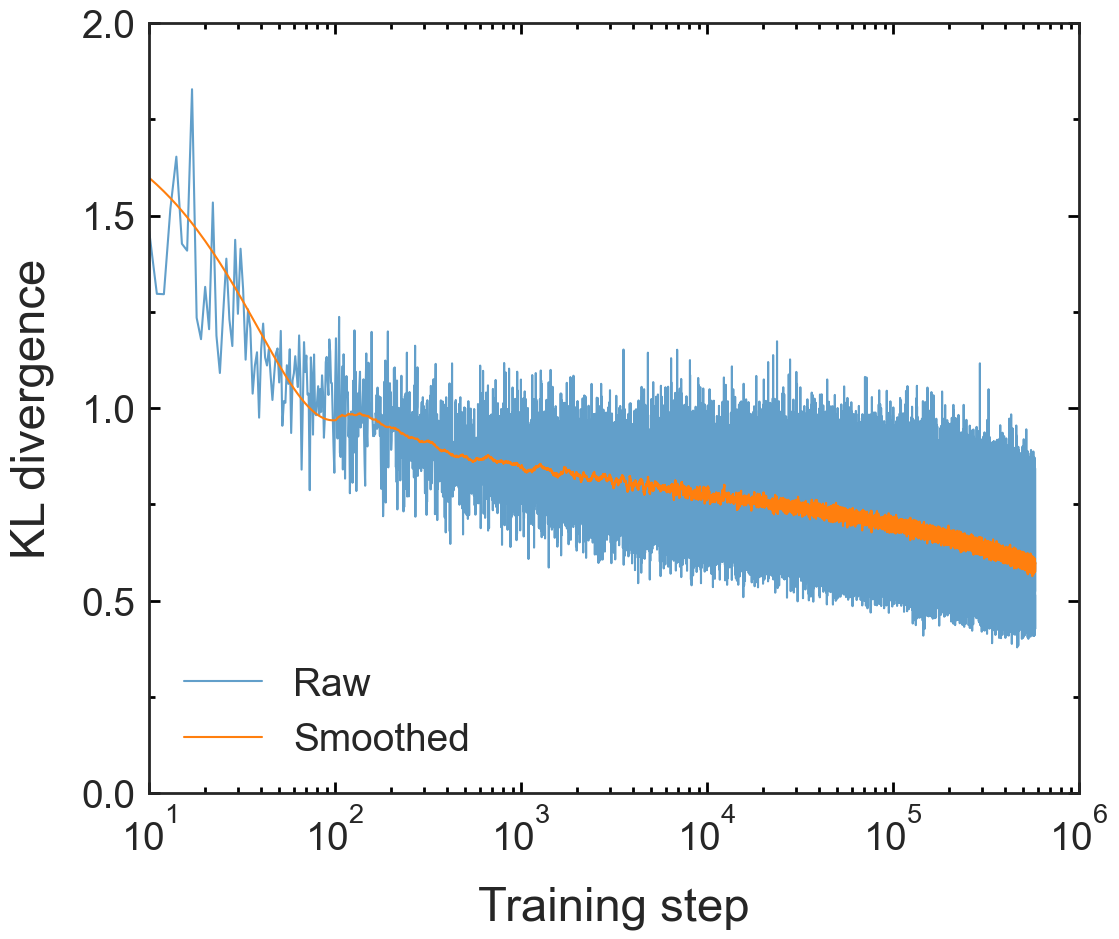

In [4]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(np.array(train_dic['loss']),zorder=-10, alpha=0.7, label='Raw')
ax.plot(smoothed, label='Smoothed')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
# ax.axes.set_xlim([100,100000])
ax.axes.set_xlim([10,1000000])
# ax.axes.set_ylim([0,4.5])
ax.axes.set_ylim([0,2])
ax.set_xscale('log')

ax.set_xlabel(r'Training step', labelpad=20, fontsize=34)
ax.set_ylabel(r'KL divergence', labelpad=20, fontsize=34)
# plt.legend(loc="upper right",fontsize=28)
plt.legend(loc="lower left",fontsize=28)

plt.savefig(os.path.join(folder, 'models', model_folder, 'train_loss.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')

In [5]:
del train_dic

# 1 Dataloader

In [122]:
del dataloader

In [123]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    max_n_mix:         Maximum number of componds in XRD mix
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  max_n_mix=3, fix_n_phase=False, resonable_mixing=False, min_mixing_ratio=0.05, 
                  peak_probability_range=(0.2, 1), crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.randint(1, max_n_mix+1, batch_size)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing:
                self.sample_idxs = []
                samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                if fix_n_phase:
                    try:
                        samples = np.random.choice(samples, max_n_mix, replace=False)
                    except:
                        continue
                else:
                    samples = np.random.choice(samples, max(min(self.n_mix_list[i],len(samples)),2), replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Missing peak
                self.X = self.X * np.random.binomial(1, np.random.uniform(*peak_probability_range), self.X.shape[0])
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])

                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [124]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2 Load model

In [4]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
# model_folder = '20240910 multi phase reasonable mixing diverse prompt'
# num_of_epochs = 1000000
model_folder = '20240907 single phase diverse prompt'
num_of_epochs = 100000
cif_folder = os.path.join(folder, 'cif')
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', 
                                                                    model_folder, '{}'.format(num_of_epochs))).to('cuda')

# 3.1 single phase classification (none / EDS / Precursor)

In [310]:
try:
    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'rb') as handle:
        test_dataset = joblib.load(handle)
    
    Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    print('test dataset loaded.')

except:
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1000, max_n_mix=1,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.1, 1), min_mixing_ratio=0.3)
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

    with open(os.path.join(cif_folder, 'test_dataset.npy'), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')

test dataset loaded.


In [311]:
y_true, y_pred, y_formula, y_pred_full = [], [], [], []
prompt_type_list = [None,'eds','full']
prompt_type = prompt_type_list[0]

for i in range(len(element_list)):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    X_prompts = []
    random.shuffle(element_list[i])
    if prompt_type == None:
        X_prompts.append('')
    elif prompt_type == 'eds':
        X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
    elif prompt_type == 'full':
        X_prompts.append(' '.join(element_list[i]))
#         X_prompts.append('Cs Pb I Br')

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    logits = outputs.logits
    y_true.append(np.array(labels).argmax(-1)[0])
    y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
    y_pred_full.append(np.array(logits.detach().cpu()[0]))
    y_formula.append(formula_list[i])
    
    print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])
    
y_pred_full = np.array(y_pred_full)

[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['MA0.6FA0.4PbBr3'] 49 48
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbBr3'] 0 26
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsI'] 18 18
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['gamma-CsPbI3'] 38 38
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.8Cl0.2)3'] 31 36
[''] ['PbBr2'] 64 64
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbI3'] 5 16
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['cubic-CsPbCl3'] 35 22
[''] ['cubic-CsPbBr3'] 32 25
[''] ['Cs0.8MA0.2PbI3'] 15 36
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['cubic-MAPbBr3'] 59 55
[''] ['CsPb(I0.4Cl0.6)3'] 29 27
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['cubic-MAPbBr3'] 59 59
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['alpha-FAPbI3'] 44 44
[''] ['delta-CsPbI3'] 37 

[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['MA0.2FA0.8PbI3'] 51 39
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(I0.4Cl0.6)3'] 29 3
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['CsPb(I0.4Cl0.6)3'] 29 36
[''] ['Cs0.4MA0.6PbBr3'] 9 15
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['MAPb(Br0.2I0.8)3'] 55 31
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Cs0.8FA0.2PbBr3'] 3 10
[''] ['Cs0.6MA0.4PbBr3'] 10 25
[''] ['Cs0.6FA0.4PbBr3'] 2 8
[''] ['Cs0.8MA0.2PbI3'] 15 36
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Pnma-CsPbCl3'] 34 47
[''] ['beta-FAPbI3'] 45 41
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['delta-CsPbI3'] 37 38
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.4Br0.6)3'] 25 31
[''] ['Cs0.4MA0.6PbI3'] 13 14
[''] ['PbI2'] 65 65
[''] ['CsPb(Cl0.8Br0.2)3'] 23 34
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['Cs0.6FA0.4PbBr3'] 2 8
[''] ['CsPb(I0.2Cl0.8)3'] 

[''] ['CsPb2Br5'] 19 19
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['CsBr'] 17 17
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['MA0.2FA0.8PbBr3'] 47 62
[''] ['cubic-FAPbBr3'] 43 12
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb(Cl0.6Br0.4)3'] 22 62
[''] ['MA0.8FA0.2PbBr3'] 50 44
[''] ['CsPb2Br5'] 19 63
[''] ['CsPb(I0.4Br0.6)3'] 25 11
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['delta-CsPbI3'] 37 37
[''] ['MAPb(Br0.2I0.8)3'] 55 27
[''] ['alpha-CsPbI3'] 36 15
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.8FA0.2PbI3'] 7 41
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4FA0.6PbBr3'] 1 15
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['cubic-CsPbCl3'] 35 35
[''] ['delta-CsPbI3'] 37 37
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['MA0.4FA0.6PbBr3'] 48 49
[''] ['delta-FAPbI3'] 46 46
[''] ['gamma-CsPbI3'] 38 38
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.8Br0.2)3'] 27 8
[''] ['CsPb(I0.6B

[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['CsPb(I0.2Cl0.8)3'] 28 25
[''] ['PbBr2'] 64 64
[''] ['Cs0.4FA0.6PbBr3'] 1 24
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbI3'] 14 13
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.6FA0.4PbBr3'] 2 9
[''] ['delta-CsPbI3'] 37 37
[''] ['beta-FAPbI3'] 45 41
[''] ['CsPb(Cl0.2Br0.8)3'] 20 62
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['Cs0.6MA0.4PbI3'] 14 36
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Cs4PbBr6'] 16 16
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsI'] 18 18
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['Cs0.4FA0.6PbBr3'] 1 29
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['PbI2'] 65 65
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.8FA0.2PbI3'] 7 41
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['gamma-CsPb

In [45]:
for i in range(5):
    print(torch.topk(outputs.logits[0], i+1).indices)

tensor([34], device='cuda:0')
tensor([34, 43], device='cuda:0')
tensor([34, 43,  1], device='cuda:0')
tensor([34, 43,  1, 23], device='cuda:0')
tensor([34, 43,  1, 23, 35], device='cuda:0')


In [ ]:
for k in range(1,6):
    print('top {}:'.format(k), top_k_accuracy_score(y_true_full, y_pred_full, k=k))

## Fig 2a-c

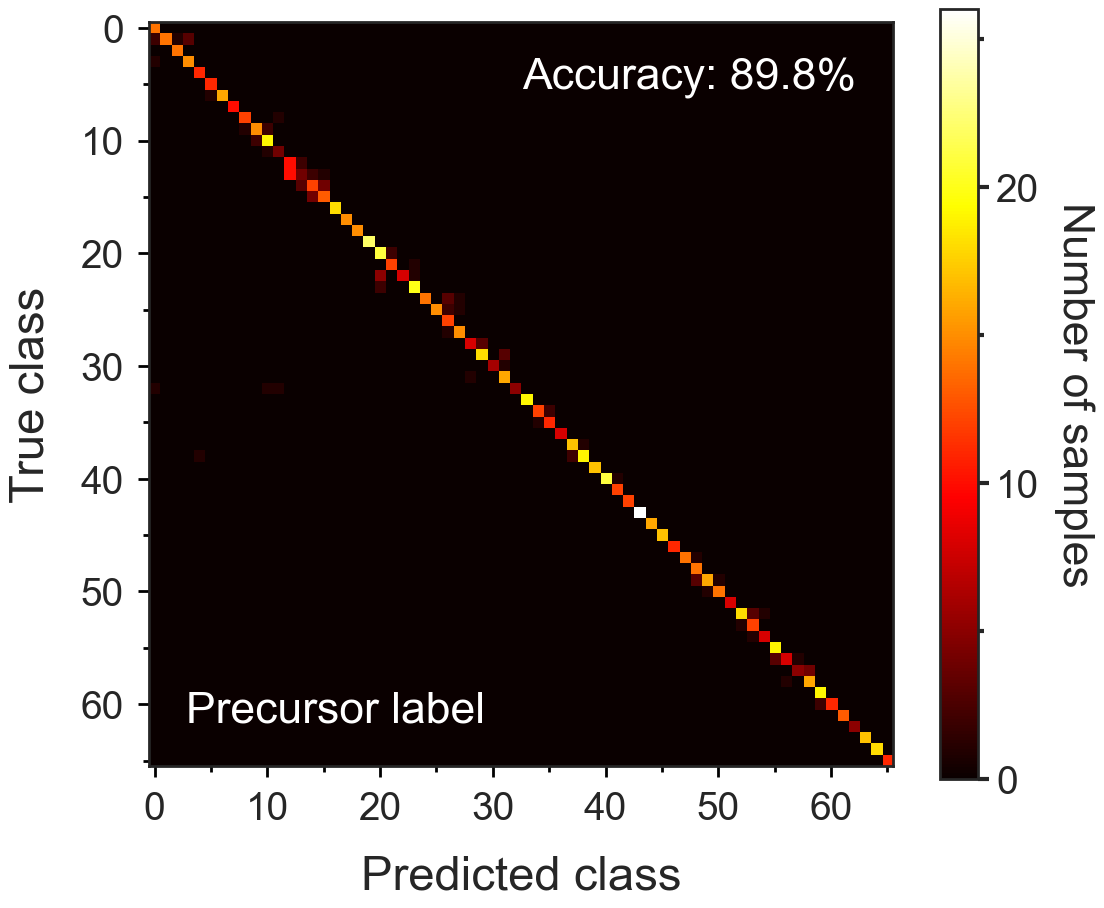

In [16]:
load_plt_setting()

report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
         transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
plt.text(0.05, 0.06, 'Precursor label', fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

plt.savefig(os.path.join(folder, 'models', model_folder, 'classification_Precursor.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Fig 2e

In [313]:
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        print(i,'\t',str(y_true[i])+'\t'+dataloader.dataset[dataloader.sample_list[y_true[i]]]['formula']+'\t\t'+str(y_pred[i])+'\t'+
             dataloader.dataset[dataloader.sample_list[y_pred[i]]]['formula'])

1 	 49	MA0.6FA0.4PbBr3		48	MA0.4FA0.6PbBr3
3 	 0	Cs0.2FA0.8PbBr3		26	CsPb(I0.6Br0.4)3
16 	 31	CsPb(I0.8Cl0.2)3		36	alpha-CsPbI3
20 	 5	Cs0.4FA0.6PbI3		16	Cs4PbBr6
22 	 35	cubic-CsPbCl3		22	CsPb(Cl0.6Br0.4)3
23 	 32	cubic-CsPbBr3		25	CsPb(I0.4Br0.6)3
24 	 15	Cs0.8MA0.2PbI3		36	alpha-CsPbI3
27 	 59	cubic-MAPbBr3		55	MAPb(Br0.2I0.8)3
28 	 29	CsPb(I0.4Cl0.6)3		27	CsPb(I0.8Br0.2)3
34 	 48	MA0.4FA0.6PbBr3		10	Cs0.6MA0.4PbBr3
38 	 10	Cs0.6MA0.4PbBr3		3	Cs0.8FA0.2PbBr3
39 	 56	MAPb(Br0.4I0.6)3		55	MAPb(Br0.2I0.8)3
44 	 10	Cs0.6MA0.4PbBr3		3	Cs0.8FA0.2PbBr3
46 	 32	cubic-CsPbBr3		26	CsPb(I0.6Br0.4)3
48 	 13	Cs0.4MA0.6PbI3		15	Cs0.8MA0.2PbI3
49 	 3	Cs0.8FA0.2PbBr3		27	CsPb(I0.8Br0.2)3
51 	 15	Cs0.8MA0.2PbI3		36	alpha-CsPbI3
55 	 10	Cs0.6MA0.4PbBr3		25	CsPb(I0.4Br0.6)3
56 	 48	MA0.4FA0.6PbBr3		10	Cs0.6MA0.4PbBr3
57 	 56	MAPb(Br0.4I0.6)3		31	CsPb(I0.8Cl0.2)3
59 	 9	Cs0.4MA0.6PbBr3		15	Cs0.8MA0.2PbI3
60 	 56	MAPb(Br0.4I0.6)3		55	MAPb(Br0.2I0.8)3
63 	 32	cubic-CsPbBr3		15	Cs0.8MA0.2PbI3
65 	 30	CsPb

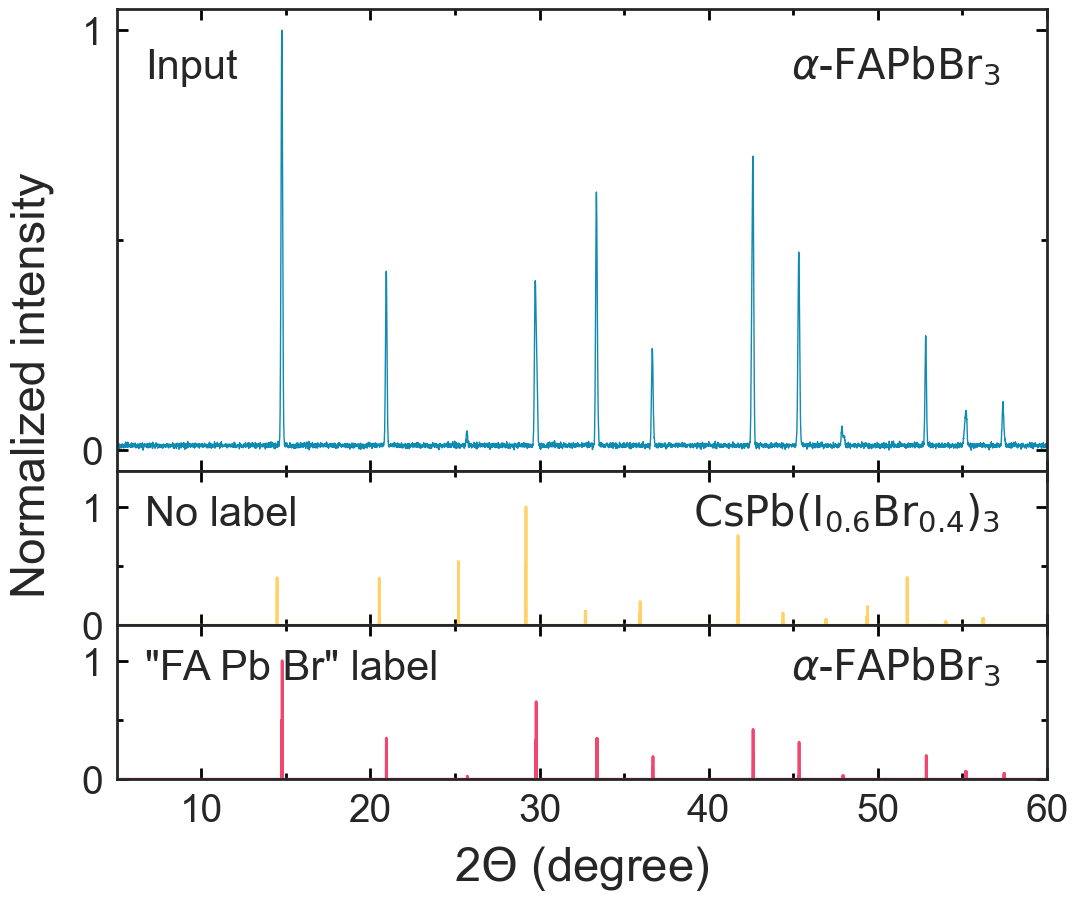

In [314]:
load_plt_setting()

twotheta = np.arange(5.00, 60.01, 0.01)
data1 = Xs[604,:,0]
data2 = dataloader.load_ref(26)
data3 = dataloader.load_ref(43)

alpha = 0.7

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 1, 1]),figsize=(12, 10))
mat1 = ax0.plot(twotheta, data1, linewidth=1, color=colors.to_rgba('#118ab2'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.05])

mat2 = ax1.plot(twotheta, data2, linewidth=2, color=colors.to_rgba('#ffd166'))
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.3])

mat2 = ax2.plot(twotheta, data3, linewidth=2, color=colors.to_rgba('#ef476f'))
ax2.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.axes.set_ylim([0,1.3])
# ax2.axes.set_xlim([22.5,30])
ax2.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.03, 0.85, 'Input', fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.95, 0.85, r'$\alpha$'+'-'+r'$\mathrm{FAPbBr_{3}}$', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.03, 0.65, 'No label', fontsize=30, transform=ax1.transAxes, horizontalalignment='left')
plt.text(0.95, 0.65, r'$\mathrm{CsPb(I_{0.6}Br_{0.4})_{3}}$', fontsize=30, transform=ax1.transAxes, horizontalalignment='right')

plt.text(0.03, 0.65, '"FA Pb Br" label', fontsize=30, transform=ax2.transAxes, horizontalalignment='left')
plt.text(0.95, 0.65, r'$\alpha$'+'-'+r'$\mathrm{FAPbBr_{3}}$', fontsize=30, transform=ax2.transAxes, horizontalalignment='right')

# plt.text(0.96, 0.75, 'n = 1000', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Normalized intensity                      ', labelpad=20, fontsize=34)
plt.savefig(os.path.join(folder, 'models', model_folder, 'Wrong_prediction.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Fig 2d

In [20]:
default_label_pred = y_pred

In [25]:
FAPbI_pred = y_pred

In [37]:
CsPbIBr_pred = y_pred

In [76]:
np.savetxt(os.path.join(folder, 'models', model_folder, 'Probability_vs_prompt.csv'),  
               np.swapaxes(np.asarray([default_label_pred,FAPbI_pred,CsPbIBr_pred]),0,1), 
               header='Default prompt / FA-Pb-I prompt / Cs-Pb-I-Br prompt',)

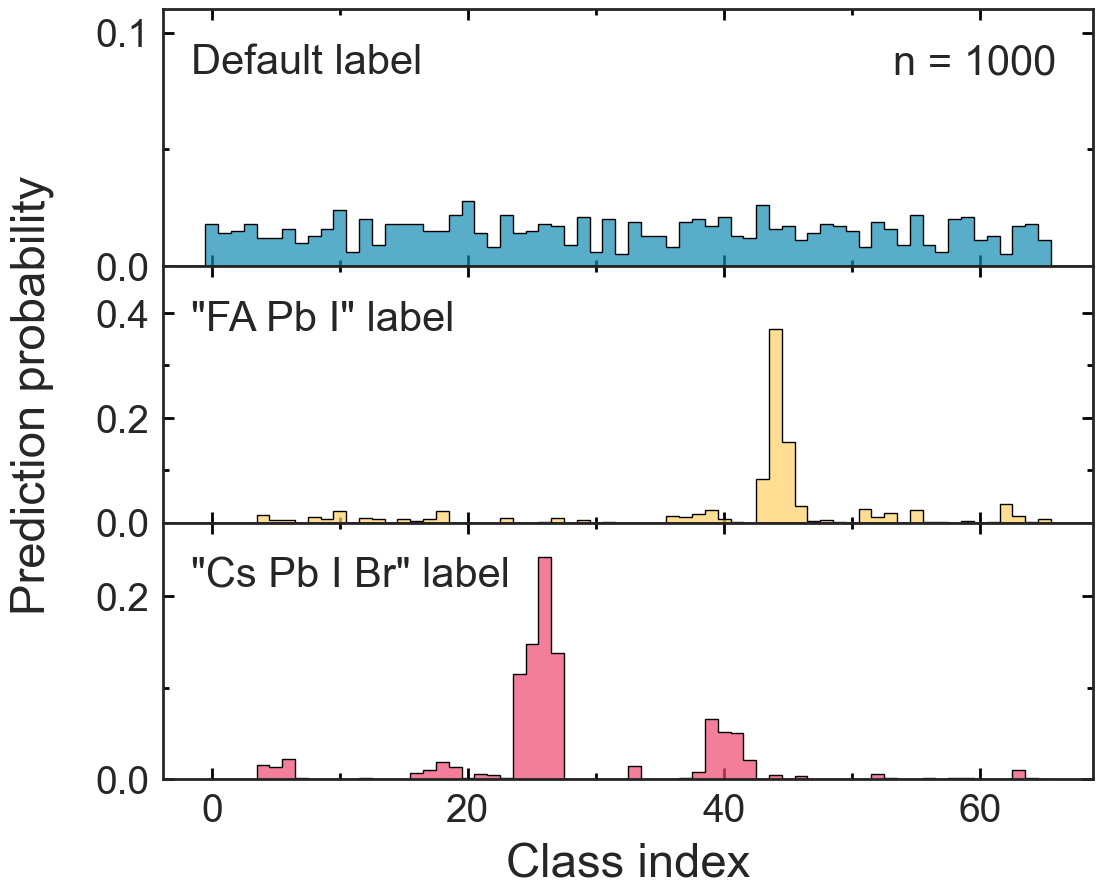

In [315]:
load_plt_setting()

sample_names = ['Default label','"FA Pb I" label','"Cs Pb I Br" label']

data1 = default_label_pred
data2 = FAPbI_pred
data3 = CsPbIBr_pred
# samples = [r'TiO$_{2}$ 0 mol% K$^{+}$',r'TiO$_{2}$ 10 mol% K$^{+}$',r'SnO$_{2}$ 0 mol% K$^{+}$',r'SnO$_{2}$ 10 mol% K$^{+}$']

wav_range = (-0.5,65.5)
bins = round((wav_range[1]-wav_range[0])*1)
alpha = 0.7

kwargs1 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#118ab2')[:-1]+(alpha,))
kwargs2 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#ffd166')[:-1]+(alpha,))
kwargs3 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#ef476f')[:-1]+(alpha,))
# kwargs4 = dict(histtype='stepfilled', density=False, bins=bins, ec="black", range=wav_range, fc = colors.to_rgba('#118ab2')[:-1]+(alpha,))

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[1, 1, 1]),figsize=(12, 10))
mat1 = ax0.hist(data1, **kwargs1, label=sample_names[0], linewidth=1)
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([0,0.11])

mat2 = ax1.hist(data2, **kwargs2, label=sample_names[1], linewidth=1)
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,0.49])

mat2 = ax2.hist(data3, **kwargs3, label=sample_names[2], linewidth=1)
ax2.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.axes.set_ylim([0,0.28])

plt.text(0.03, 0.75, sample_names[0], fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, sample_names[1], fontsize=30, transform=ax1.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, sample_names[2], fontsize=30, transform=ax2.transAxes, horizontalalignment='left')

plt.text(0.96, 0.75, 'n = 1000', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax2.set_xlabel(r'Class index', labelpad=10, fontsize=34)
ax1.set_ylabel(r'Prediction probability', labelpad=30, fontsize=34)
plt.savefig(os.path.join(folder, 'models', model_folder, 'Probability_vs_prompt.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

# 3.2 Multi label classification

In [5]:
full_result = {}
prompt_type_list = ['none','eds','full']

for prompt_type in prompt_type_list:
    full_result[prompt_type] = {}
    
    for i in [2,3]:
        full_result[prompt_type]['{}'.format(i)] = {'labels':[], 'outputs':[], 'result':[]}

In [8]:
max_n_mix = 3
fix_n_phase = True
resonable_mixing = True

if fix_n_phase:
    file_name = 'test_dataset_multilabel_{}.npy'.format(max_n_mix)
else:
    file_name = 'test_dataset_multilabel.npy'
    
try:
    with open(os.path.join(cif_folder, file_name), 'rb') as handle:
        test_dataset = joblib.load(handle)

    Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    print('test dataset loaded.')

except:
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=1000, max_n_mix=max_n_mix, fix_n_phase=True, resonable_mixing=resonable_mixing,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.01, 1))
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

    with open(os.path.join(cif_folder, file_name), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')


test dataset loaded.


In [9]:
for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, result = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == 'none':
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(Ys[i:i+1]).to(dtype=torch.float32)
        outputs = model(**inputs.to('cuda'), output_attentions=True)

        full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['labels'].append(np.array(Ys[i:i+1])[0])
        full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['outputs'].append(np.array(outputs.logits.detach().cpu())[0])

        labels = np.array(labels[0].nonzero().view(-1))
        logits = torch.topk(outputs.logits[0], len(labels)).indices

        y_true.append(list(labels))
        y_pred.append(list(np.array(logits.detach().cpu())))

        if set(y_true[-1]) == set(y_pred[-1]):
            result.append(0)
            full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['result'].append(0)
        else:
            result.append(1)
            full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['result'].append(1)

        y_formula.append(formula_list[i])

        print(y_formula[-1],y_true[-1],y_pred[-1])

    result = np.array(result)

['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48, 59, 60] [63, 46, 44]
['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [64, 33, 6]
['Cs4PbBr6', 'CsPb2Br5', 'CsBr'] [16, 17, 19] [4, 38, 37]
['alpha-CsPbI3', 'delta-CsPbI3', 'PbI2'] [36, 37, 65] [39, 37, 51]
['cubic-CsPbBr3', 'CsPb(I0.8Br0.2)3', 'PbI2'] [27, 32, 65] [54, 41, 64]
['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 33, 6]
['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3', 'delta-FAPbI3'] [46, 51, 52] [38, 4, 39]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [33, 64, 61]
['PbI2', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58, 60, 65] [19, 63, 54]
['beta-FAPbI3', 'PbI2', 'MA0.4FA0.6PbI3'] [45, 52, 65] [16, 51, 4]
['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3', 'CsPb(Cl0.2Br0.8)3'] [20, 23, 32] [63, 46, 54]
['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'orthorhombic-CsPbBr3'] [10, 32, 33] [33, 64, 61]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 5, 33]
['gamma-CsPbI3', 'Cs0.4MA0

['PbI2', 'CsI', 'Cs0.6FA0.4PbI3'] [6, 18, 65] [39, 37, 51]
['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsBr'] [16, 17, 33] [4, 39, 38]
['CsPb(Cl0.8Br0.2)3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3'] [22, 23, 33] [51, 37, 16]
['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [38, 4, 37]
['PbBr2', 'CsBr', 'orthorhombic-CsPbBr3'] [17, 33, 64] [33, 38, 16]
['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44, 45, 46] [16, 4, 38]
['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 40, 41]
['FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3', 'beta-FAPbI3'] [40, 42, 45] [38, 4, 39]
['tetragonal-MAPbI3', 'PbI2', 'beta-FAPbI3'] [45, 63, 65] [38, 37, 33]
['PbI2', 'alpha-CsPbI3', 'delta-CsPbI3'] [36, 37, 65] [38, 4, 33]
['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [33, 61, 63]
['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [5, 16, 6]
['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [33, 61, 19]
['alpha-CsPbI3', 'cubic-CsPbCl3', 'gamma-CsPbI3'] [35, 36

['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [10, 59, 60] [63, 19, 1]
['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44, 46, 65] [53, 64, 40]
['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 32, 33] [38, 4, 33]
['Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3'] [21, 34, 35] [19, 34, 63]
['Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [9, 10, 19] [64, 45, 54]
['Cs0.2MA0.8PbI3', 'gamma-CsPbI3', 'tetragonal-MAPbI3'] [12, 38, 63] [38, 33, 4]
['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45, 46, 65] [38, 4, 33]
['cubic-CsPbBr3', 'PbBr2', 'orthorhombic-CsPbBr3'] [32, 33, 64] [38, 4, 37]
['CsPb(I0.4Cl0.6)3', 'cubic-CsPbCl3', 'alpha-CsPbI3'] [29, 35, 36] [63, 61, 64]
['alpha-FAPbI3', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 44, 46] [51, 39, 4]
['cubic-CsPbBr3', 'PbBr2', 'Cs4PbBr6'] [16, 32, 64] [38, 4, 37]
['cubic-CsPbBr3', 'Cs0.4FA0.6PbBr3', 'Cs4PbBr6'] [1, 16, 32] [4, 39, 51]
['MA0.8FA0.2PbBr3', 'cubic-MAPbBr3', 'cubic-FAPbBr3'] [43, 50, 59] [63, 19, 36]
['PbI2', 'CsI', 

['Cs0.4FA0.6PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [1, 32, 33] [33, 61, 64]
['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [5, 6, 7] [39, 37, 38]
['Cs0.4MA0.6PbBr3', 'orthorhombic-CsPbBr3', 'Cs0.2MA0.8PbBr3'] [8, 9, 33] [33, 61, 38]
['orthorhombic-CsPbBr3', 'CsBr', 'cubic-CsPbBr3'] [17, 32, 33] [33, 61, 64]
['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36, 38, 65] [33, 64, 6]
['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [64, 61, 7]
['PbBr2', 'CsPb(I0.4Br0.6)3', 'CsBr'] [17, 25, 64] [37, 38, 64]
['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 5, 6]
['PbBr2', 'cubic-CsPbCl3', 'CsPb2Br5'] [19, 35, 64] [38, 37, 4]
['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [61, 63, 33]
['MA0.6FA0.4PbI3', 'MA0.8FA0.2PbI3', 'MA0.2FA0.8PbI3'] [51, 53, 54] [38, 4, 39]
['orthorhombic-CsPbBr3', 'PbBr2', 'alpha-CsPbI3'] [33, 36, 64] [39, 37, 51]
['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44, 45, 65] [5, 6, 40]
['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 

['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [33, 16, 64]
['gamma-CsPbI3', 'Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15, 38, 62] [38, 4, 37]
['MA0.8FA0.2PbI3', 'MA0.2FA0.8PbI3', 'beta-FAPbI3'] [45, 51, 54] [38, 37, 4]
['PbBr2', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 33, 64] [38, 39, 37]
['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [5, 6, 7] [38, 39, 37]
['CsI', 'delta-CsPbI3', 'gamma-CsPbI3'] [18, 37, 38] [37, 39, 38]
['tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.6MA0.4PbI3'] [13, 14, 63] [63, 61, 64]
['alpha-FAPbI3', 'cubic-FAPbBr3', 'FAPb(Br0.6I0.4)3'] [41, 43, 44] [16, 51, 6]
['alpha-CsPbI3', 'CsI', 'PbI2'] [18, 36, 65] [63, 7, 41]
['CsPb(Cl0.2Br0.8)3', 'PbBr2', 'CsPb(Cl0.8Br0.2)3'] [20, 23, 64] [16, 5, 64]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [5, 64, 6]
['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [63, 33, 19]
['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [39, 37, 38]
['PbI2', 'delta-FAPbI3', 'alpha-FAPbI

['CsBr', 'cubic-FAPbBr3', 'cubic-CsPbBr3'] [17, 32, 43] [42, 63, 19]
['PbBr2', 'delta-CsPbI3', 'CsPb(I0.8Br0.2)3'] [27, 37, 64] [38, 37, 4]
['PbBr2', 'alpha-CsPbI3', 'CsI'] [18, 36, 64] [37, 39, 51]
['CsPb(I0.6Cl0.4)3', 'PbI2', 'Pnma-CsPbCl3'] [30, 34, 65] [63, 42, 19]
['beta-FAPbI3', 'FAPb(Br0.6I0.4)3', 'delta-FAPbI3'] [41, 45, 46] [38, 37, 4]
['gamma-CsPbI3', 'PbI2', 'CsPb(I0.6Cl0.4)3'] [30, 38, 65] [4, 38, 39]
['Cs4PbBr6', 'CsBr', 'cubic-MAPbBr3'] [16, 17, 59] [4, 51, 39]
['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36, 37, 38] [38, 33, 37]
['delta-CsPbI3', 'CsI', 'Cs0.4MA0.6PbI3'] [13, 18, 37] [37, 39, 38]
['Cs4PbBr6', 'Cs0.2MA0.8PbBr3', 'cubic-CsPbBr3'] [8, 16, 32] [4, 33, 16]
['CsPb(I0.8Br0.2)3', 'CsI', 'Cs4PbBr6'] [16, 18, 27] [33, 64, 61]
['MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3'] [56, 57, 58] [63, 61, 19]
['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62, 63, 65] [61, 64, 33]
['Cs0.2FA0.8PbBr3', 'orthorhombic-CsPbBr3', 'CsBr'] [0, 17, 33] [38, 33, 4]
['d

['Cs4PbBr6', 'CsI', 'CsPb(I0.8Br0.2)3'] [16, 18, 27] [52, 61, 64]
['MA0.2FA0.8PbI3', 'MA0.8FA0.2PbI3', 'MA0.6FA0.4PbI3'] [51, 53, 54] [38, 37, 39]
['MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56, 58, 60] [63, 19, 42]
['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44, 46, 65] [16, 5, 33]
['PbBr2', 'MA0.4FA0.6PbBr3', 'cubic-MAPbBr3'] [48, 59, 64] [61, 33, 63]
['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44, 45, 46] [51, 4, 37]
['CsBr', 'CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.4Br0.6)3'] [17, 20, 21] [34, 46, 61]
['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [64, 61, 53]
['cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3'] [0, 3, 43] [19, 63, 42]
['Cs4PbBr6', 'Cs0.2FA0.8PbBr3', 'Cs0.4FA0.6PbBr3'] [0, 1, 16] [51, 16, 4]
['CsBr', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [17, 19, 33] [33, 61, 38]
['CsPb(Cl0.2Br0.8)3', 'cubic-CsPbCl3', 'CsBr'] [17, 20, 35] [19, 63, 46]
['Cs0.6MA0.4PbBr3', 'PbBr2', 'Cs0.2MA0.8PbBr3'] [8, 10, 64] [5, 64, 16]
['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3

['delta-FAPbI3', 'Cs0.2FA0.8PbI3', 'CsI'] [4, 18, 46] [4, 51, 38]
['delta-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18, 36, 37] [33, 61, 63]
['cubic-FAPbBr3', 'delta-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39, 43, 46] [37, 39, 38]
['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [61, 33, 64]
['PbBr2', 'MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3'] [48, 60, 64] [33, 16, 64]
['alpha-CsPbI3', 'delta-CsPbI3', 'gamma-CsPbI3'] [36, 37, 38] [37, 38, 39]
['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsBr'] [16, 17, 33] [4, 38, 51]
['PbI2', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [5, 7, 65] [38, 4, 39]
['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 32, 33] [33, 61, 38]
['Cs0.4FA0.6PbBr3', 'cubic-FAPbBr3', 'Cs4PbBr6'] [1, 16, 43] [51, 37, 4]
['alpha-FAPbI3', 'CsI', 'alpha-CsPbI3'] [18, 36, 44] [63, 19, 1]
['MA0.4FA0.6PbI3', 'PbI2', 'MA0.8FA0.2PbI3'] [52, 54, 65] [51, 4, 16]
['CsPb2Br5', 'cubic-CsPbBr3', 'cubic-MAPbBr3'] [19, 32, 59] [64, 33, 61]
['PbBr2', 'MA0.4FA0.6PbBr3', 'cubic-FAPbBr3'] [43, 48, 64] [6, 64, 5]

['MAPb(Br0.6I0.4)3', 'tetragonal-MAPbBr3', 'alpha-MAPbI3'] [57, 60, 62] [7, 63, 41]
['PbBr2', 'FAPb(Br0.4I0.6)3', 'beta-FAPbI3'] [40, 45, 64] [38, 37, 4]
['PbBr2', 'MA0.4FA0.6PbBr3', 'cubic-FAPbBr3'] [43, 48, 64] [33, 61, 64]
['FAPb(Br0.6I0.4)3', 'PbBr2', 'beta-FAPbI3'] [41, 45, 64] [38, 37, 4]
['CsBr', 'CsPb(I0.2Br0.8)3', 'Cs4PbBr6'] [16, 17, 24] [38, 33, 4]
['PbBr2', 'MAPb(Br0.4I0.6)3', 'MAPb(Br0.2I0.8)3'] [55, 56, 64] [16, 51, 38]
['beta-FAPbI3', 'delta-FAPbI3', 'PbI2'] [45, 46, 65] [16, 5, 41]
['PbI2', 'delta-CsPbI3', 'alpha-CsPbI3'] [36, 37, 65] [39, 37, 38]
['CsPb(Cl0.6Br0.4)3', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19, 22, 33] [4, 38, 51]
['Cs0.6MA0.4PbI3', 'tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3'] [13, 14, 63] [19, 33, 61]
['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44, 45, 65] [16, 51, 37]
['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44, 45, 65] [38, 37, 33]
['PbBr2', 'cubic-CsPbBr3', 'CsPb2Br5'] [19, 32, 64] [38, 37, 39]
['cubic-FAPbBr3', 'MA0.8FA0.2PbBr3', 'PbBr2'] [43, 50, 64] [64, 33

['CsPb(Cl0.2Br0.8)3', 'PbBr2', 'Cs4PbBr6'] [16, 20, 64] [39, 37, 38]
['PbBr2', 'Cs4PbBr6', 'CsBr'] [16, 17, 64] [33, 38, 4]
['PbBr2', 'CsBr', 'cubic-CsPbBr3'] [17, 32, 64] [16, 33, 64]
['cubic-FAPbBr3', 'PbBr2', 'FAPb(Br0.4I0.6)3'] [40, 43, 64] [40, 33, 55]
['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [45, 61, 51]
['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16, 32, 33] [16, 38, 33]
['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44, 45, 46] [51, 4, 37]
['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10, 59, 60] [1, 9, 32]
['delta-CsPbI3', 'CsI', 'Cs0.8MA0.2PbI3'] [15, 18, 37] [38, 37, 4]
['CsPb(Cl0.2Br0.8)3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3'] [20, 22, 33] [33, 61, 38]
['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62, 63, 65] [45, 54, 53]
['MA0.8FA0.2PbI3', 'beta-FAPbI3', 'tetragonal-MAPbI3'] [45, 54, 63] [38, 51, 37]
['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [63, 53, 52]
['PbI2', 'orthorhombic-CsPbBr3', 'PbBr2'] [33, 64

['PbI2', 'delta-CsPbI3', 'CsI'] [18, 37, 65] [37, 38, 4]
['CsPb(I0.6Cl0.4)3', 'cubic-CsPbCl3', 'PbI2'] [30, 35, 65] [30, 63, 29]
['CsPb(I0.2Cl0.8)3', 'CsI', 'gamma-CsPbI3'] [18, 28, 38] [38, 4, 37]
['CsI', 'CsPb(I0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [18, 24, 33] [39, 27, 33]
['FAPb(Br0.8I0.2)3', 'FAPb(Br0.6I0.4)3', 'PbBr2'] [41, 42, 64] [39, 38, 37]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50, 59, 60] [50, 60, 48]
['PbBr2', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [32, 33, 64] [33, 16, 38]
['CsPb(Cl0.4Br0.6)3', 'CsPb(Cl0.2Br0.8)3', 'CsPb2Br5'] [19, 20, 21] [19, 33, 61]
['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36, 38, 65] [38, 37, 4]
['CsI', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [6, 7, 18] [37, 38, 39]
['Cs0.2FA0.8PbBr3', 'Cs0.6FA0.4PbBr3', 'CsBr'] [0, 2, 17] [19, 63, 42]
['alpha-FAPbI3', 'tetragonal-MAPbI3', 'MA0.2FA0.8PbI3'] [44, 51, 63] [37, 51, 38]
['Pnma-CsPbCl3', 'gamma-CsPbI3', 'PbI2'] [34, 38, 65] [38, 4, 37]
['CsPb2Br5', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16, 19, 3

['Cs4PbBr6', 'Cs0.6FA0.4PbBr3', 'PbBr2'] [2, 16, 64] [38, 4, 33]
['PbBr2', 'Cs4PbBr6', 'CsBr'] [16, 17, 64] [38, 4, 37]
['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62, 63, 65] [63, 45, 61]
['delta-CsPbI3', 'CsPb(I0.6Br0.4)3', 'alpha-CsPbI3'] [26, 36, 37] [39, 37, 38]
['CsI', 'delta-CsPbI3', 'alpha-CsPbI3'] [18, 36, 37] [37, 38, 36]
['PbBr2', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 46, 64] [39, 37, 38]
['PbI2', 'beta-FAPbI3', 'delta-FAPbI3'] [45, 46, 65] [51, 16, 4]
['CsPb2Br5', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 19, 33] [33, 4, 19]
['PbBr2', 'tetragonal-MAPbBr3', 'cubic-FAPbBr3'] [43, 60, 64] [64, 61, 59]
['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3', 'Cs4PbBr6'] [0, 16, 32] [16, 33, 38]
['cubic-MAPbBr3', 'cubic-FAPbBr3', 'PbBr2'] [43, 59, 64] [64, 59, 16]
['delta-CsPbI3', 'alpha-MAPbI3', 'Cs0.2MA0.8PbI3'] [12, 37, 62] [37, 38, 4]
['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3', 'MA0.2FA0.8PbBr3'] [43, 47, 50] [49, 44, 64]
['MA0.8FA0.2PbBr3', 'PbBr2', 'cubic-FAPbBr3'] [43, 50, 64] [64, 61, 33]
['Cs0.6

['PbI2', 'PbBr2', 'tetragonal-MAPbBr3'] [60, 64, 65] [41, 40, 16]
['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [64, 59, 33]
['tetragonal-MAPbBr3', 'Cs0.8MA0.2PbBr3', 'CsBr'] [11, 17, 60] [19, 63, 33]
['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62, 63, 65] [45, 52, 53]
['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37, 38, 65] [38, 37, 4]
['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 33, 38]
['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19, 32, 33] [33, 16, 38]
['PbI2', 'Cs0.6MA0.4PbI3', 'Cs0.8MA0.2PbI3'] [14, 15, 65] [36, 15, 14]
['PbI2', 'gamma-CsPbI3', 'CsPb(I0.4Cl0.6)3'] [29, 38, 65] [37, 38, 39]
['MA0.6FA0.4PbI3', 'beta-FAPbI3', 'alpha-MAPbI3'] [45, 53, 62] [51, 4, 38]
['cubic-CsPbBr3', 'PbBr2', 'CsBr'] [17, 32, 64] [16, 33, 64]
['PbI2', 'alpha-MAPbI3', 'PbBr2'] [62, 64, 65] [39, 51, 16]
['gamma-CsPbI3', 'PbI2', 'CsI'] [18, 38, 65] [38, 4, 37]
['CsI', 'Pnma-CsPbCl3', 'CsPb(I0.8Cl0.2)3'] [18, 31, 34] [63, 19, 31]
['PbI2', 'tetragonal-MAPb

['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 59, 33]
['Cs4PbBr6', 'PbBr2', 'Cs0.4MA0.6PbBr3'] [9, 16, 64] [38, 4, 37]
['PbBr2', 'Cs0.6FA0.4PbBr3', 'cubic-CsPbBr3'] [2, 32, 64] [16, 33, 5]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 33, 59]
['tetragonal-MAPbI3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56, 58, 63] [40, 5, 64]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 59, 33]
['Cs0.6MA0.4PbBr3', 'CsBr', 'cubic-MAPbBr3'] [10, 17, 59] [19, 63, 32]
['Cs0.8MA0.2PbBr3', 'Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3'] [9, 10, 11] [10, 8, 3]
['gamma-CsPbI3', 'delta-CsPbI3', 'alpha-CsPbI3'] [36, 37, 38] [38, 37, 4]
['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [51, 16, 4]
['MA0.8FA0.2PbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 54] [51, 4, 39]
['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [51, 16, 61]
['Pnma-CsPbCl3', 'CsI', 'CsPb(I0.6Cl0.4)3'] [18, 30, 34] [29, 30, 28]
['delta-FAPbI3', 'tetragonal-MAPbI3

['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16, 17, 32] [16, 33, 38]
['PbI2', 'CsBr', 'orthorhombic-CsPbBr3'] [17, 33, 65] [39, 38, 4]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 59, 6]
['MA0.6FA0.4PbBr3', 'MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43, 49, 50] [49, 59, 9]
['MAPb(Br0.2I0.8)3', 'PbBr2', 'MAPb(Br0.6I0.4)3'] [55, 57, 64] [40, 39, 55]
['CsI', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [6, 7, 18] [37, 38, 4]
['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44, 46, 65] [53, 51, 64]
['CsI', 'PbI2', 'alpha-CsPbI3'] [18, 36, 65] [7, 63, 36]
['PbI2', 'delta-CsPbI3', 'CsI'] [18, 37, 65] [38, 37, 4]
['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [64, 45, 61]
['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [63, 53, 64]
['CsBr', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3'] [17, 33, 43] [33, 16, 6]
['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36, 37, 65] [38, 37, 4]
['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [47, 60, 64] [64, 16, 51]
['FAPb(Br0.6I0.4)3', 'FAPb(Br

['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45, 46, 65] [51, 16, 39]
['cubic-CsPbCl3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3'] [23, 33, 35] [33, 16, 64]
['CsPb(Cl0.2Br0.8)3', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16, 20, 33] [39, 38, 37]
['CsBr', 'CsPb2Br5', 'PbBr2'] [17, 19, 64] [16, 33, 37]
['PbI2', 'MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46, 52, 65] [51, 4, 16]
['orthorhombic-CsPbBr3', 'PbBr2', 'alpha-CsPbI3'] [33, 36, 64] [39, 38, 37]
['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 32, 33] [33, 19, 10]
['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 61, 59]
['delta-CsPbI3', 'Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3'] [12, 13, 37] [5, 6, 4]
['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [63, 51, 61]
['Cs0.6MA0.4PbI3', 'Cs0.2MA0.8PbI3', 'delta-CsPbI3'] [12, 14, 37] [5, 33, 6]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 61, 33]
['MA0.4FA0.6PbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [48, 49, 59] [49, 15, 14]
['delta-FAPbI3', 'PbI2', 'be

['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [64, 33, 59]
['Cs0.4MA0.6PbI3', 'CsI', 'Cs0.2MA0.8PbI3'] [12, 13, 18] [12, 13, 14]
['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'Cs0.4FA0.6PbI3'] [5, 6, 7] [38, 37, 4]
['CsI', 'CsPb(I0.2Cl0.8)3', 'cubic-CsPbCl3'] [18, 28, 35] [30, 7, 63]
['CsBr', 'Cs4PbBr6', 'Cs0.2MA0.8PbBr3'] [8, 16, 17] [16, 33, 51]
['Cs4PbBr6', 'PbBr2', 'cubic-CsPbBr3'] [16, 32, 64] [38, 33, 4]
['CsPb2Br5', 'orthorhombic-CsPbBr3', 'PbBr2'] [19, 33, 64] [38, 33, 37]
['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40, 41, 45] [39, 42, 4]
['Cs4PbBr6', 'cubic-CsPbBr3', 'CsBr'] [16, 17, 32] [16, 4, 51]
['CsBr', 'Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3'] [2, 17, 33] [33, 19, 16]
['CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3', 'PbBr2'] [21, 35, 64] [16, 33, 5]
['PbBr2', 'cubic-FAPbBr3', 'Cs0.6FA0.4PbBr3'] [2, 43, 64] [16, 33, 51]
['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [64, 33, 59]
['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45, 46, 65] [51, 4, 16]
['

['tetragonal-MAPbBr3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55, 60, 65] [41, 52, 42]
['PbI2', 'beta-FAPbI3', 'delta-FAPbI3'] [45, 46, 65] [51, 4, 45]
['alpha-FAPbI3', 'CsI', 'Cs0.6FA0.4PbI3'] [6, 18, 44] [6, 5, 4]
['FAPb(Br0.4I0.6)3', 'PbI2', 'cubic-FAPbBr3'] [40, 43, 65] [39, 40, 51]
['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3'] [20, 22, 34] [19, 42, 52]
['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 61, 59]
['gamma-CsPbI3', 'alpha-CsPbI3', 'Cs0.4FA0.6PbI3'] [5, 36, 38] [38, 4, 37]
['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3', 'Cs0.8FA0.2PbBr3'] [0, 3, 32] [1, 42, 7]
['alpha-CsPbI3', 'Cs0.8MA0.2PbI3', 'delta-CsPbI3'] [15, 36, 37] [38, 4, 51]
['Cs0.2MA0.8PbI3', 'gamma-CsPbI3', 'Cs0.4MA0.6PbI3'] [12, 13, 38] [4, 38, 51]
['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43, 50, 59] [50, 34, 49]
['FAPb(Br0.4I0.6)3', 'delta-FAPbI3', 'beta-FAPbI3'] [40, 45, 46] [39, 42, 38]
['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [52, 45, 61]
['cubic-CsPbBr3', 'CsPb(I

['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 45, 46] [39, 4, 38]
['alpha-MAPbI3', 'MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3'] [56, 57, 62] [63, 58, 64]
['Cs0.8MA0.2PbBr3', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [11, 19, 33] [33, 10, 9]
['Cs4PbBr6', 'cubic-CsPbBr3', 'CsPb2Br5'] [16, 19, 32] [38, 37, 33]
['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44, 45, 46] [51, 4, 45]
['PbI2', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36, 38, 65] [38, 4, 37]
['orthorhombic-CsPbBr3', 'CsBr', 'cubic-CsPbBr3'] [17, 32, 33] [33, 61, 19]
['gamma-CsPbI3', 'alpha-CsPbI3', 'delta-CsPbI3'] [36, 37, 38] [38, 37, 4]
['Cs0.4MA0.6PbI3', 'alpha-CsPbI3', 'CsI'] [13, 18, 36] [15, 14, 12]
['tetragonal-MAPbI3', 'MA0.4FA0.6PbI3', 'MA0.8FA0.2PbI3'] [52, 54, 63] [51, 39, 37]
['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [32, 33, 64] [16, 33, 61]
['CsPb2Br5', 'cubic-CsPbCl3', 'PbBr2'] [19, 35, 64] [39, 38, 37]
['delta-CsPbI3', 'beta-FAPbI3', 'CsI'] [18, 37, 45] [38, 4, 7]
['FAPb(Br0.6I0.4)3', 'FAPb(Br0.8I0.2)3', 'PbB

['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 46, 65] [16, 51, 45]
['MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3'] [47, 48, 60] [49, 44, 48]
['gamma-CsPbI3', 'PbI2', 'delta-CsPbI3'] [37, 38, 65] [38, 37, 4]
['alpha-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18, 36, 38] [38, 37, 4]
['CsBr', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16, 17, 33] [38, 37, 4]
['Cs0.2FA0.8PbBr3', 'Cs4PbBr6', 'Cs0.8FA0.2PbBr3'] [0, 3, 16] [4, 16, 33]
['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [38, 45, 46]
['orthorhombic-CsPbBr3', 'cubic-CsPbCl3', 'cubic-CsPbBr3'] [32, 33, 35] [33, 61, 38]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [59, 33, 64]
['CsPb(Cl0.2Br0.8)3', 'CsBr', 'CsPb2Br5'] [17, 19, 20] [33, 64, 61]
['alpha-FAPbI3', 'CsI', 'Cs0.8FA0.2PbI3'] [7, 18, 44] [6, 5, 7]
['cubic-CsPbCl3', 'CsPb(I0.6Cl0.4)3', 'PbI2'] [30, 35, 65] [30, 63, 42]
['alpha-CsPbI3', 'delta-CsPbI3', 'gamma-CsPbI3'] [36, 37, 38] [38, 37, 7]
['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'Cs0.2MA0.8PbBr3'

['CsPb(I0.2Br0.8)3', 'CsBr', 'cubic-CsPbBr3'] [17, 24, 32] [42, 63, 19]
['Cs0.2FA0.8PbBr3', 'CsPb2Br5', 'Cs0.6FA0.4PbBr3'] [0, 2, 19] [33, 61, 16]
['alpha-MAPbI3', 'tetragonal-MAPbI3', 'MA0.4FA0.6PbI3'] [52, 62, 63] [51, 53, 52]
['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [61, 64, 59]
['alpha-CsPbI3', 'cubic-CsPbBr3', 'CsPb2Br5'] [19, 32, 36] [38, 33, 27]
['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44, 45, 65] [51, 16, 45]
['CsBr', 'cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [17, 32, 33] [33, 19, 16]
['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40, 41, 45] [39, 42, 38]
['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'PbBr2'] [20, 22, 64] [16, 61, 33]
['PbI2', 'CsPb(I0.6Cl0.4)3', 'CsPb(I0.2Cl0.8)3'] [28, 30, 65] [7, 30, 29]
['CsBr', 'cubic-CsPbCl3', 'PbBr2'] [17, 35, 64] [16, 51, 6]
['cubic-MAPbBr3', 'MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3'] [47, 48, 59] [48, 47, 49]
['delta-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36, 37, 65] [38, 37, 4]
['PbBr2', 'cubic-MAPbBr3', 'tetragonal-M

['PbI2', 'CsI', 'Pnma-CsPbCl3'] [18, 34, 65] [31, 65, 29]
['PbI2', 'MA0.6FA0.4PbI3', 'alpha-MAPbI3'] [53, 62, 65] [51, 53, 61]
['FAPb(Br0.6I0.4)3', 'alpha-FAPbI3', 'FAPb(Br0.4I0.6)3'] [40, 41, 44] [39, 37, 38]
['CsPb(I0.2Cl0.8)3', 'CsPb(I0.6Cl0.4)3', 'gamma-CsPbI3'] [28, 30, 38] [4, 38, 37]
['cubic-FAPbBr3', 'MA0.4FA0.6PbBr3', 'PbBr2'] [43, 48, 64] [64, 51, 52]
['Cs4PbBr6', 'CsBr', 'orthorhombic-CsPbBr3'] [16, 17, 33] [33, 38, 16]
['cubic-CsPbBr3', 'PbBr2', 'Cs0.2FA0.8PbBr3'] [0, 32, 64] [16, 39, 33]
['Cs0.8FA0.2PbI3', 'delta-FAPbI3', 'alpha-CsPbI3'] [7, 36, 46] [37, 4, 6]
['CsPb(I0.8Br0.2)3', 'Cs4PbBr6', 'CsPb(I0.2Br0.8)3'] [16, 24, 27] [39, 4, 38]
['cubic-MAPbBr3', 'PbBr2', 'MA0.6FA0.4PbBr3'] [49, 59, 64] [64, 50, 49]
['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62, 63, 65] [63, 53, 62]
['CsPb(I0.6Br0.4)3', 'Cs4PbBr6', 'CsPb(I0.2Br0.8)3'] [16, 24, 26] [39, 37, 38]
['CsPb(Cl0.4Br0.6)3', 'CsBr', 'Pnma-CsPbCl3'] [17, 21, 34] [19, 42, 33]
['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'MA0.6F

['tetragonal-MAPbI3', 'cubic-MAPbBr3', 'alpha-MAPbI3'] [59, 62, 63] [33, 55, 52]
['Cs0.8FA0.2PbI3', 'CsI', 'alpha-CsPbI3'] [7, 18, 36] [6, 5, 7]
['PbBr2', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19, 33, 64] [33, 38, 37]
['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [63, 62, 19]
['alpha-CsPbI3', 'PbI2', 'tetragonal-MAPbI3'] [36, 63, 65] [7, 63, 41]
['alpha-MAPbI3', 'PbBr2', 'PbI2'] [62, 64, 65] [51, 39, 16]
['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44, 46, 65] [16, 51, 45]
['gamma-CsPbI3', 'CsPb2Br5', 'cubic-CsPbBr3'] [19, 32, 38] [39, 38, 37]
['CsPb(I0.2Br0.8)3', 'gamma-CsPbI3', 'CsBr'] [17, 24, 38] [4, 27, 39]
['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'Cs0.6FA0.4PbBr3'] [0, 2, 3] [63, 1, 19]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 59, 61]
['CsI', 'gamma-CsPbI3', 'alpha-CsPbI3'] [18, 36, 38] [38, 37, 4]
['Cs0.6MA0.4PbBr3', 'CsPb2Br5', 'tetragonal-MAPbBr3'] [10, 19, 60] [33, 9, 16]
['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62, 63, 65] [45, 54, 52]


['CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.4Br0.6)3', 'CsPb2Br5'] [19, 21, 23] [61, 64, 53]
['CsBr', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 17, 33] [33, 16, 38]
['Cs4PbBr6', 'CsPb2Br5', 'Cs0.2MA0.8PbBr3'] [8, 16, 19] [10, 38, 39]
['cubic-FAPbBr3', 'PbI2', 'FAPb(Br0.2I0.8)3'] [39, 43, 65] [39, 37, 38]
['cubic-MAPbBr3', 'MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3'] [47, 59, 60] [49, 50, 48]
['PbI2', 'gamma-CsPbI3', 'alpha-MAPbI3'] [38, 62, 65] [4, 38, 51]
['CsPb2Br5', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 19, 33] [33, 38, 37]
['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [59, 61, 60]
['CsBr', 'CsPb2Br5', 'cubic-CsPbBr3'] [17, 19, 32] [33, 16, 19]
['CsI', 'CsPb(I0.4Br0.6)3', 'CsBr'] [17, 18, 25] [26, 63, 25]
['tetragonal-MAPbI3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3'] [57, 58, 63] [40, 64, 51]
['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16, 17, 32] [16, 33, 38]
['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'MA0.6FA0.4PbBr3'] [43, 49, 60] [49, 50, 48]
['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44, 4

['beta-FAPbI3', 'delta-FAPbI3', 'PbBr2'] [45, 46, 64] [39, 42, 38]
['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18, 37, 38] [38, 37, 4]
['Cs0.6MA0.4PbBr3', 'Cs4PbBr6', 'Cs0.8MA0.2PbBr3'] [10, 11, 16] [16, 51, 8]
['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsBr'] [16, 17, 33] [33, 38, 16]
['orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3'] [23, 32, 33] [63, 61, 33]
['beta-FAPbI3', 'alpha-MAPbI3', 'MA0.8FA0.2PbI3'] [45, 54, 62] [51, 37, 16]
['delta-CsPbI3', 'CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3'] [30, 36, 37] [37, 51, 4]
['PbI2', 'CsPb(I0.2Cl0.8)3', 'CsI'] [18, 28, 65] [12, 13, 14]
['gamma-CsPbI3', 'CsI', 'Pnma-CsPbCl3'] [18, 34, 38] [38, 4, 37]
['Cs4PbBr6', 'CsPb2Br5', 'PbBr2'] [16, 19, 64] [38, 37, 33]
['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbI3', 'tetragonal-MAPbBr3'] [56, 60, 63] [41, 63, 39]
['delta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'PbI2'] [40, 46, 65] [39, 42, 51]
['CsI', 'PbI2', 'gamma-CsPbI3'] [18, 38, 65] [38, 37, 4]
['CsPb2Br5', 'PbBr2', 'CsBr'] [17, 19, 64] [33, 16, 37]
['MA0.4FA0.6PbBr3

['CsBr', 'Cs4PbBr6', 'CsPb2Br5'] [16, 17, 19] [16, 37, 4]
['Cs0.6MA0.4PbI3', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [14, 62, 63] [14, 13, 12]
['cubic-MAPbBr3', 'MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49, 59, 60] [50, 49, 44]
['CsBr', 'Pnma-CsPbCl3', 'CsPb2Br5'] [17, 19, 34] [33, 64, 16]
['Cs0.4MA0.6PbBr3', 'CsBr', 'orthorhombic-CsPbBr3'] [9, 17, 33] [33, 9, 8]
['FAPb(Br0.8I0.2)3', 'PbBr2', 'delta-FAPbI3'] [42, 46, 64] [39, 42, 4]
['PbI2', 'Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13, 14, 65] [12, 14, 13]
['tetragonal-MAPbBr3', 'MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3'] [47, 48, 60] [48, 49, 47]
['Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3', 'orthorhombic-CsPbBr3'] [10, 11, 33] [33, 10, 8]
['Cs0.6MA0.4PbI3', 'alpha-MAPbI3', 'Cs0.2MA0.8PbI3'] [12, 14, 62] [12, 13, 15]
['orthorhombic-CsPbBr3', 'cubic-MAPbBr3', 'cubic-CsPbBr3'] [32, 33, 59] [33, 10, 9]
['CsPb(I0.4Br0.6)3', 'alpha-CsPbI3', 'CsPb(I0.6Br0.4)3'] [25, 26, 36] [41, 7, 40]
['FAPb(Br0.6I0.4)3', 'alpha-FAPbI3', 'delta-FAPbI3'] [41, 44, 46] [39, 38, 

In [11]:
for prompt_type in prompt_type_list:
    print(prompt_type)
    for i in range(1,max_n_mix):
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['outputs'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['labels'])
        result_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['result'])
        accuracy = 1-np.sum(result_full)/result_full.shape[0]
        print(i+1, coverage_error(y_true_full, y_pred_full), accuracy)

none
2 35.429 0.019000000000000017
3 46.395 0.0010000000000000009
eds
2 24.421 0.08999999999999997
3 38.441 0.0030000000000000027
full
2 22.589 0.15300000000000002
3 37.138 0.007000000000000006


MannwhitneyuResult(statistic=7898.5, pvalue=1.2672240205364414e-12)
MannwhitneyuResult(statistic=6298.0, pvalue=0.0013969101255632956)
MannwhitneyuResult(statistic=8643.0, pvalue=5.312545100330897e-19)
MannwhitneyuResult(statistic=5765.5, pvalue=0.06102088605579606)


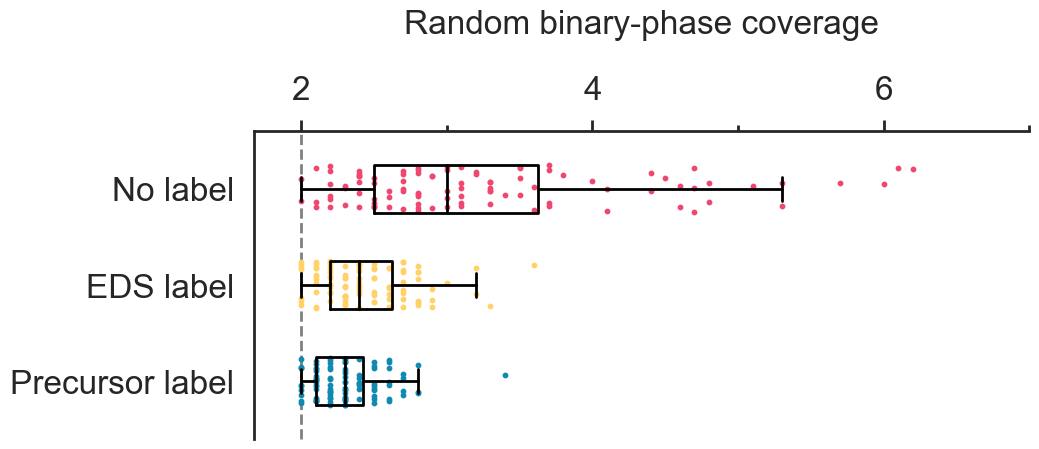

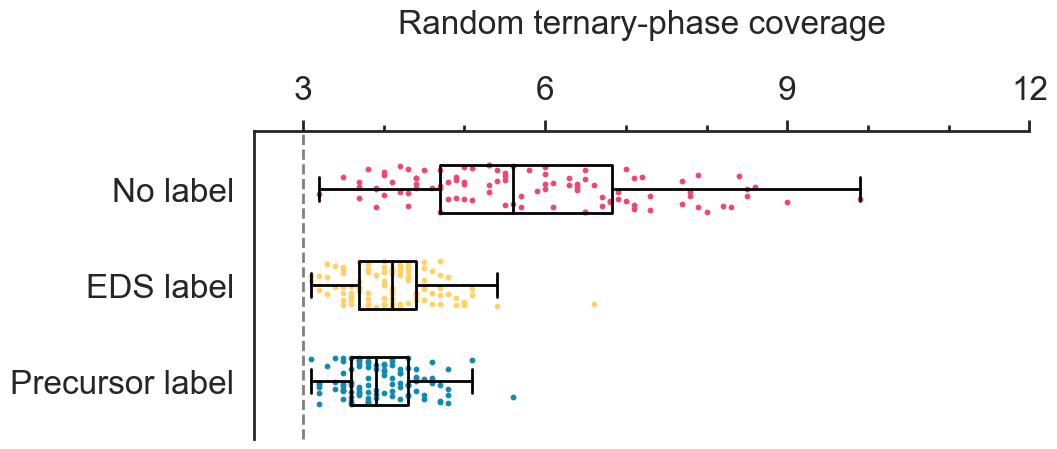

In [22]:
load_plt_setting()
stat_n = 10
prompt_type_list = ['full','eds','none',]

for n_multilabel in ['2','3']:
    fig, ax = plt.subplots(figsize=(10, 4))
    x_dic = {}
    for i, (prompt_type,c) in enumerate(zip(prompt_type_list,["#118ab2","#ffd166","#ef476f"])):
        x_dic[prompt_type] = {}
        x_dic[prompt_type]['raw'] = []
        y_pred_full = np.array(full_result[prompt_type][n_multilabel]['outputs'])
        y_true_full = np.array(full_result[prompt_type][n_multilabel]['labels'])
        for j in range(y_pred_full.shape[0]):
            x_dic[prompt_type]['raw'].append(coverage_error(y_true_full[j:j+1], y_pred_full[j:j+1]))
        x_dic[prompt_type]['stat'] = [np.mean(x_dic[prompt_type]['raw'][i:i+stat_n]) for i in range(0,len(x_dic[prompt_type]['raw']),stat_n)]
        y = np.random.uniform(i-0.25+1, i+0.25+1, size=len(x_dic[prompt_type]['stat']))
        ax.scatter(x_dic[prompt_type]['stat'], y, c=c, alpha=1, s=10)
        
    print(mannwhitneyu(x_dic[prompt_type_list[2]]['stat'],x_dic[prompt_type_list[1]]['stat']))
    print(mannwhitneyu(x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[0]]['stat']))
        
    boxplot = ax.boxplot([x_dic[prompt_type_list[0]]['stat'],x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[2]]['stat']], 
                         notch=False, vert=False, widths=0.5, sym='', 
                         boxprops=dict(linewidth=2,c='black'), medianprops=dict(linewidth=2,c='black'),
                         whiskerprops=dict(linewidth=2,c='black'), capprops=dict(linewidth=2,c='black'))

    ax.set_ylim([0.4,3.6])
    ax.axes.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    ax.axes.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=False, steps=[1, 2, 3, 5, 10]))
    
    ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, length=8, width=2, pad=10, labelsize=24)
    ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, direction='out', length=4, width=2, pad=10)
    ax.tick_params(axis='y', labelsize=24)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(['','Precursor label ','EDS label ','No label '])
    plt.ylabel('', labelpad=20, fontsize=28)
    ax.xaxis.set_label_position('top')
    ax.axvline(x=int(n_multilabel), clip_on=False, color='grey', linestyle='--', linewidth=2, zorder=-10)
    
    if n_multilabel == '2':
        ax.set_xlim([1.68,7])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        plt.xlabel(r'Random binary-phase coverage'.format(n_multilabel), labelpad=30, fontsize=24)

    elif n_multilabel == '3':
        ax.set_xlim([2.4,12])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(3))
        plt.xlabel(r'Random ternary-phase coverage'.format(n_multilabel), labelpad=30, fontsize=24)

        
    plt.savefig(os.path.join(folder, 'models', model_folder, 'Top-K_{}.png'.format(n_multilabel)), bbox_inches='tight',format='png', dpi=300, transparent=True)
    np.savetxt(os.path.join(folder, 'models', model_folder, 'Top-K_{}.csv'.format(n_multilabel)),  
               np.swapaxes(np.asarray([x_dic[prompt_type_list[0]]['stat'],x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[2]]['stat']]),0,1), 
               header='Precursor label / EDS label / No label',)

# 4 Attention

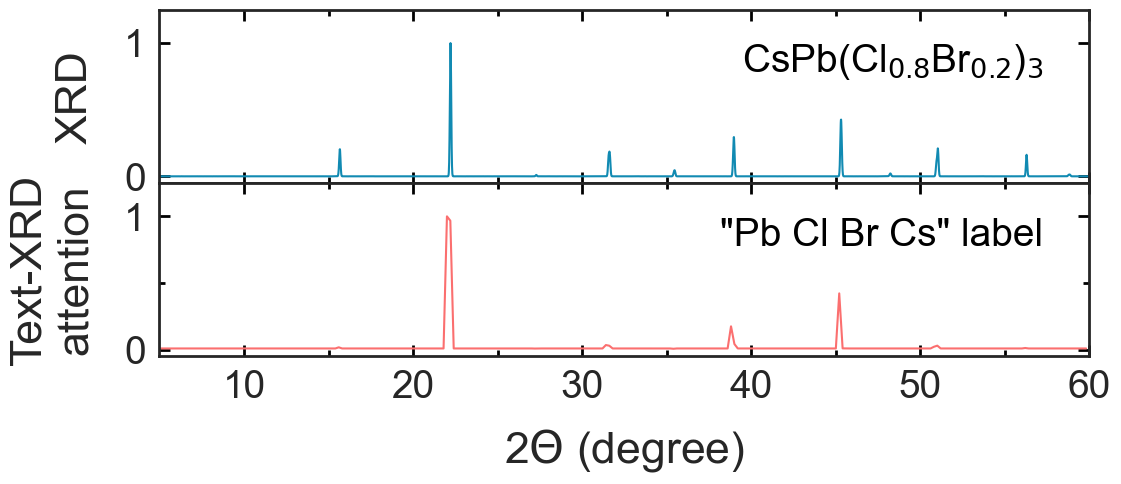

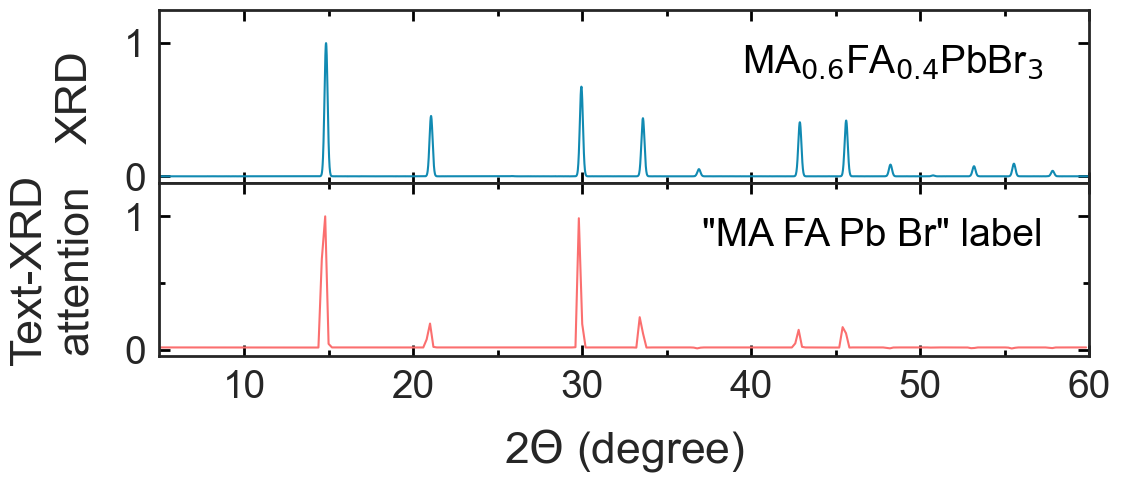

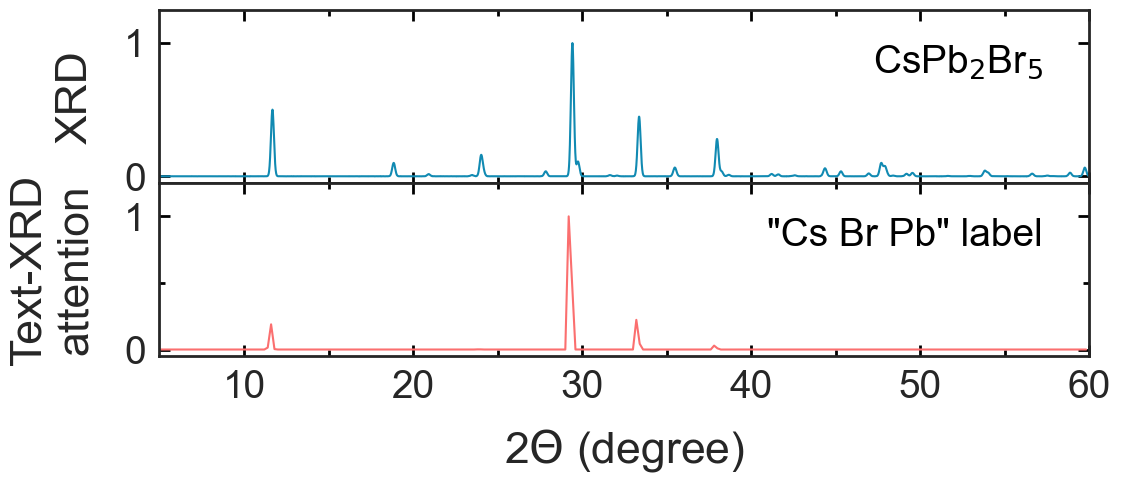

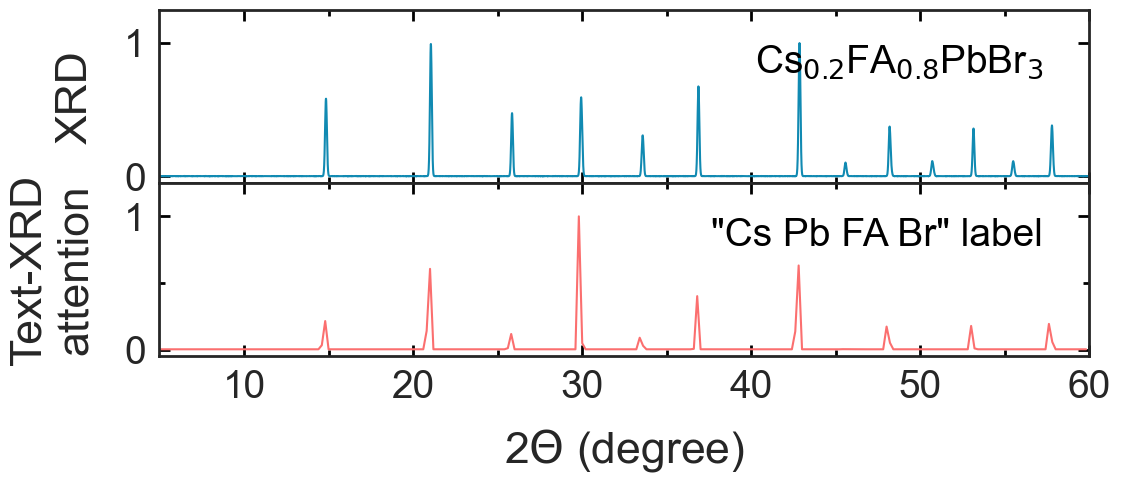

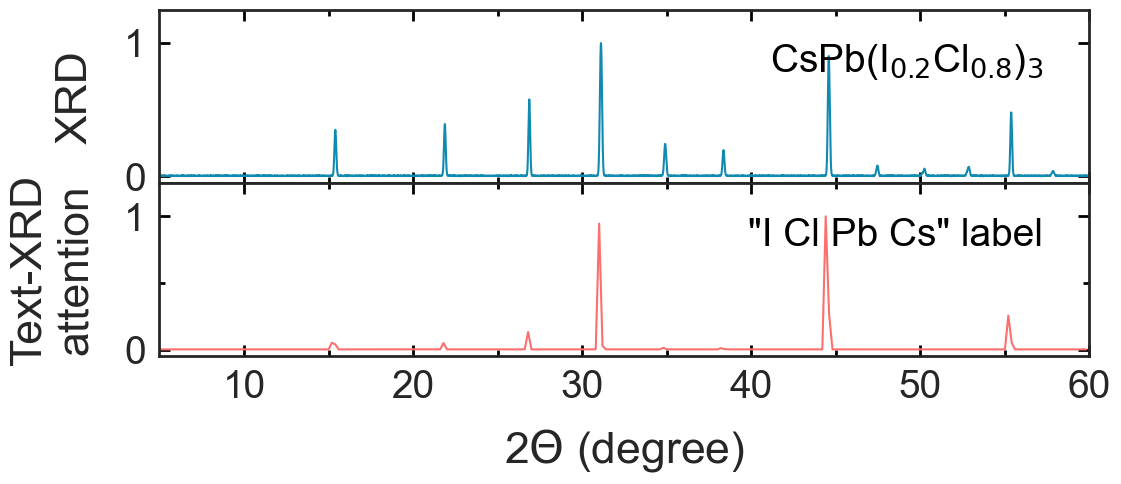

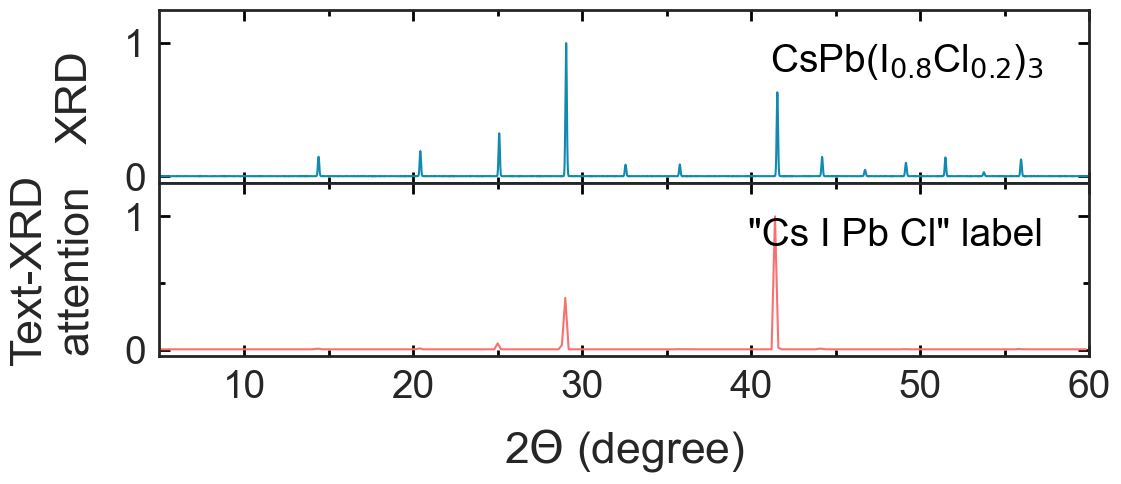

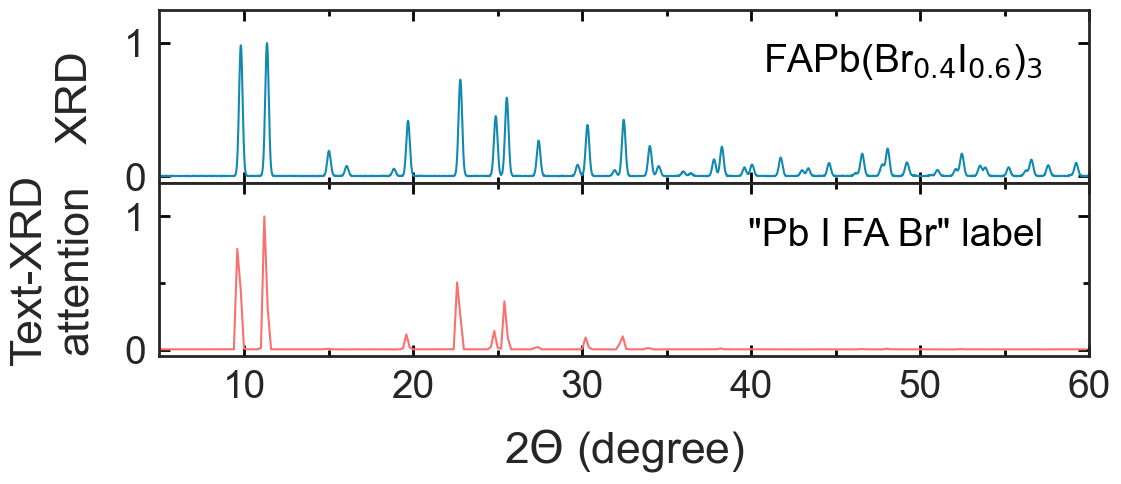

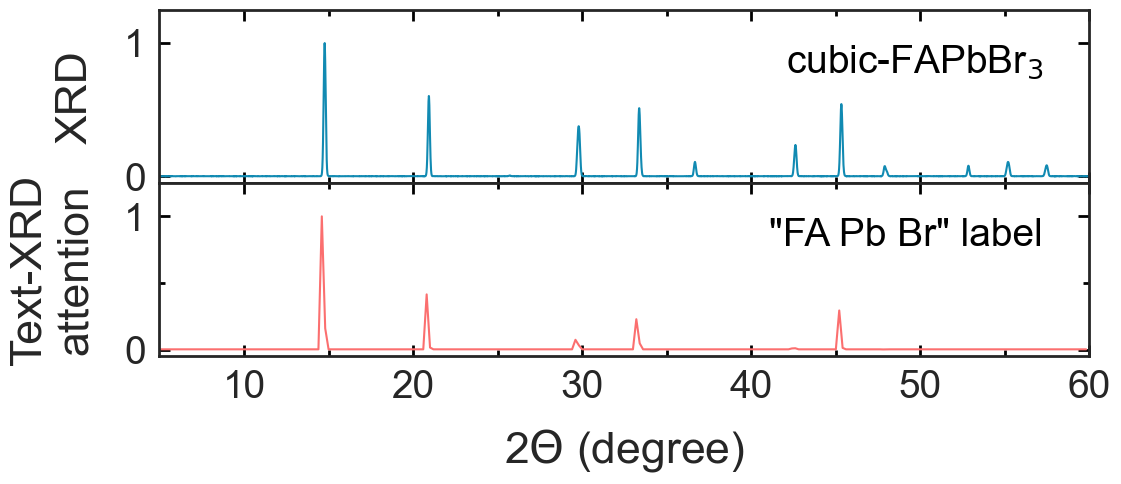

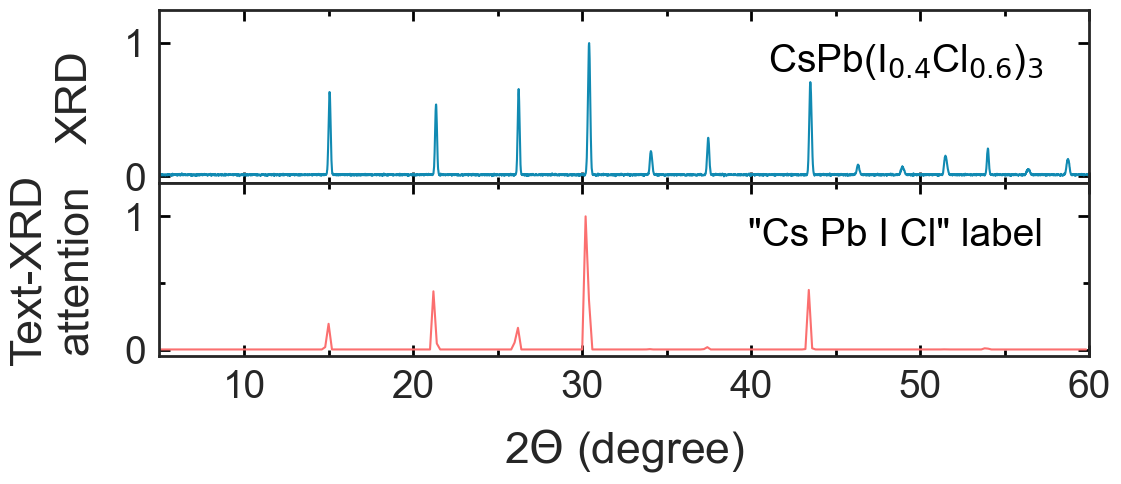

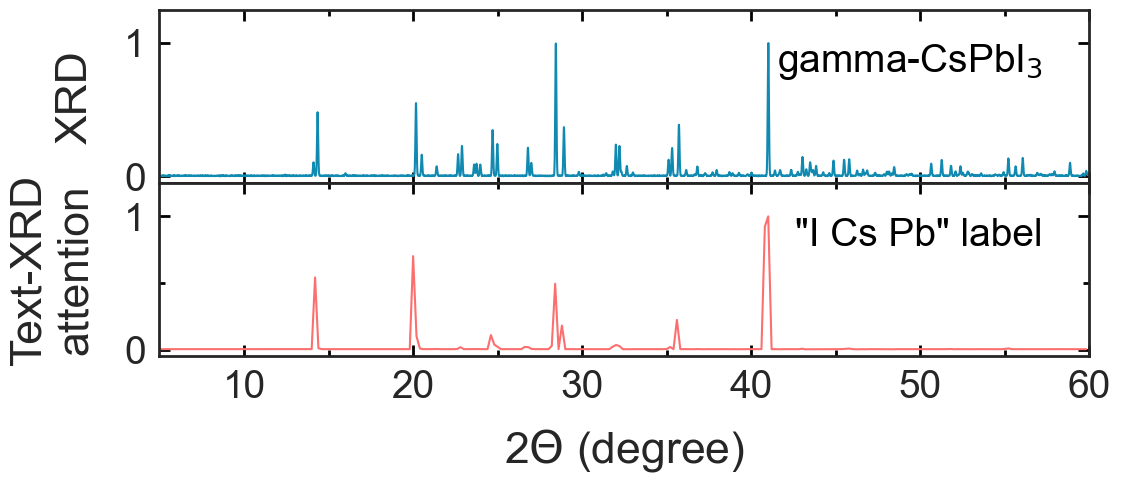

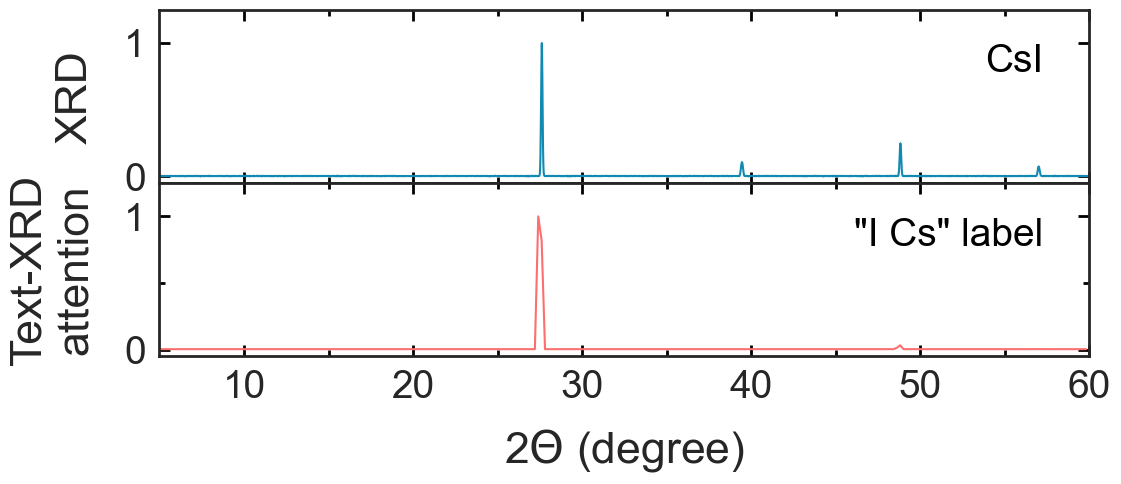

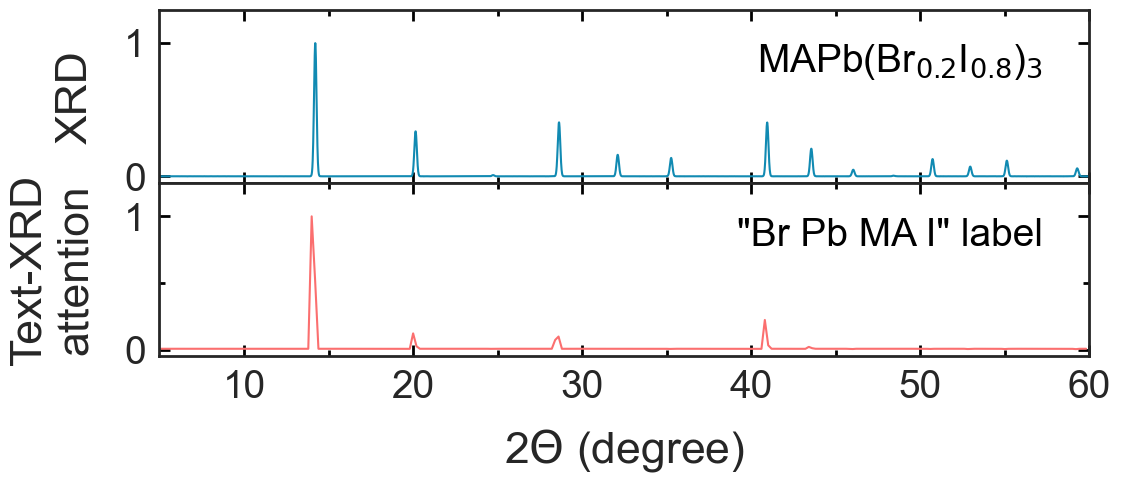

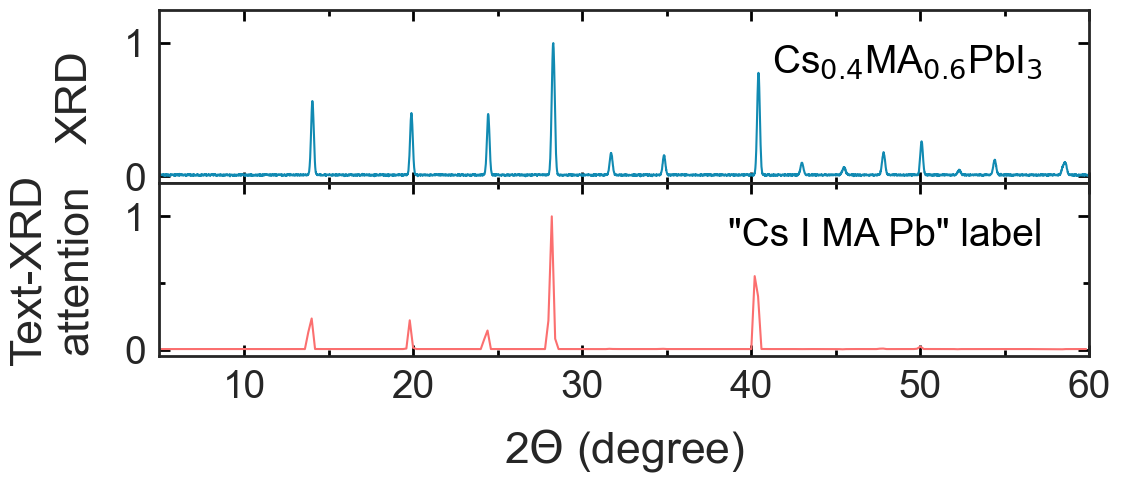

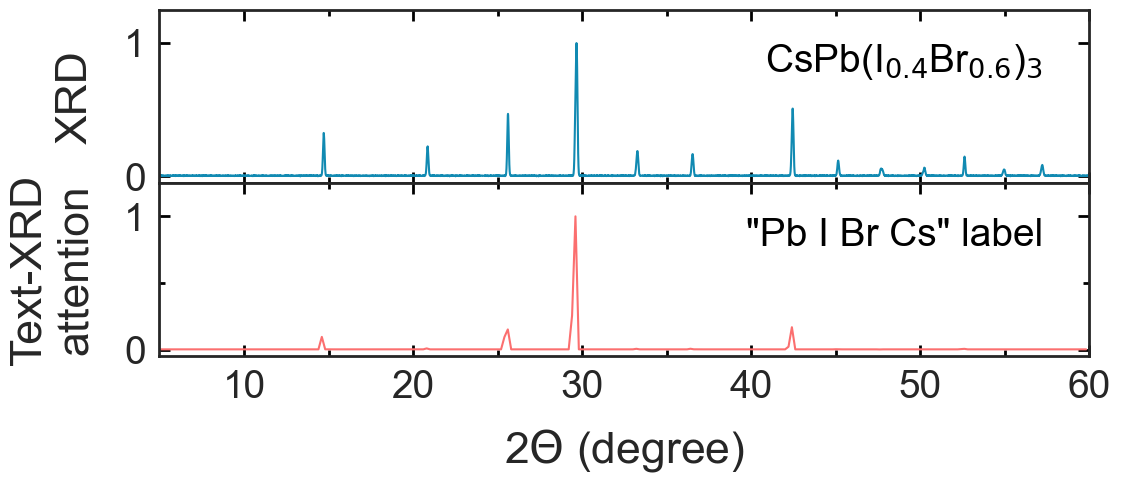

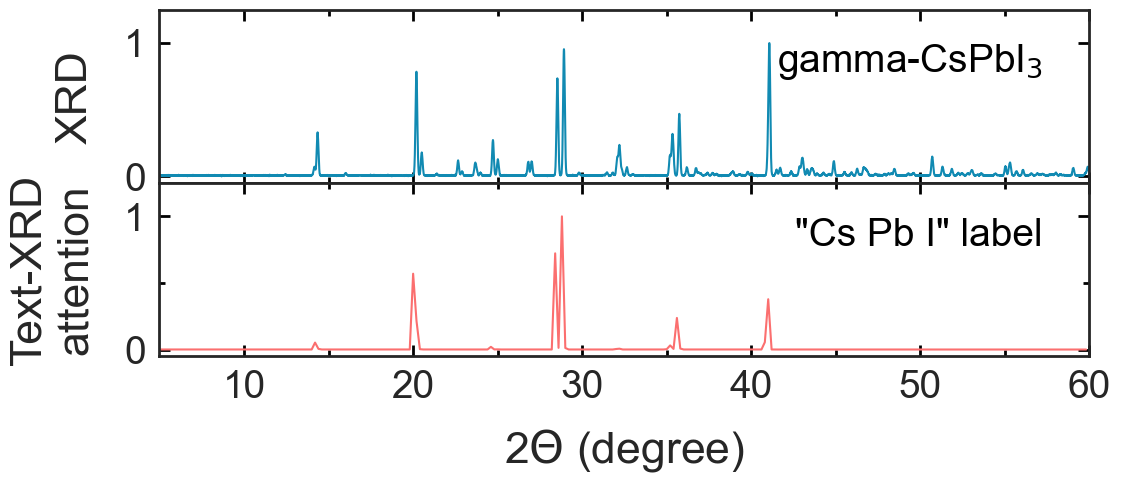

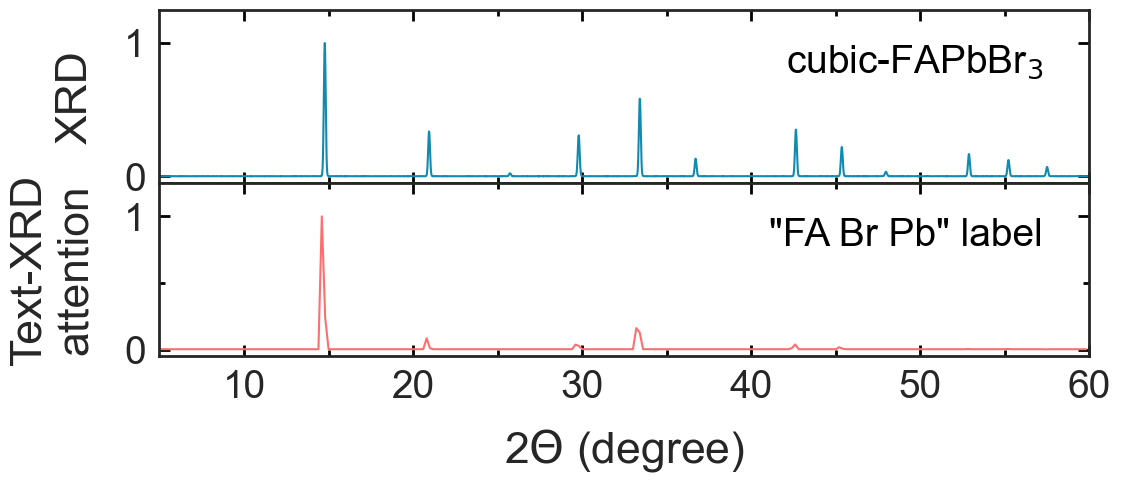

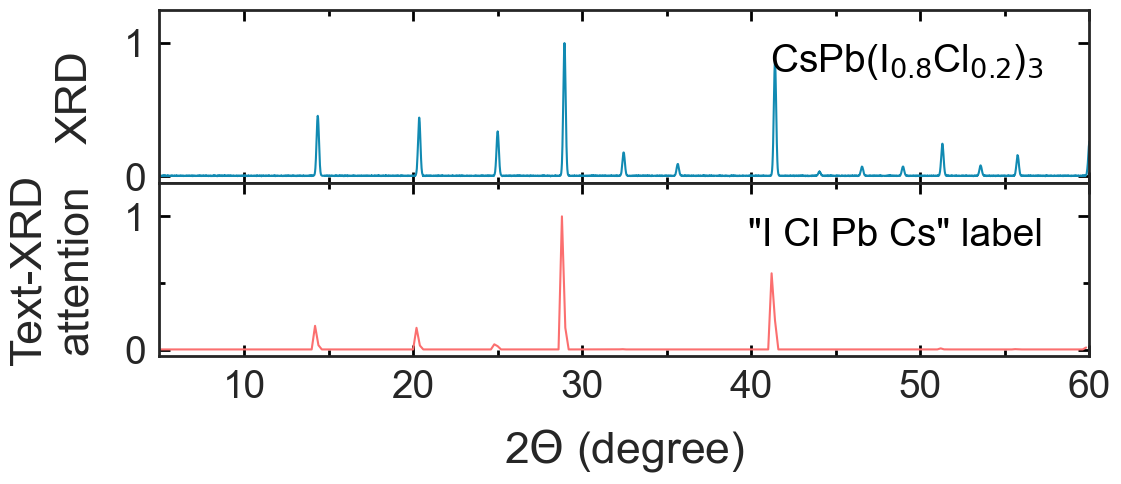

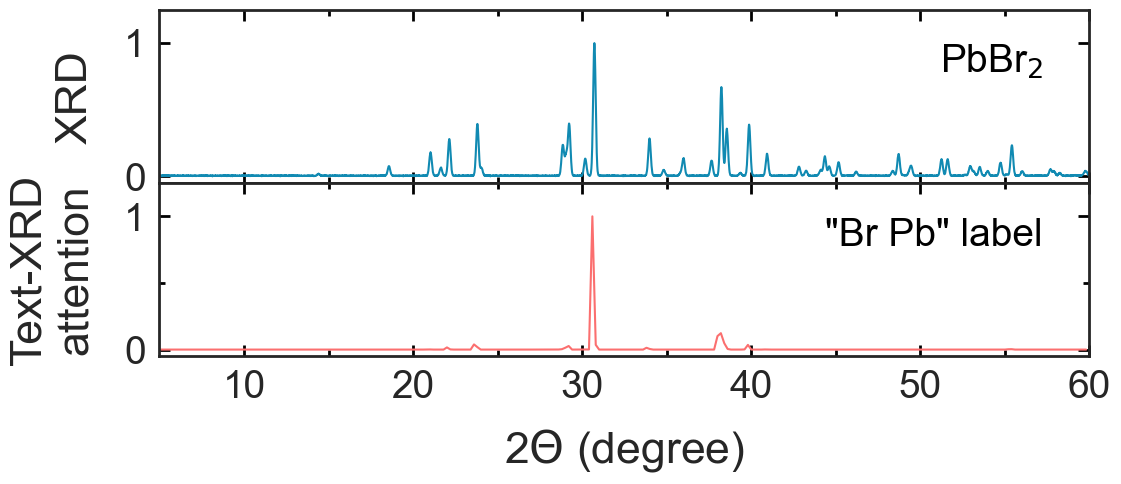

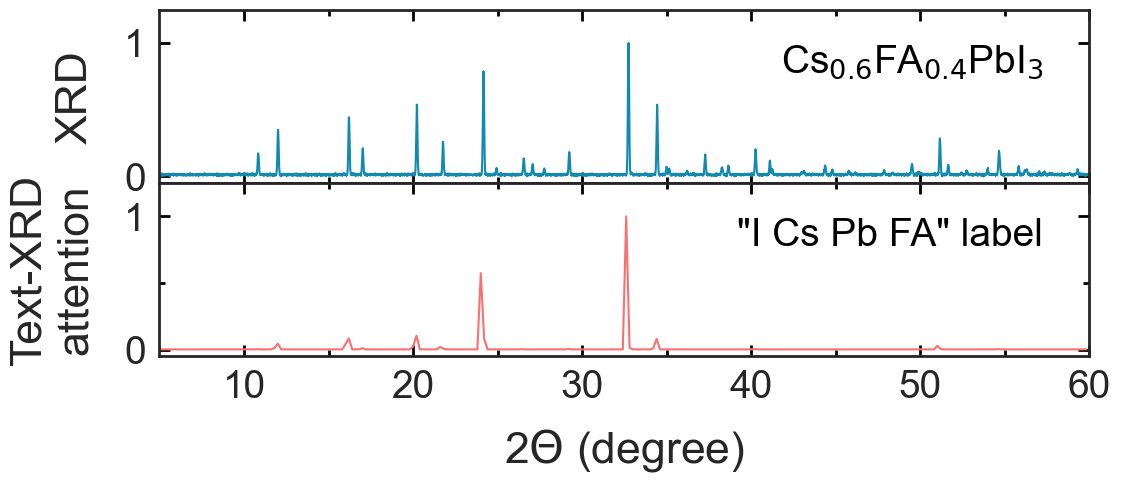

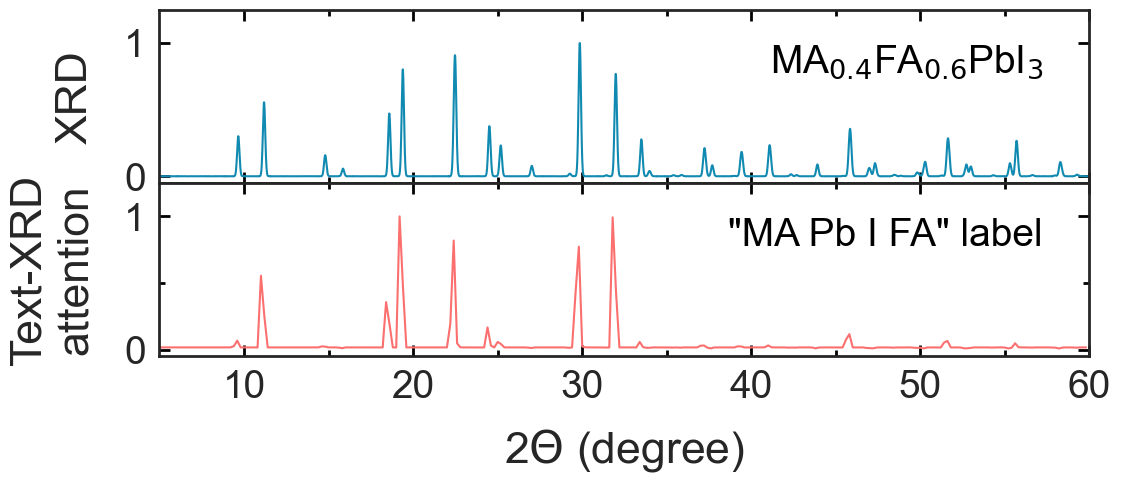

In [312]:
for i in range(20):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))

    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,1:len(inputs['input_ids'][0])-1,len(inputs['input_ids'][0]):]

    load_plt_setting()

    fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[1, 1]),figsize=(12, 4.5))

    ax0.plot(np.arange(5.00, 60.01, 0.01)[:-1], Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=1, steps=[1, 2, 5, 10]))
#     ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.25])
    ax0.set_ylabel(f'XRD', labelpad=20, fontsize=32)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.sum(Y, axis=0)/np.max(np.sum(Y, axis=0)), color=colors.to_rgba('#fb6f6f'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.axes.set_xlim([5,60])
    ax1.axes.set_ylim([-0.05,1.25])

    ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=15, fontsize=32)
    ax1.set_ylabel(f'Text-XRD\nattention', labelpad=20, fontsize=32)
    plt.text(0.95, 0.64, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), fontsize=28, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.95, 0.64, '"'+X_prompts[0]+'" label', fontsize=28, transform=ax1.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models',model_folder,'{}.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


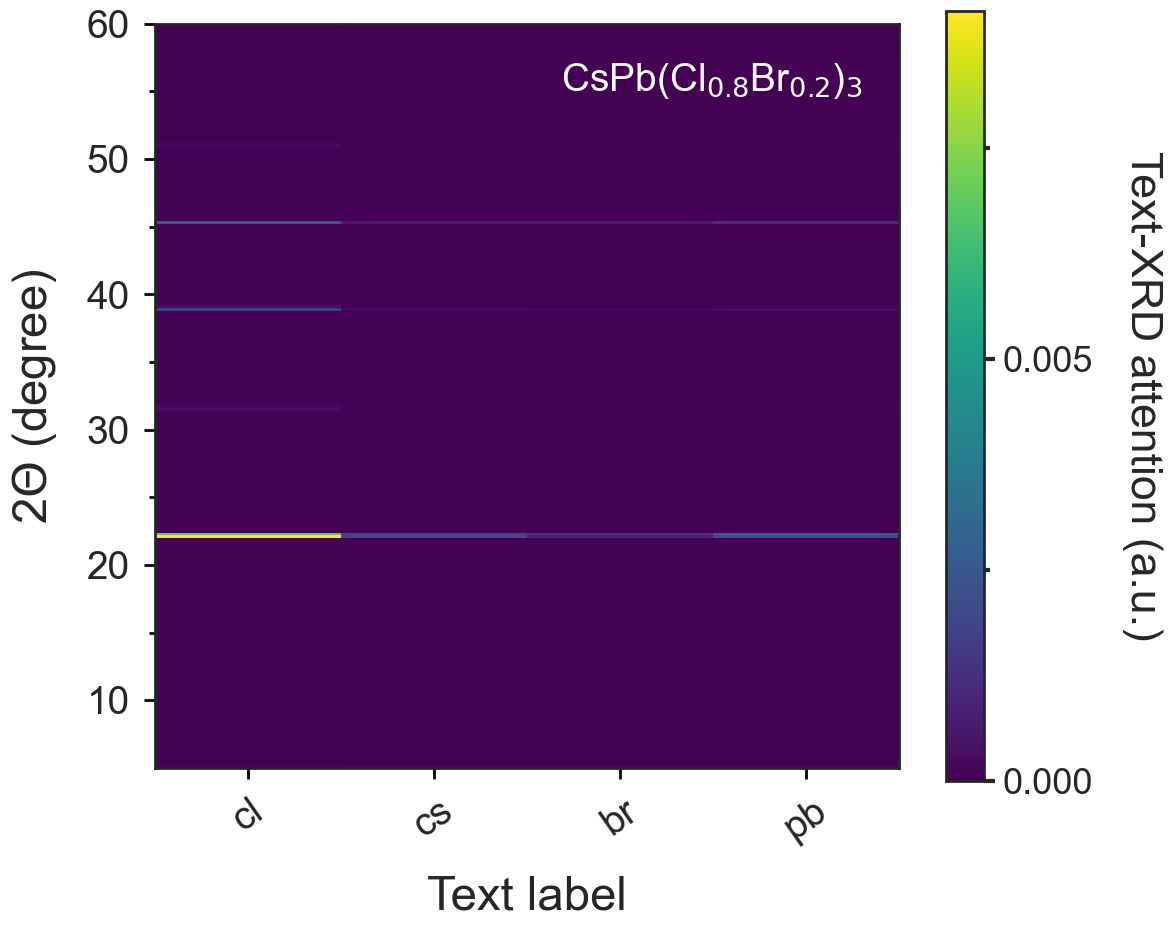

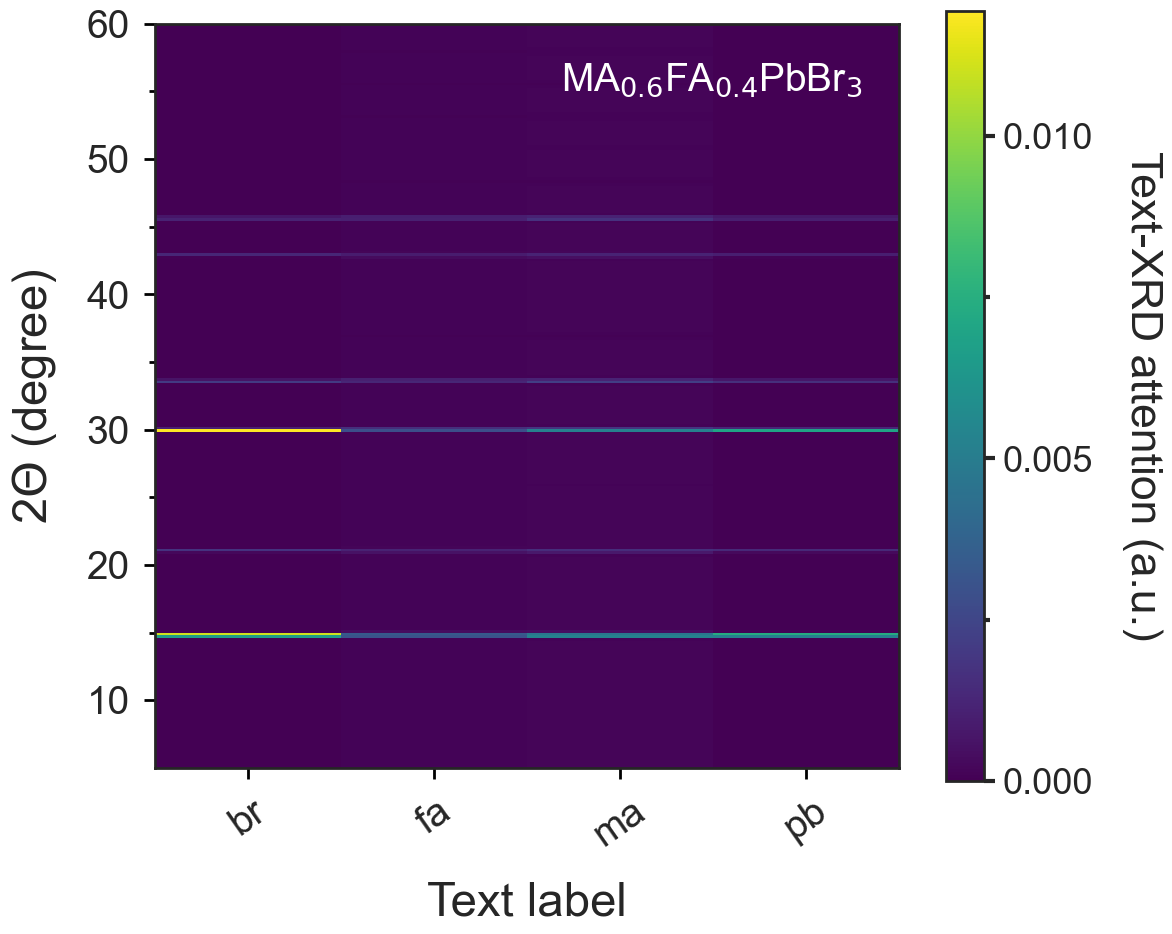

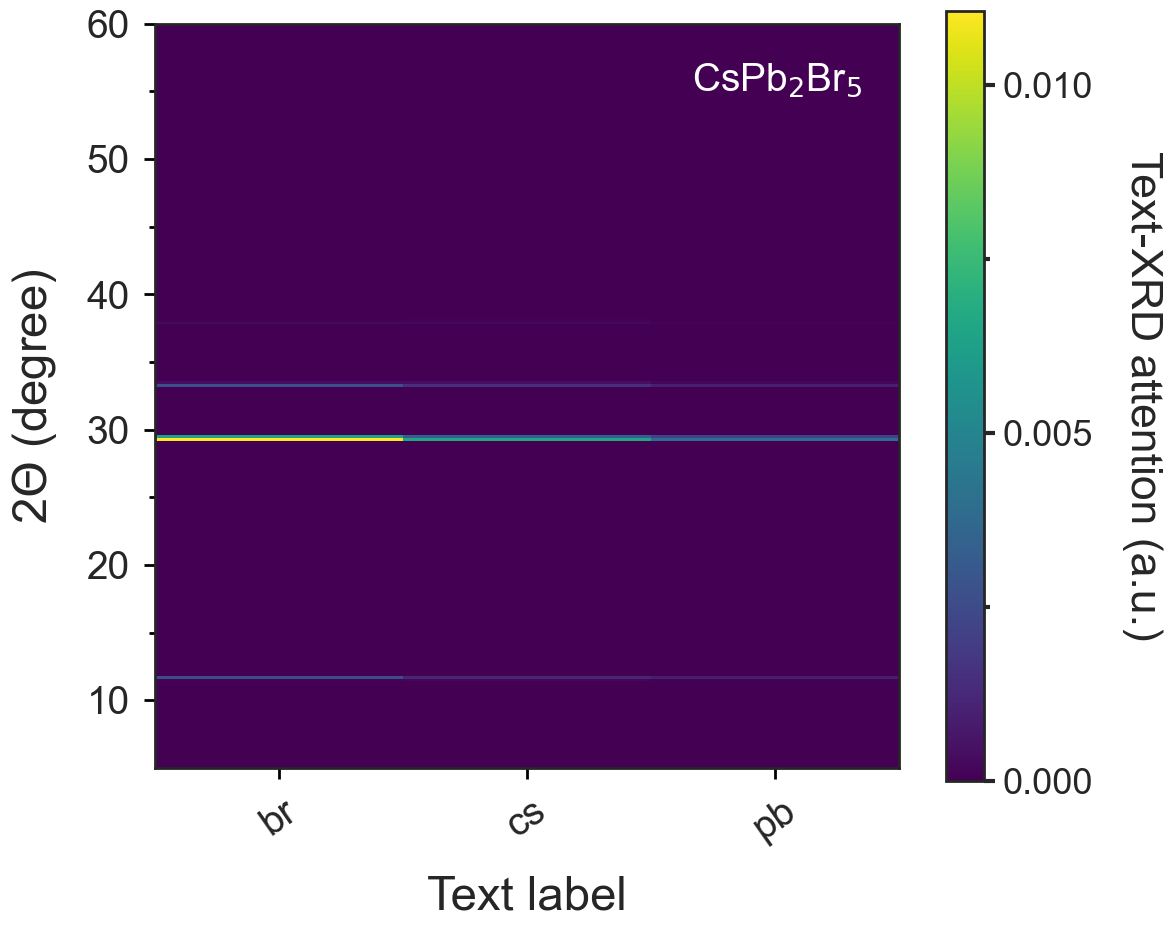

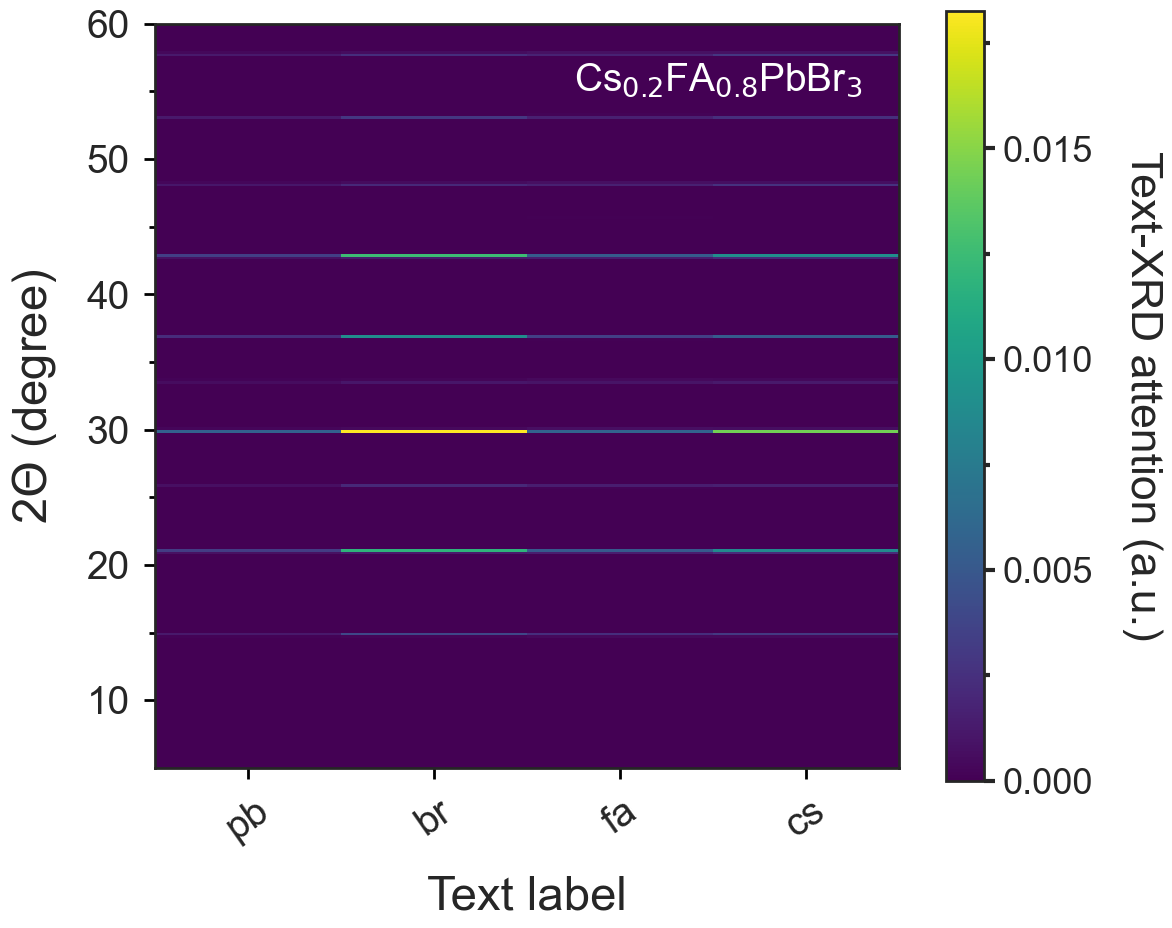

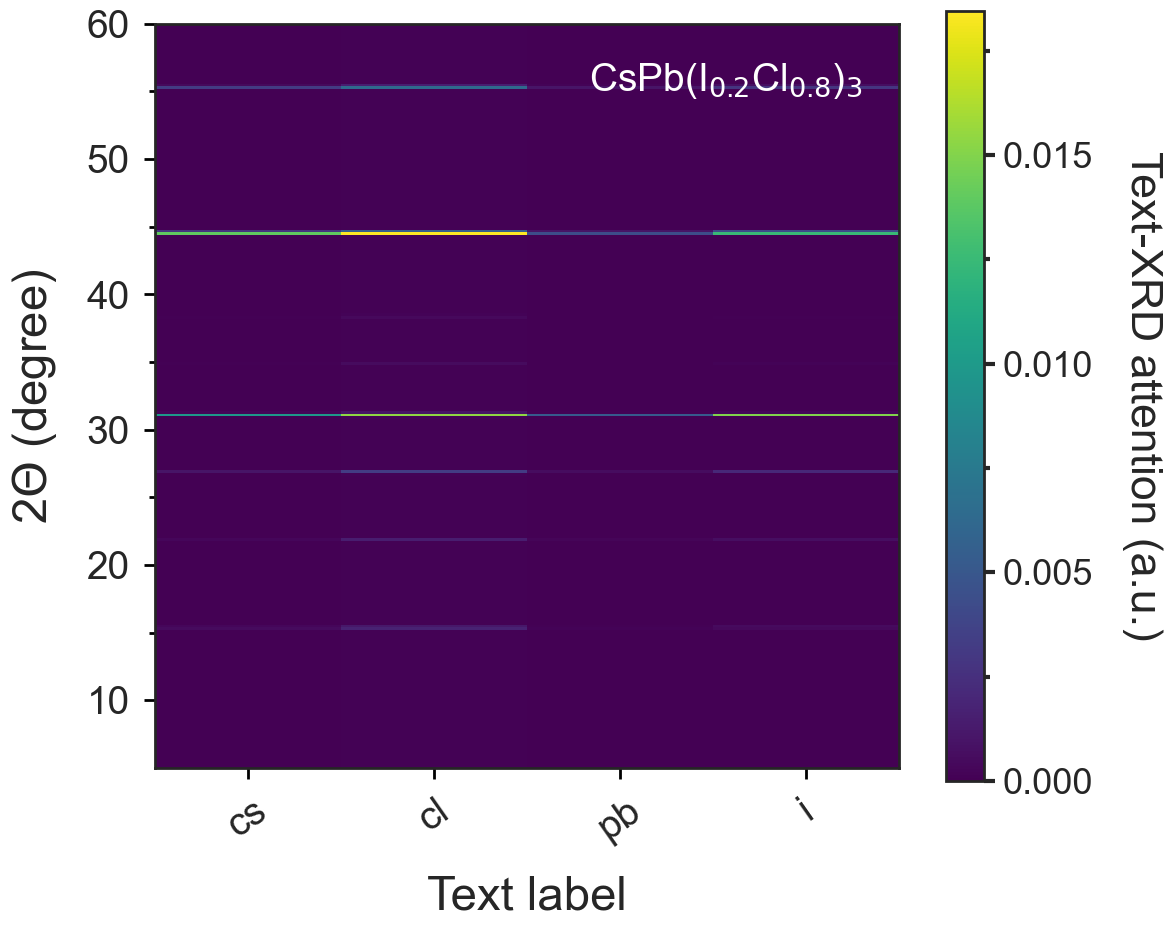

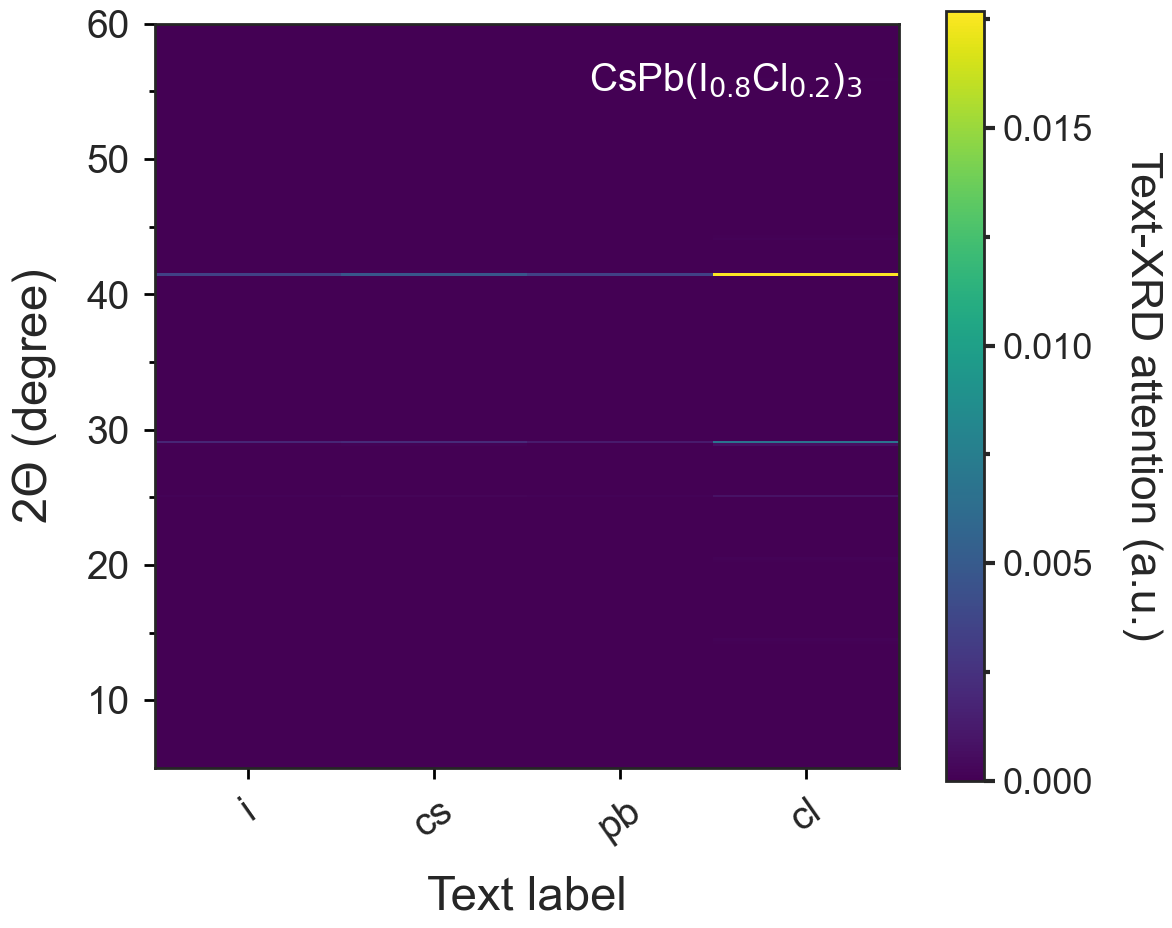

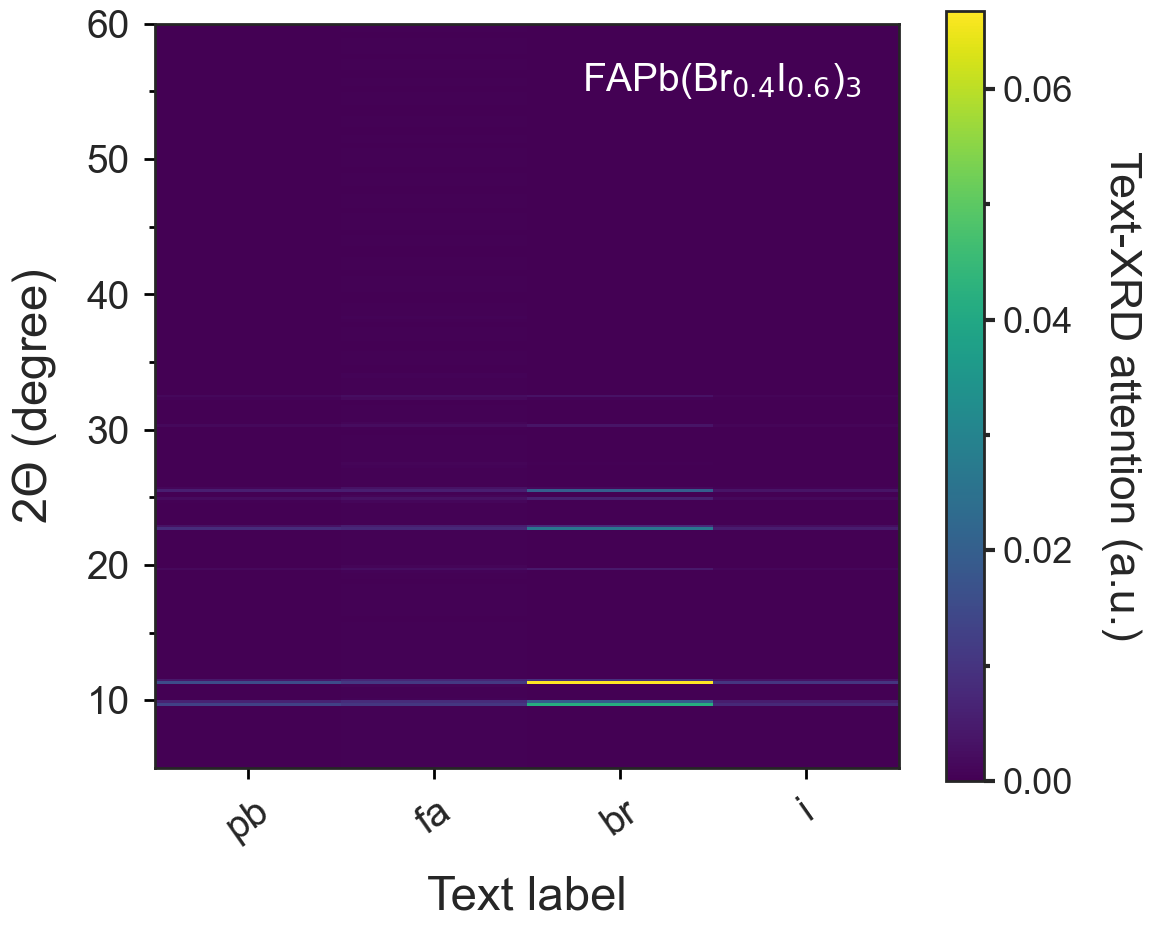

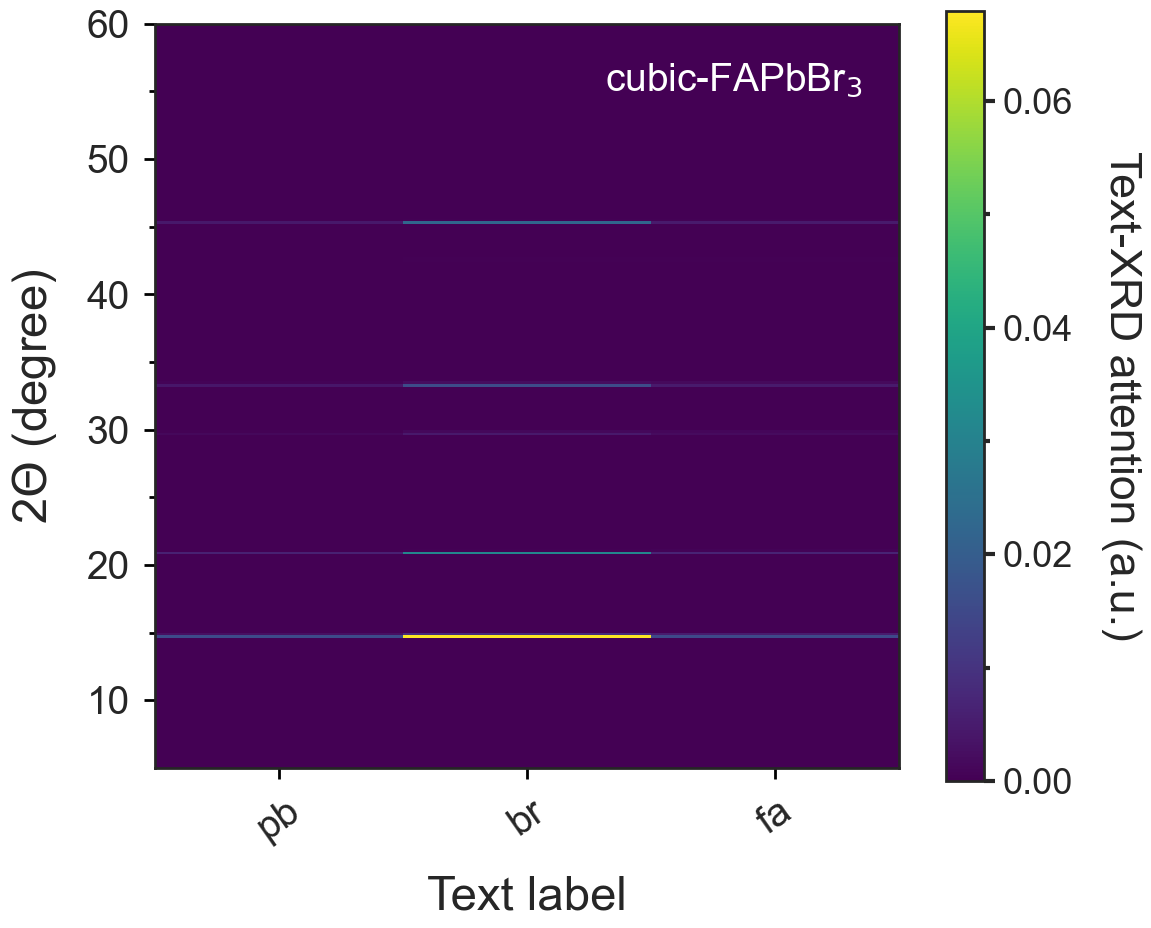

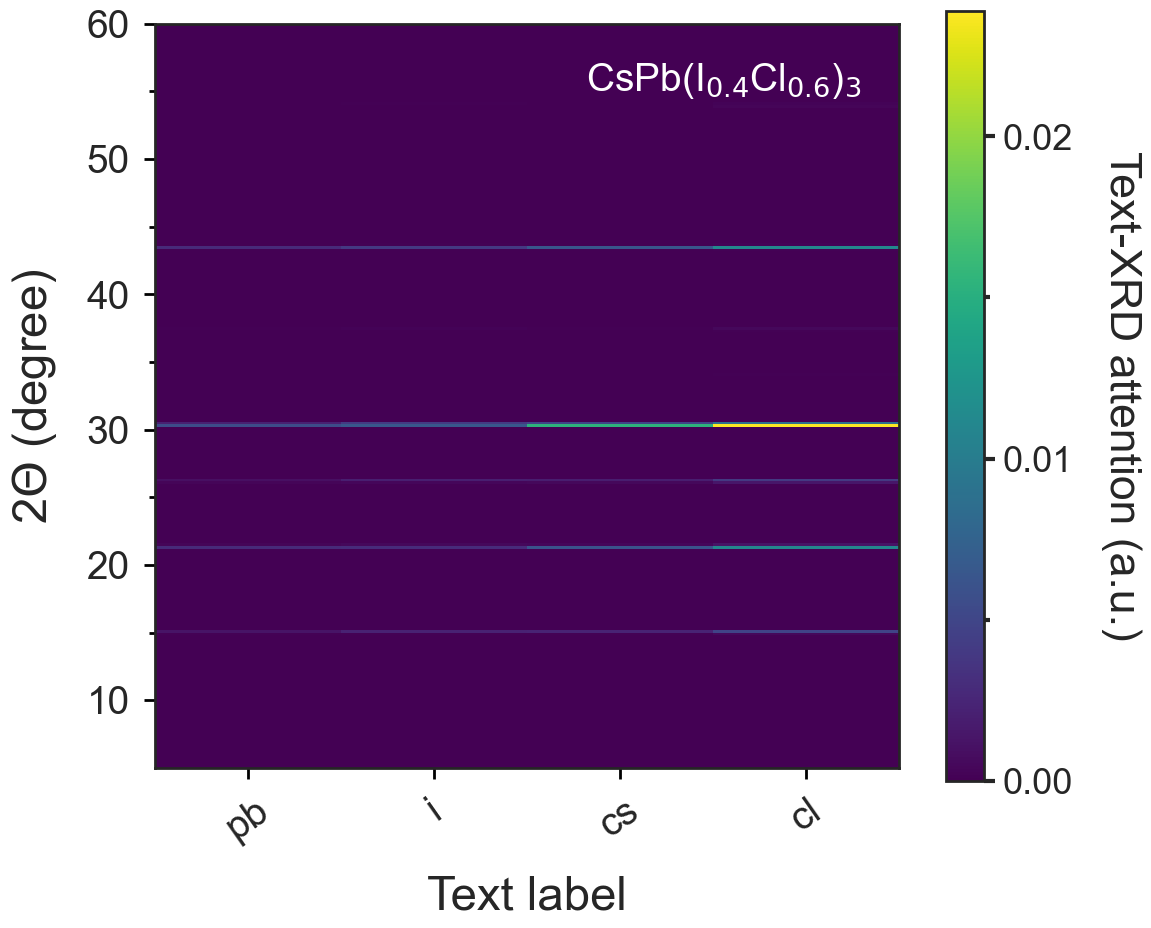

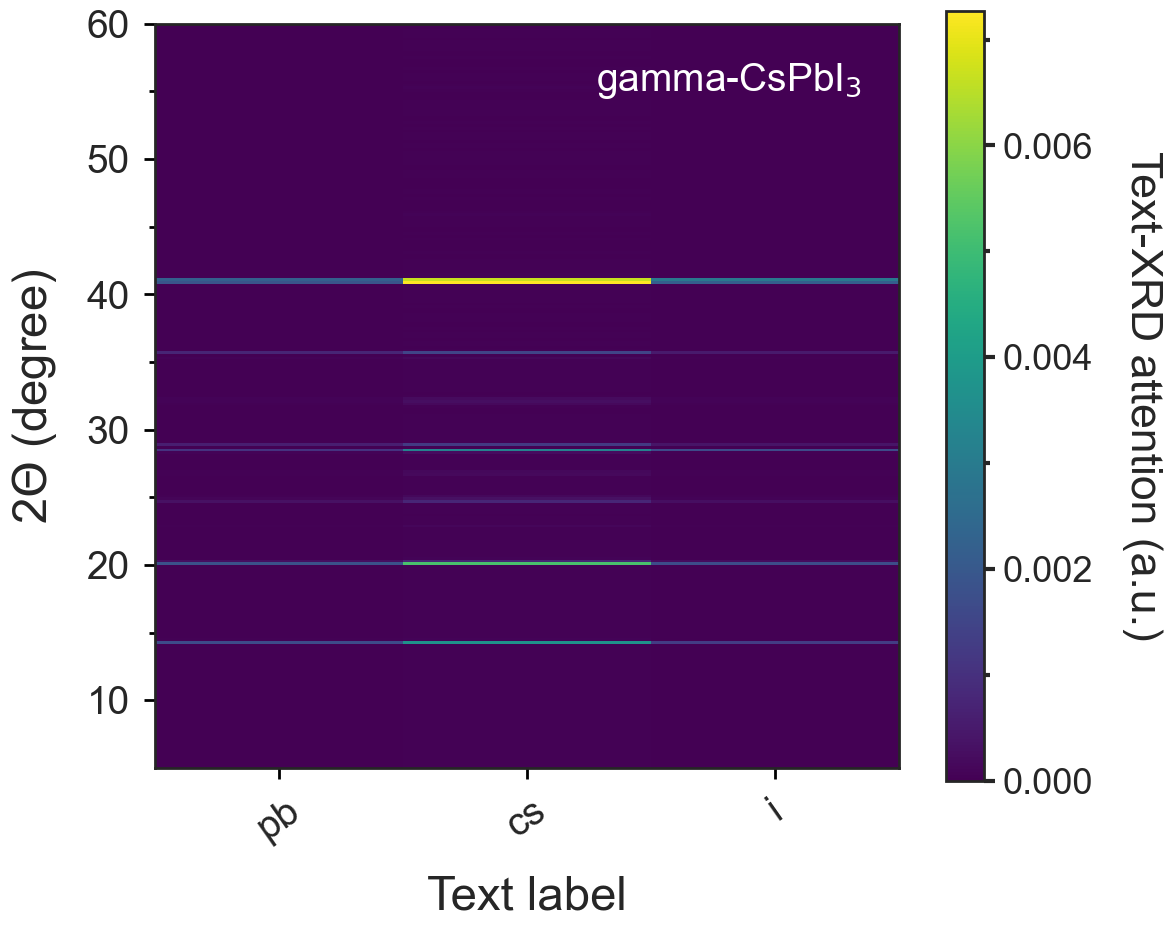

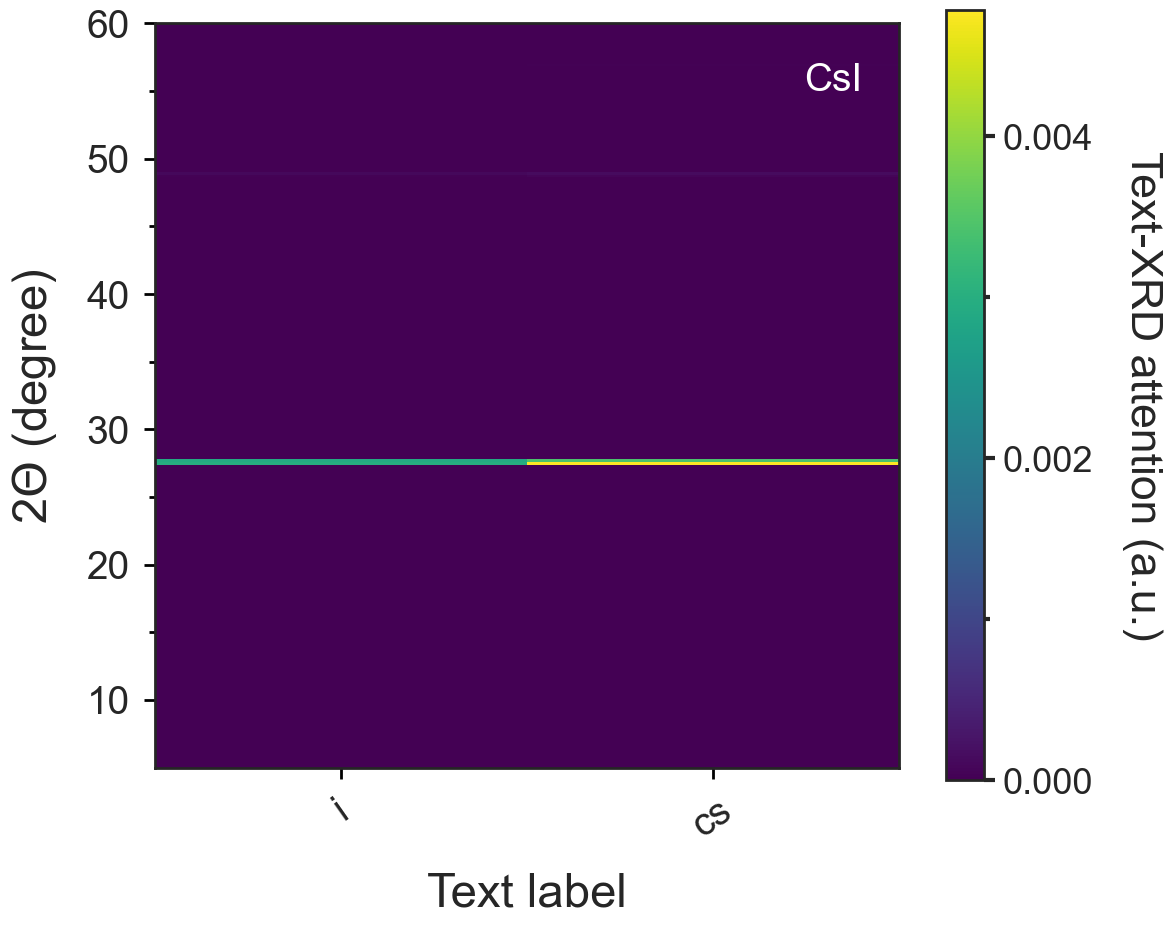

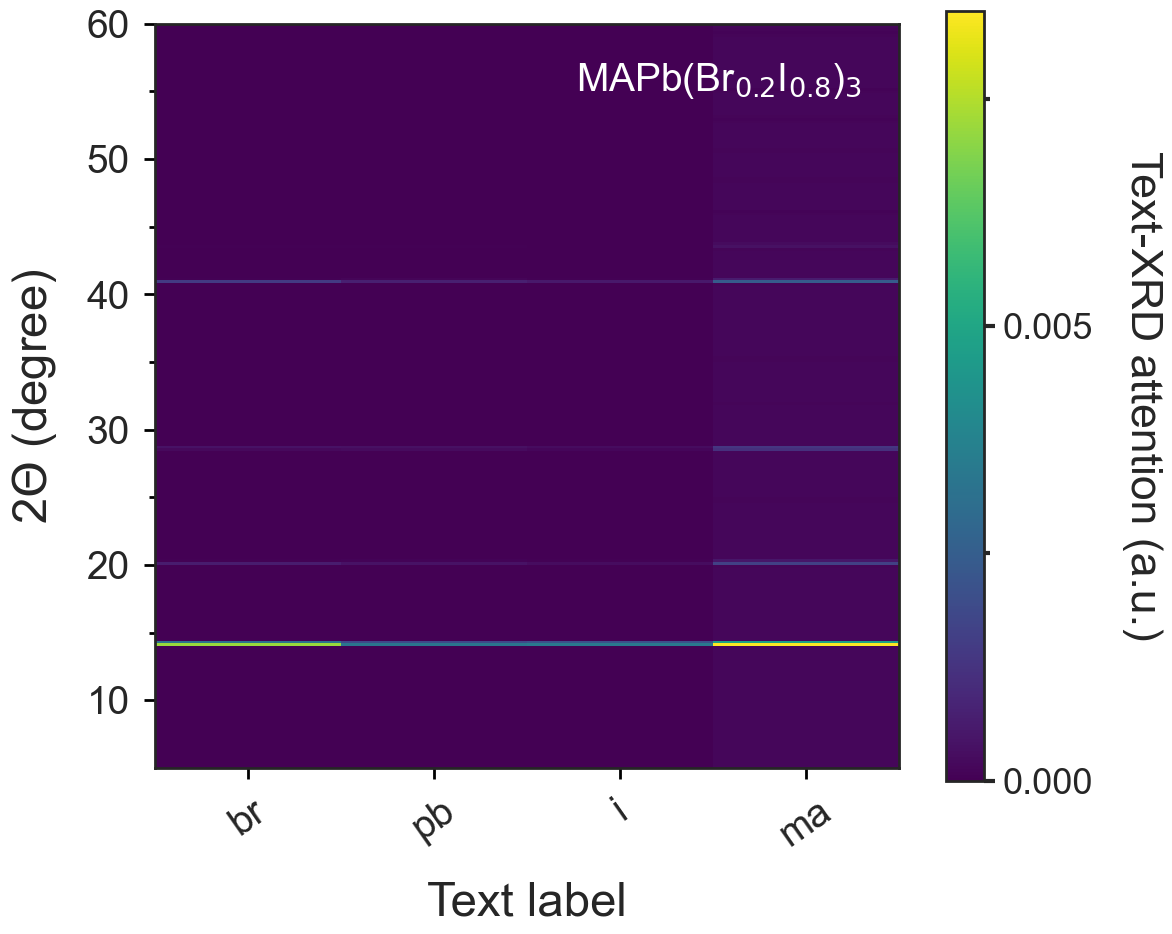

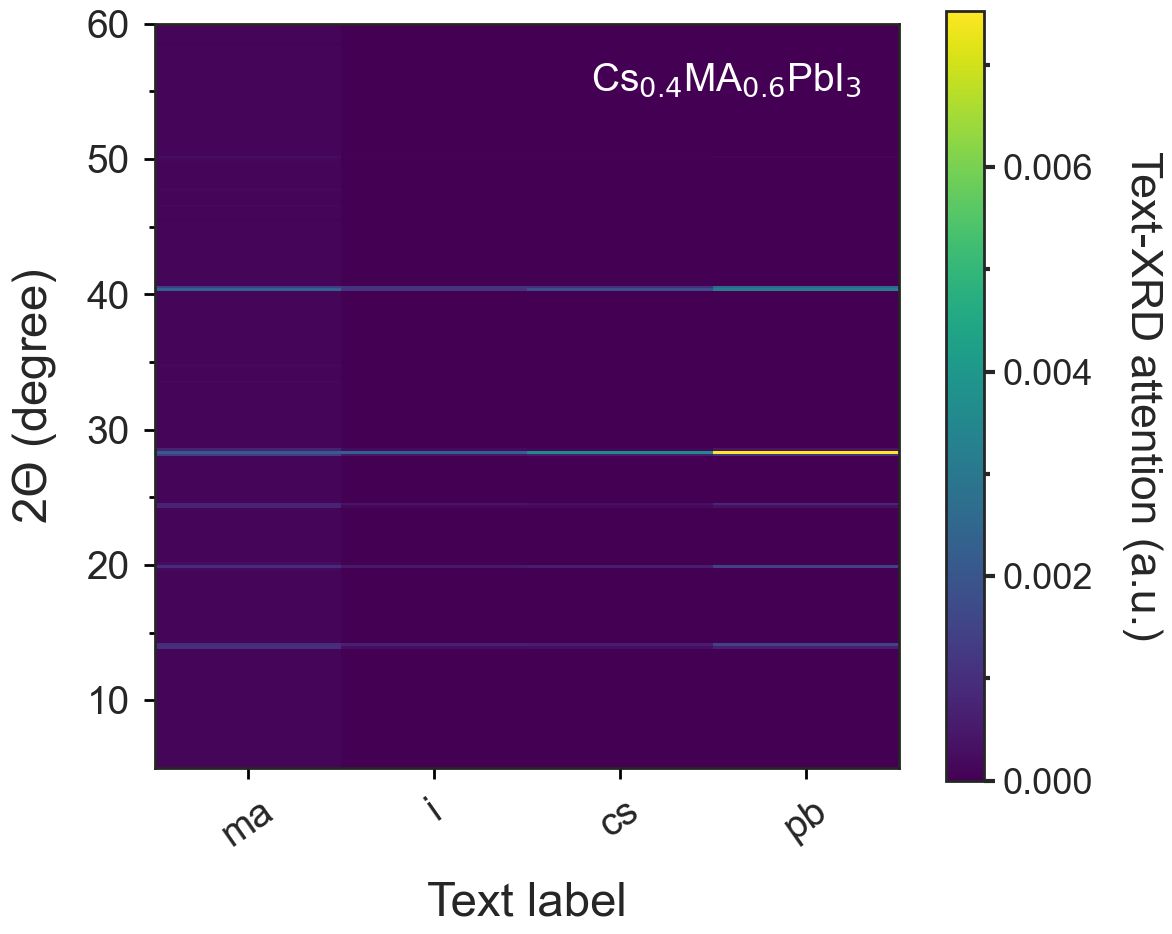

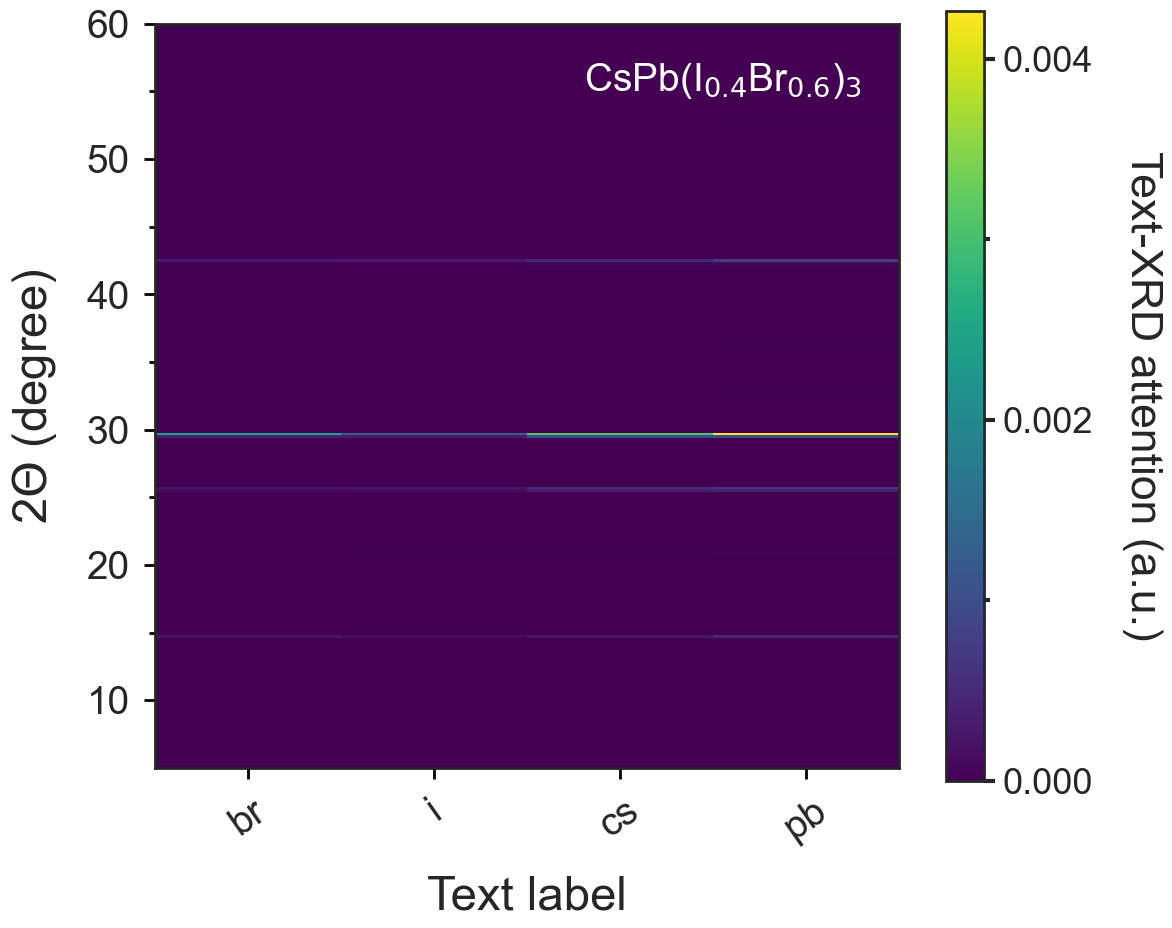

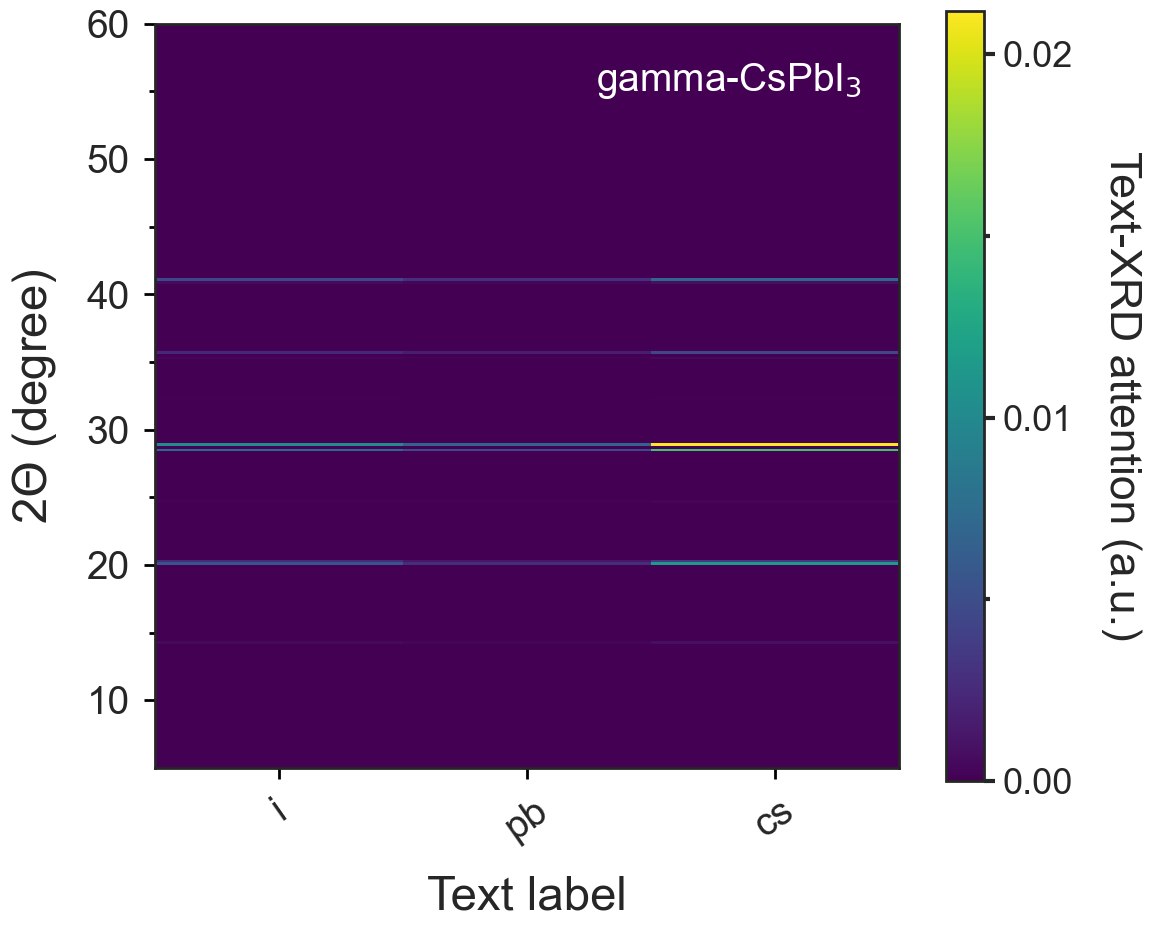

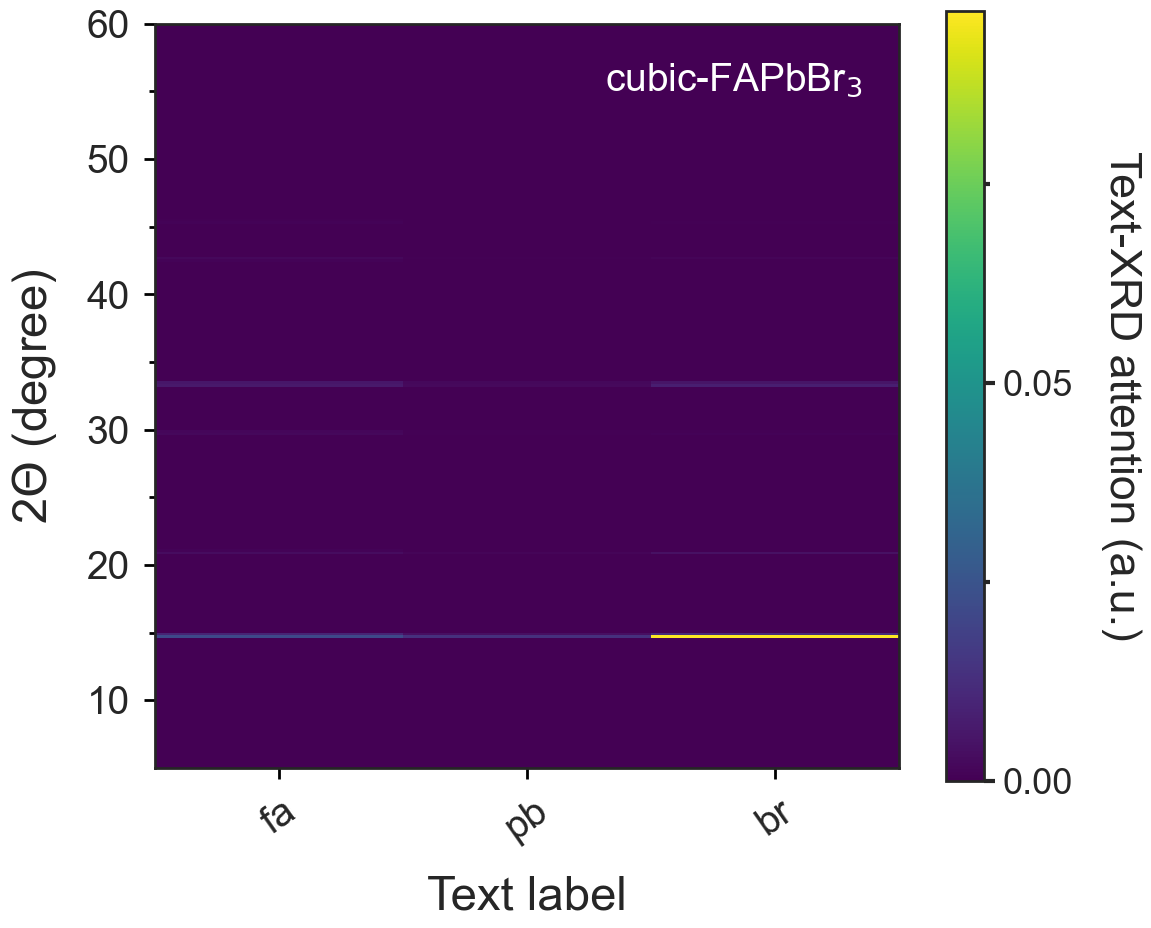

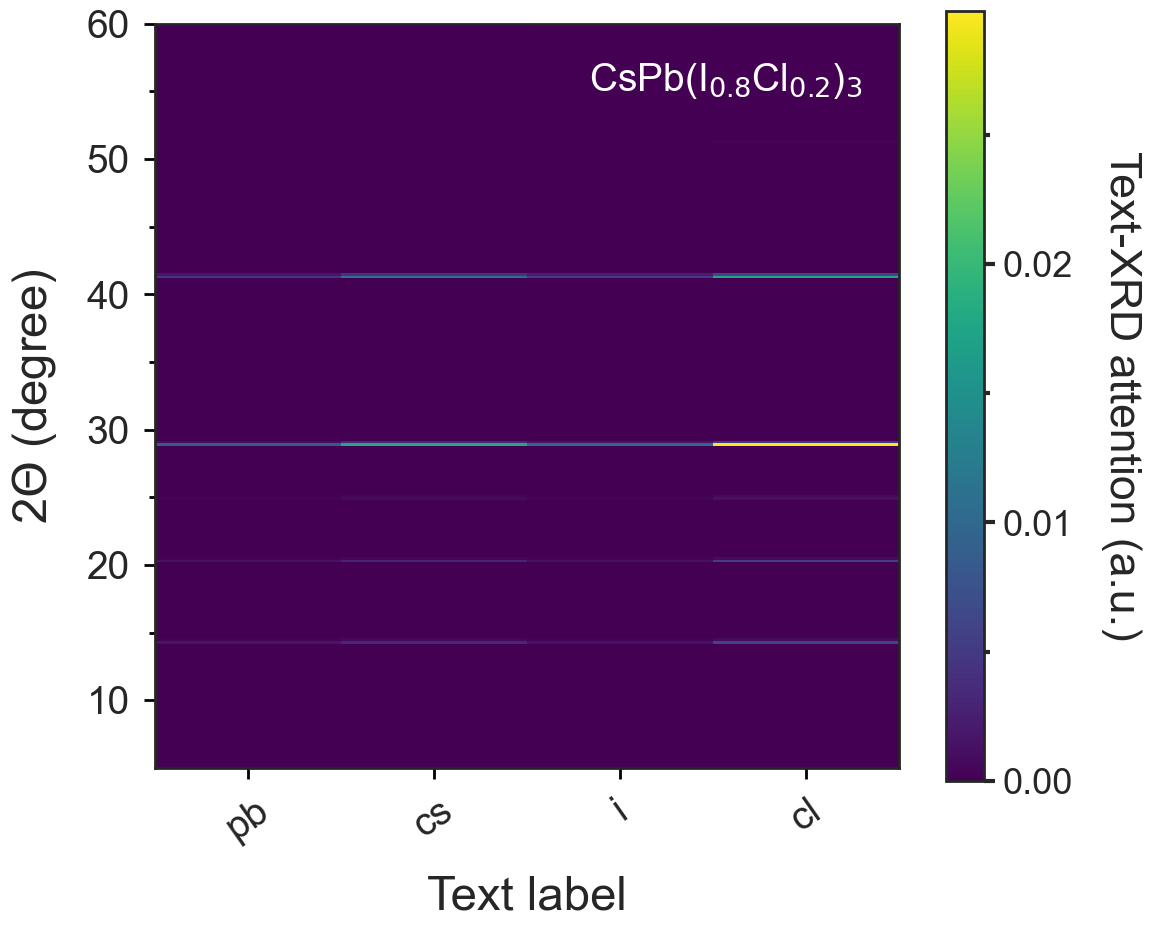

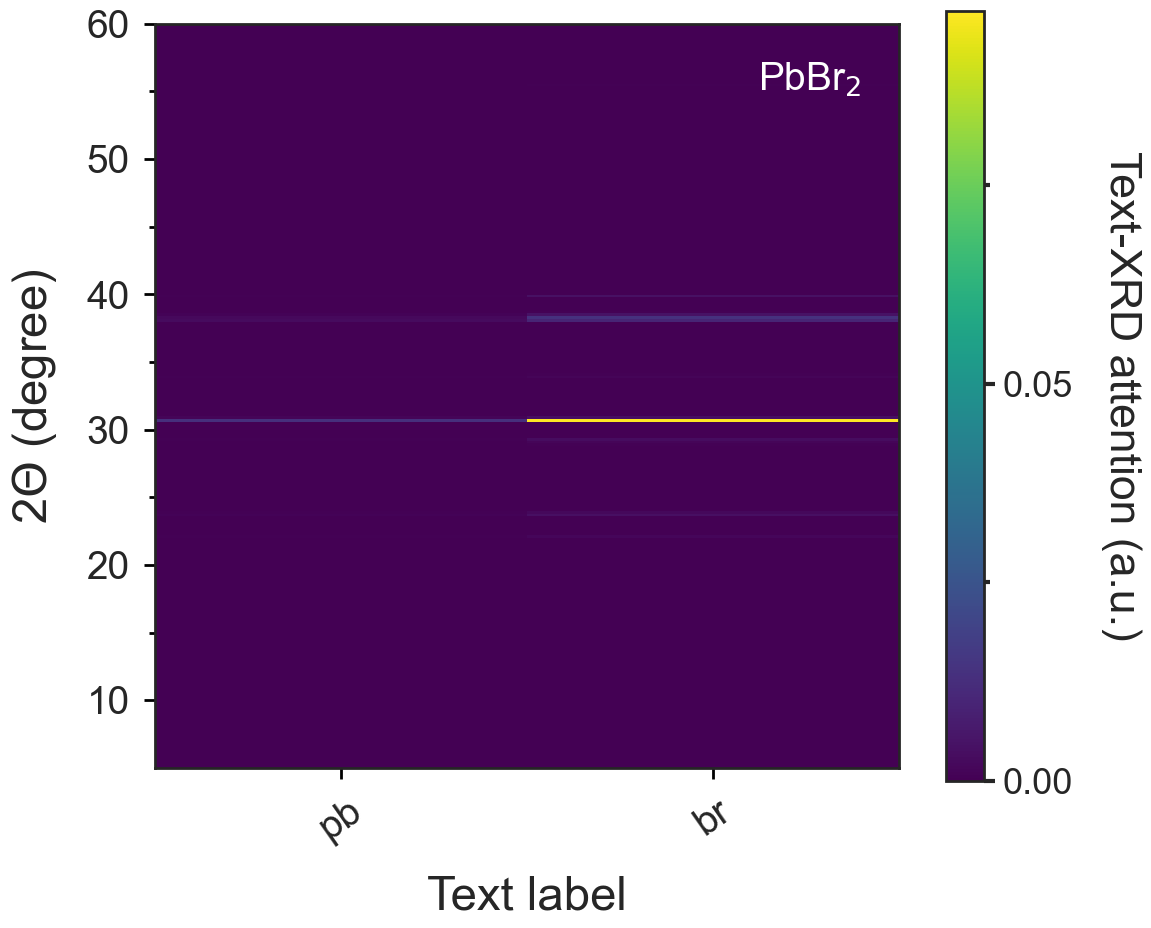

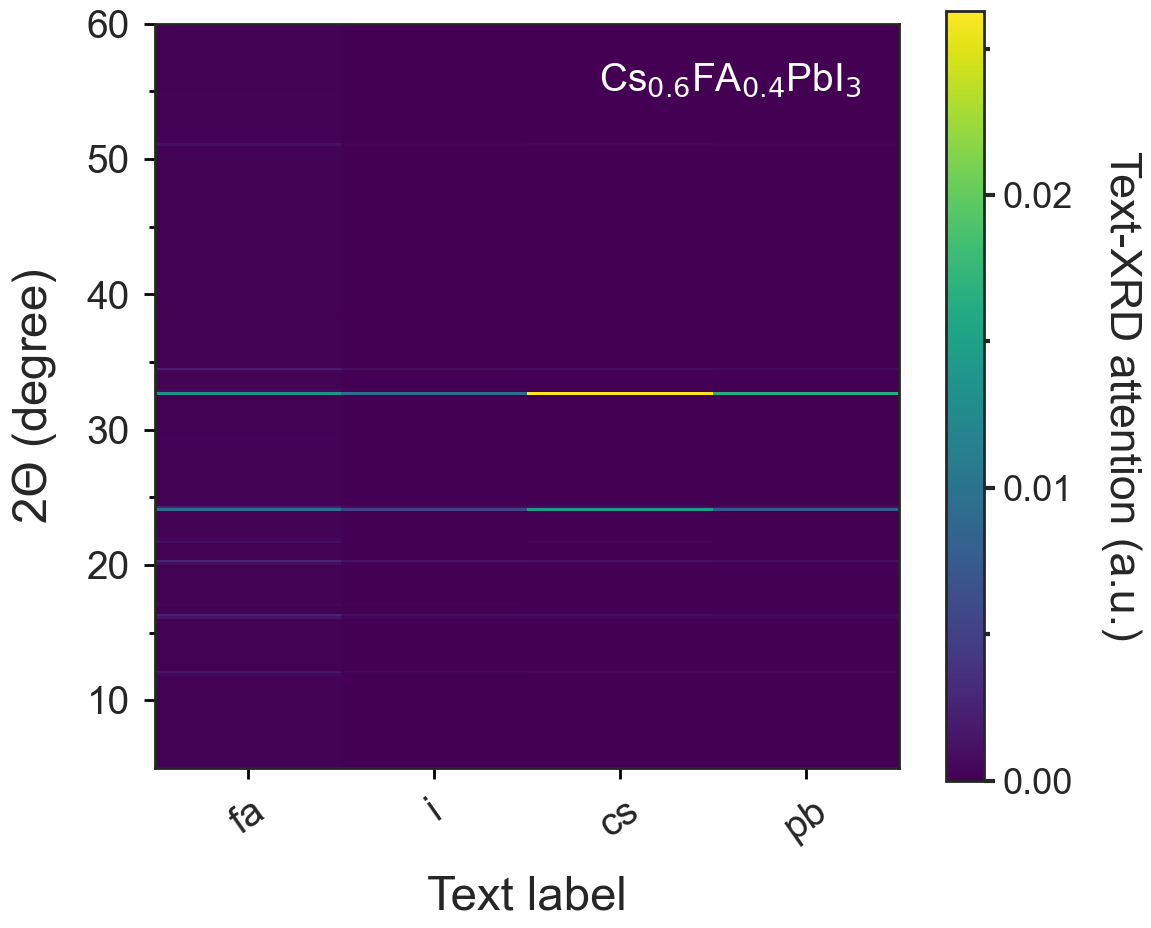

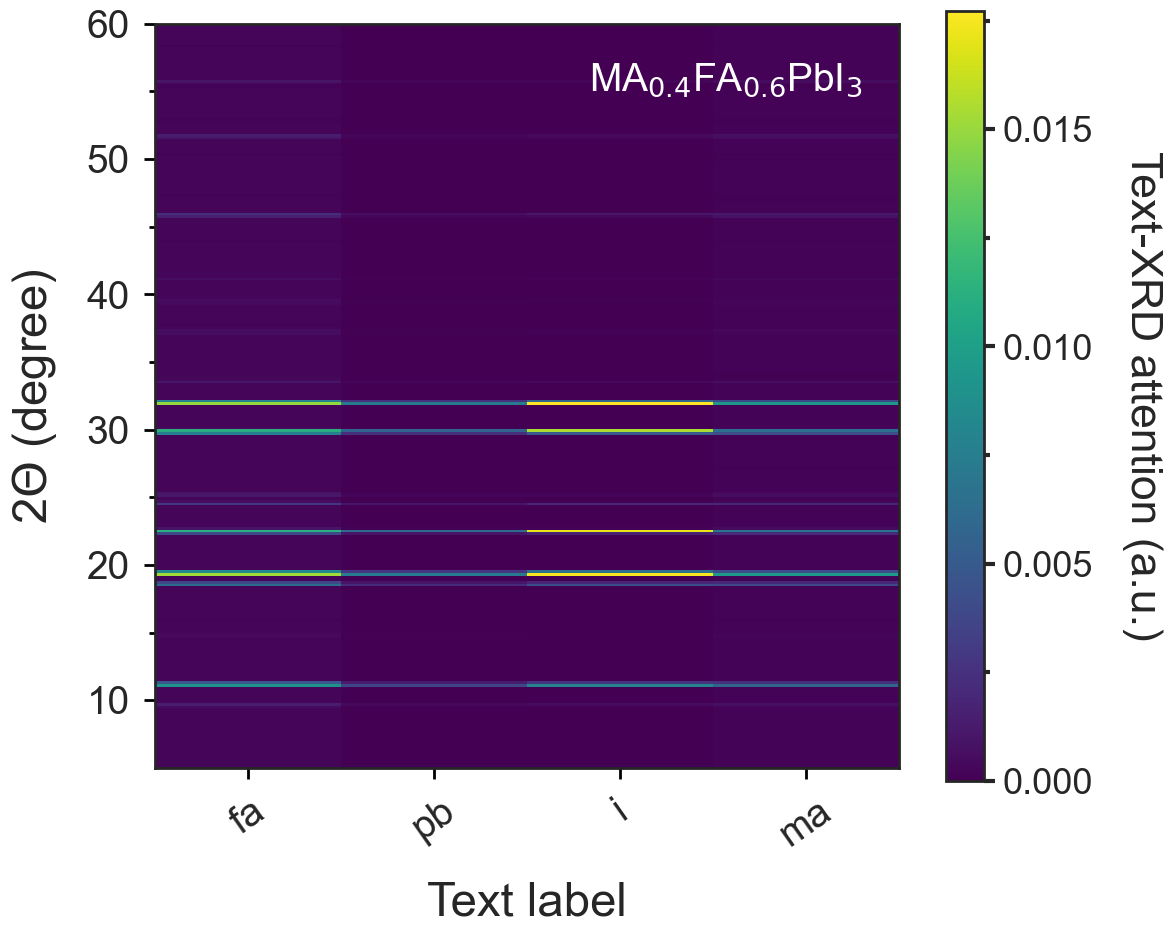

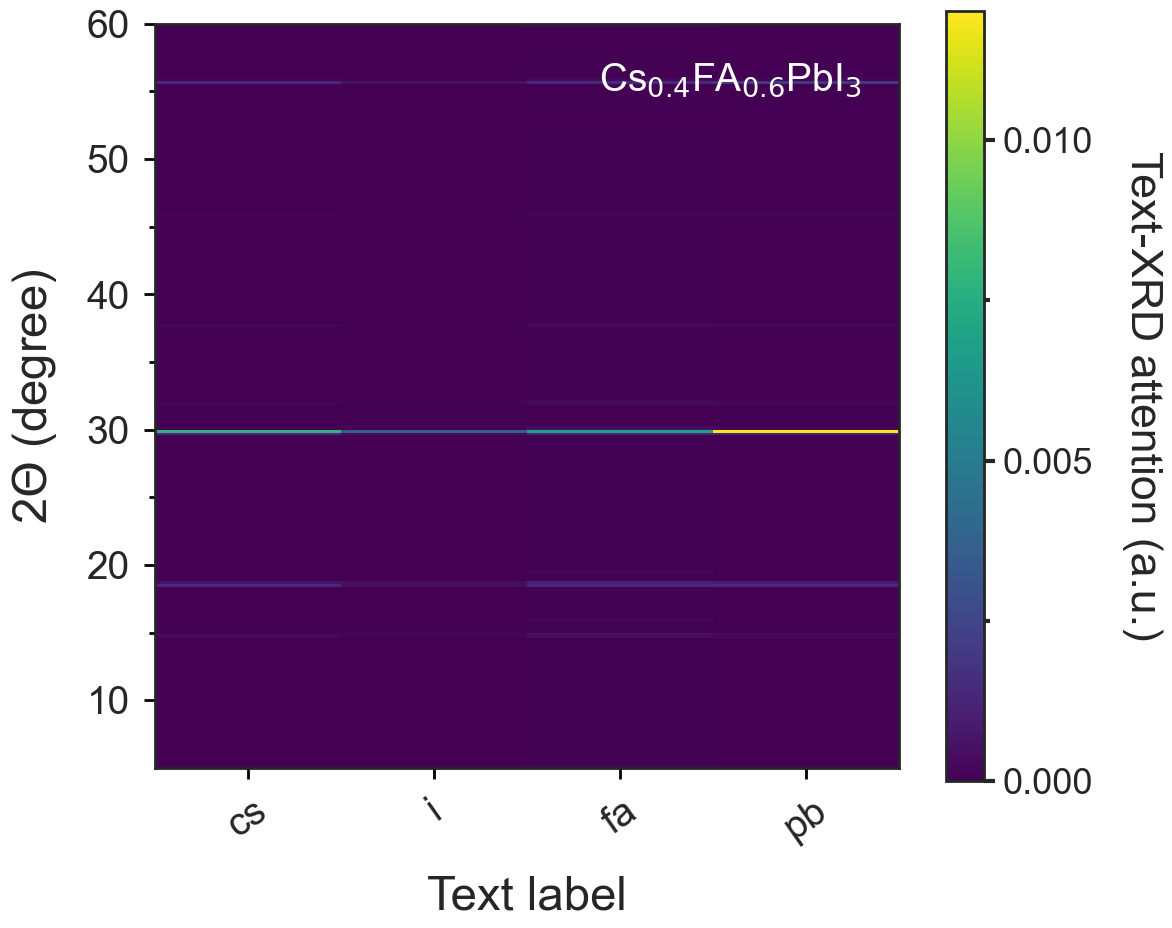

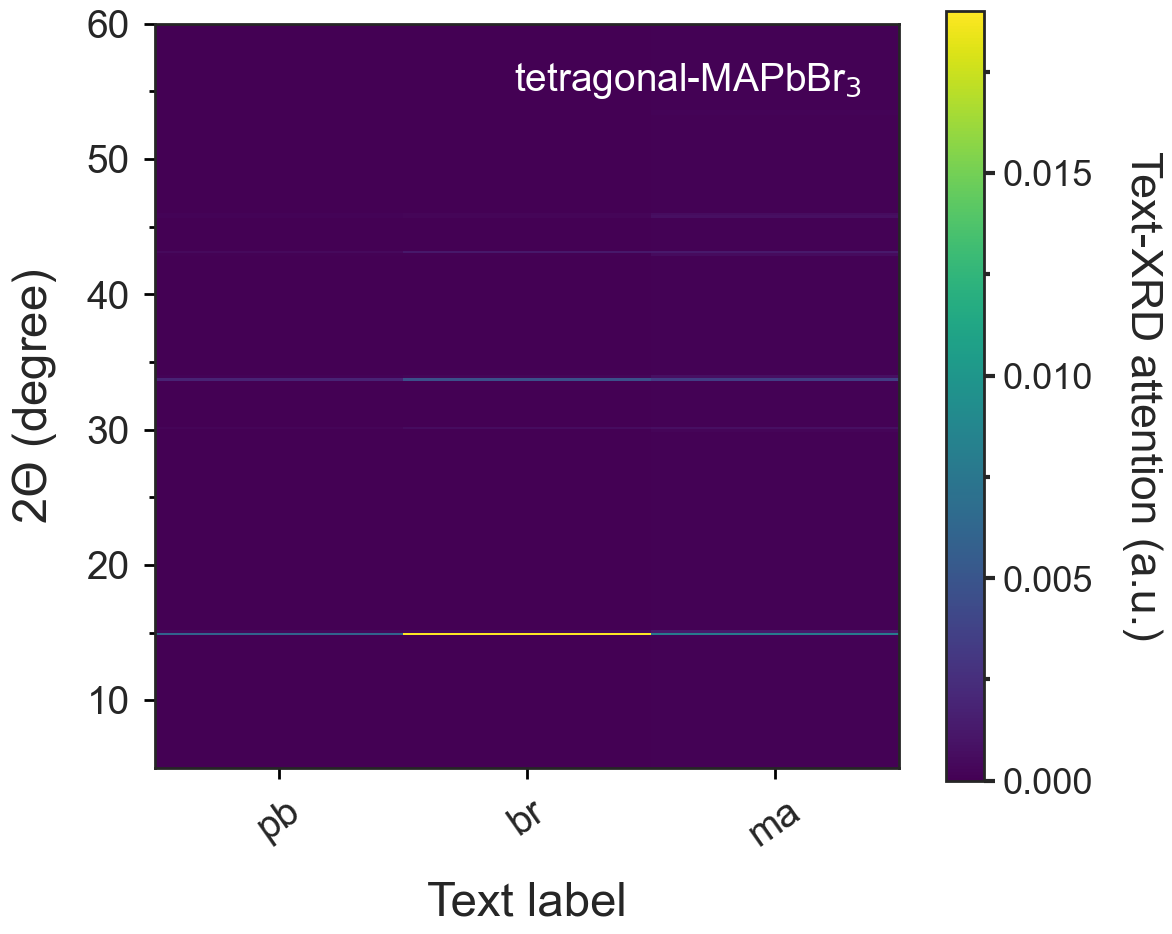

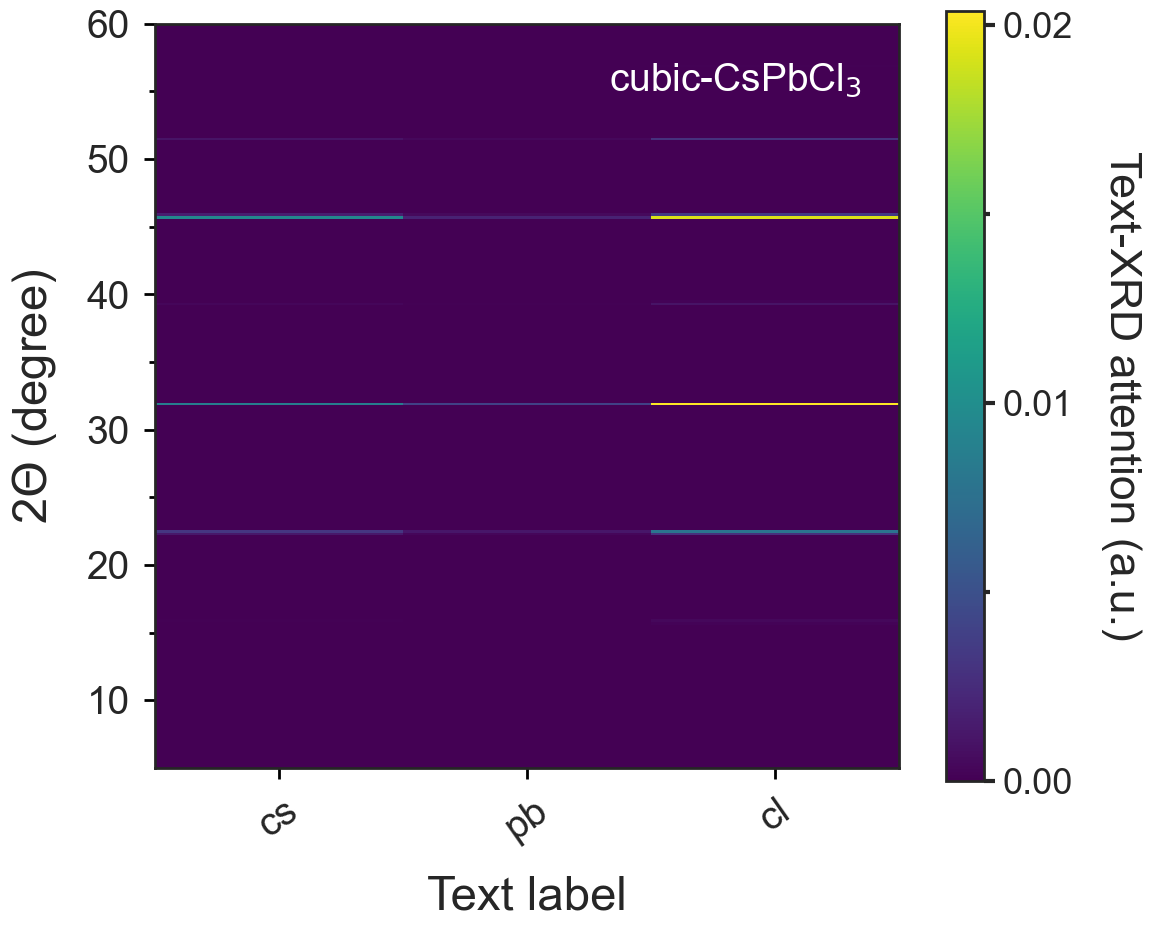

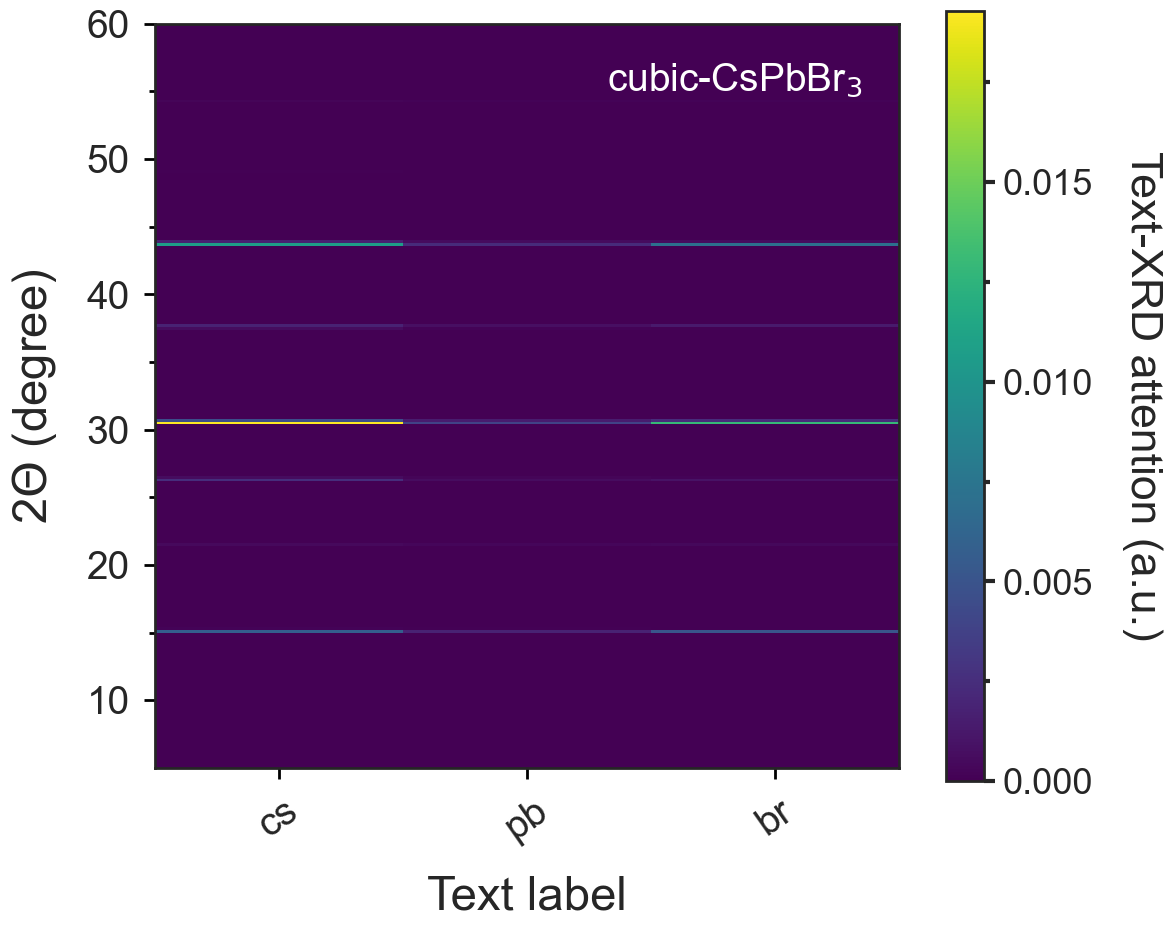

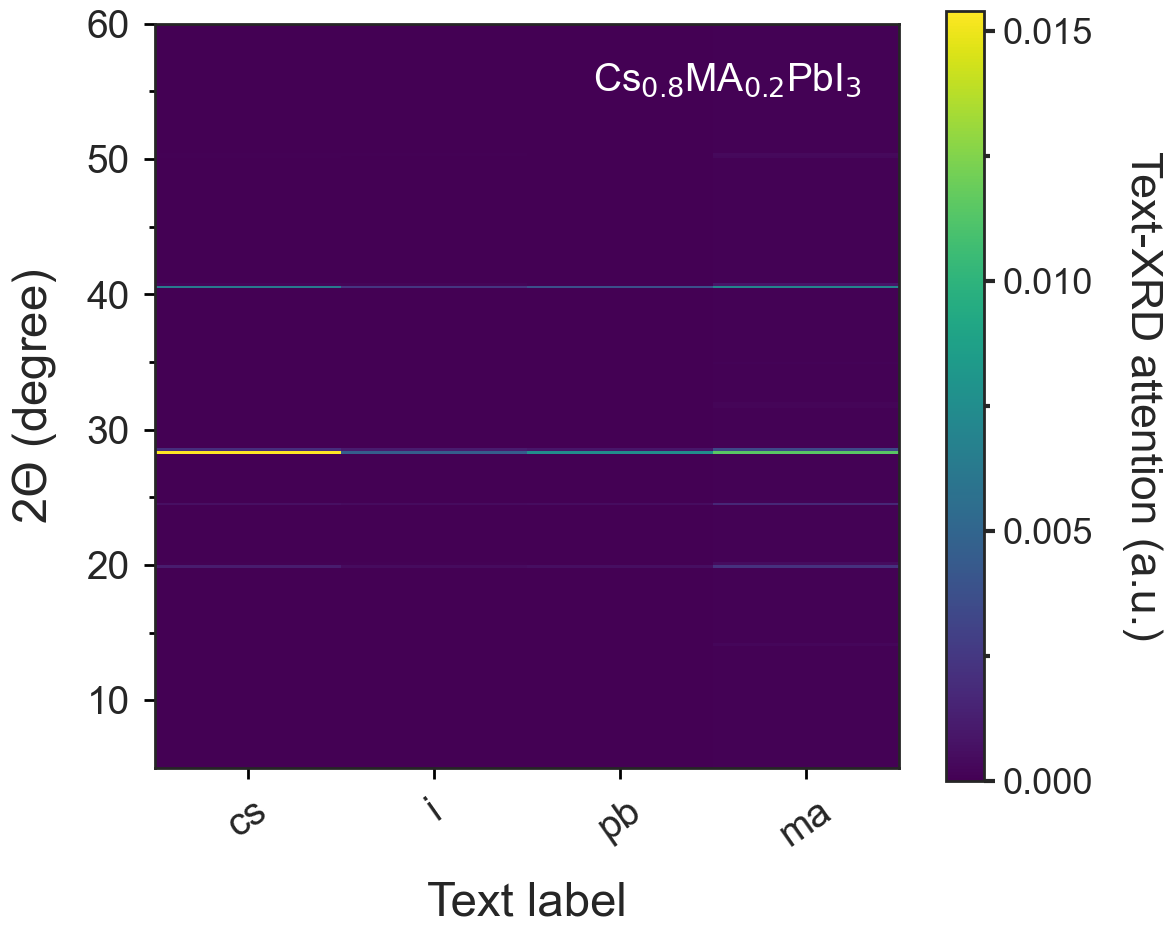

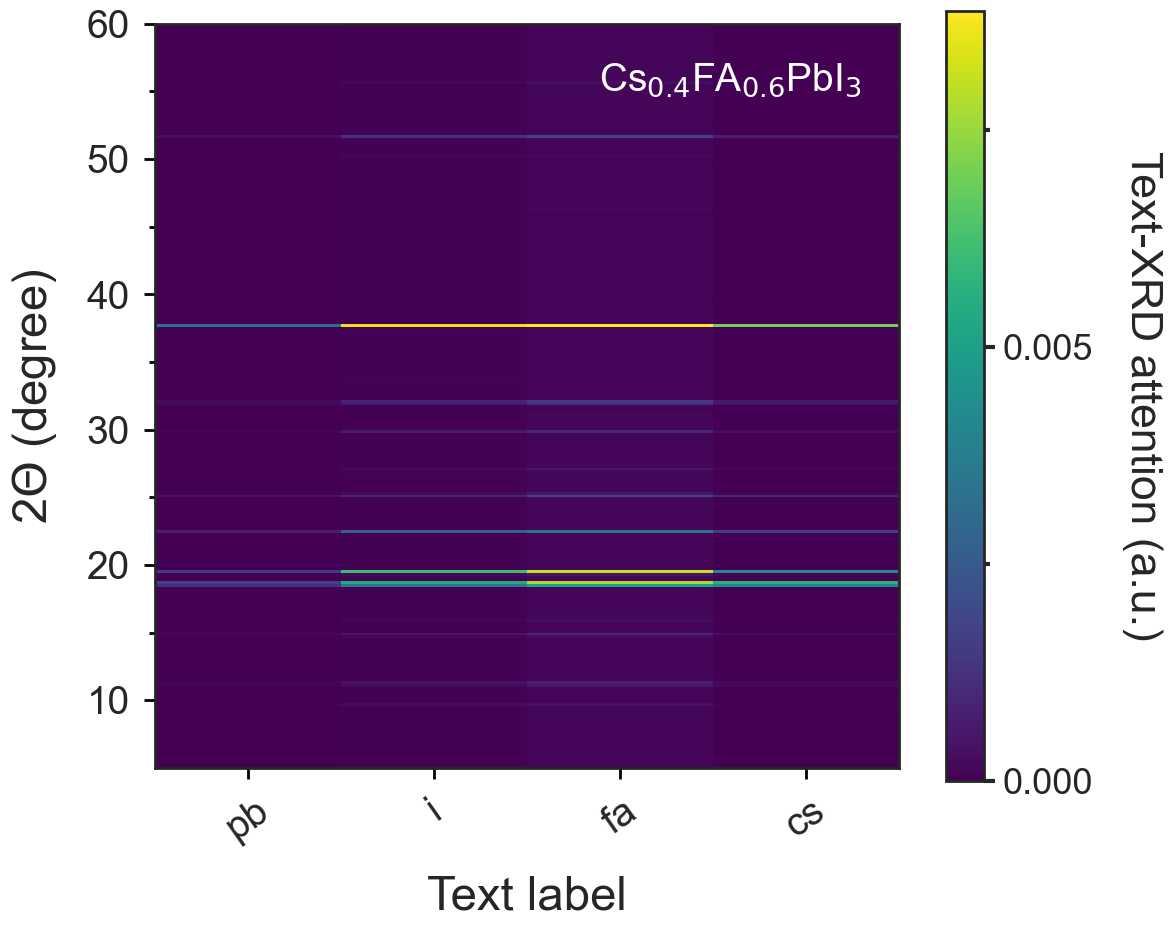

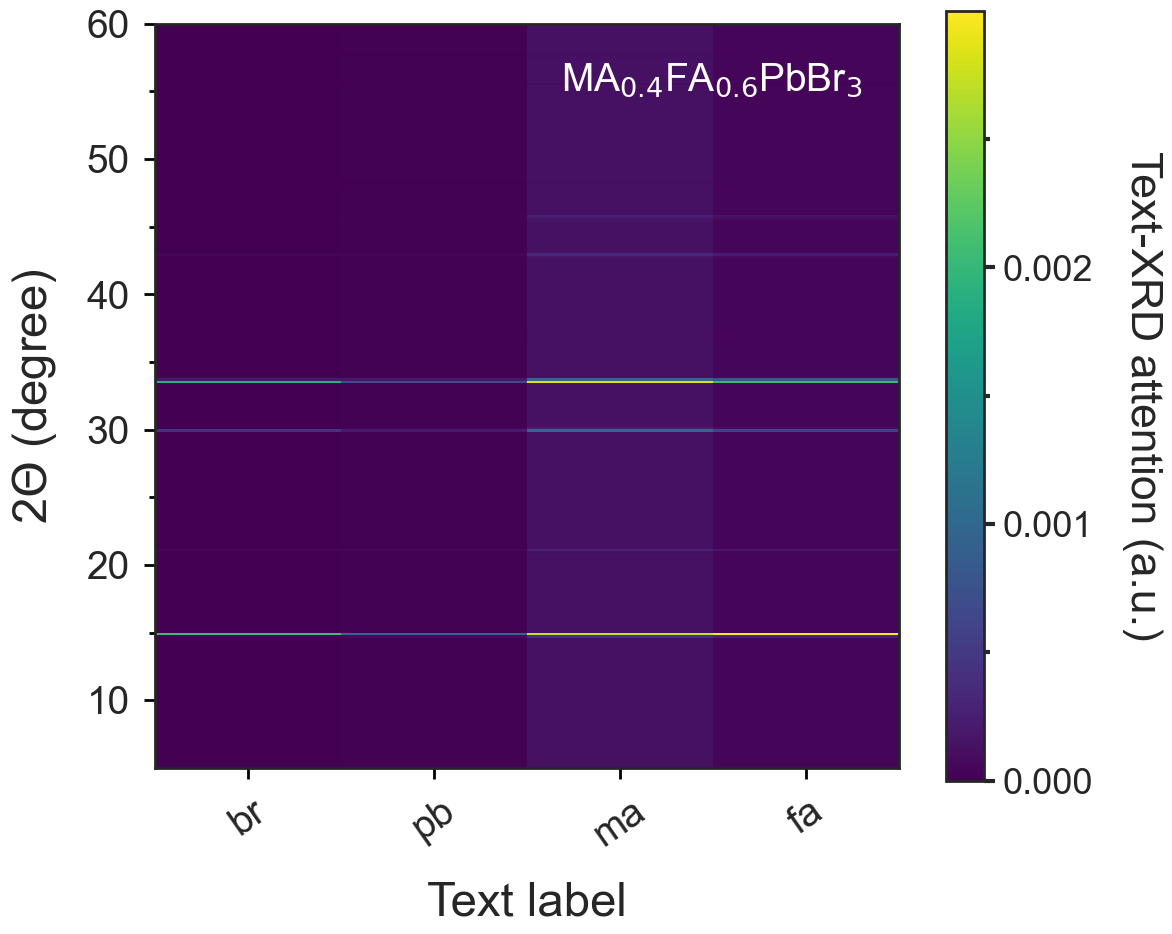

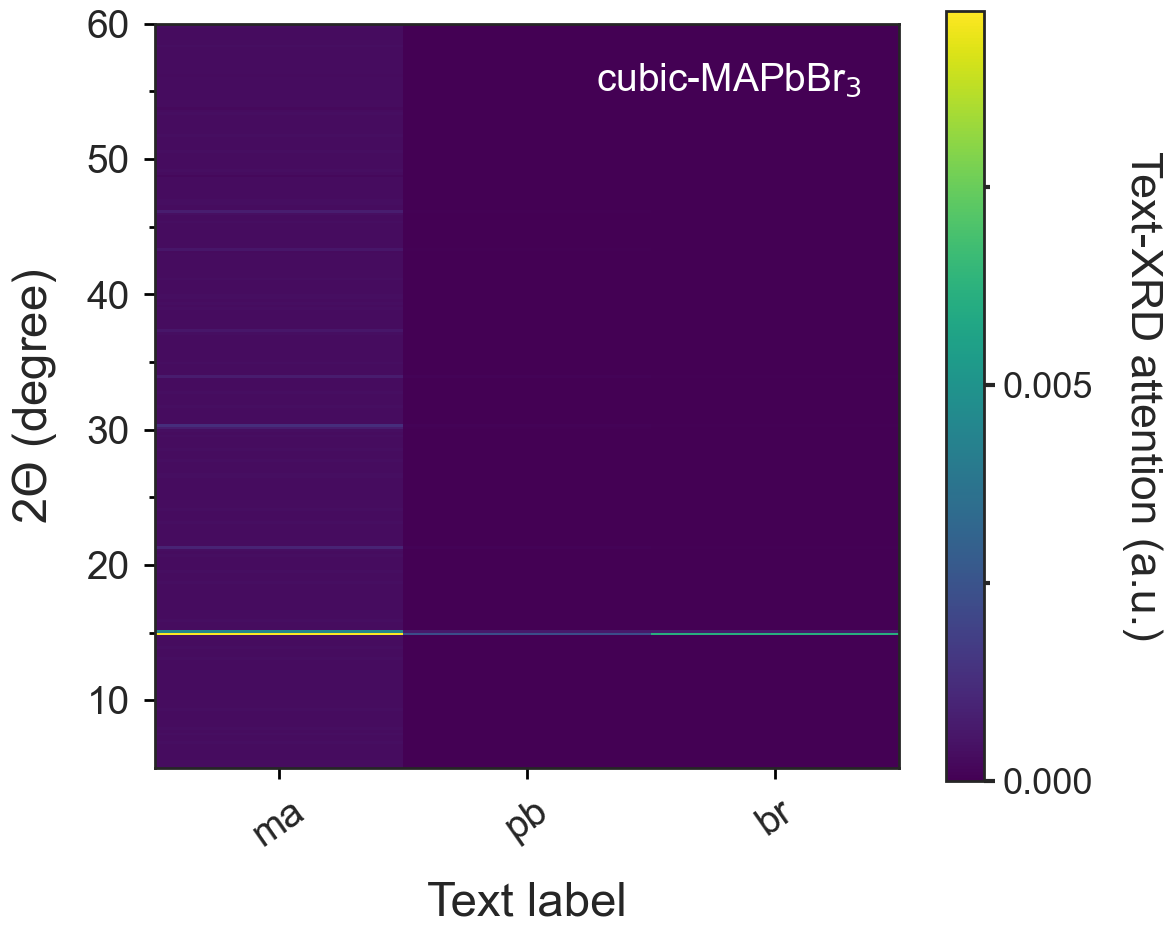

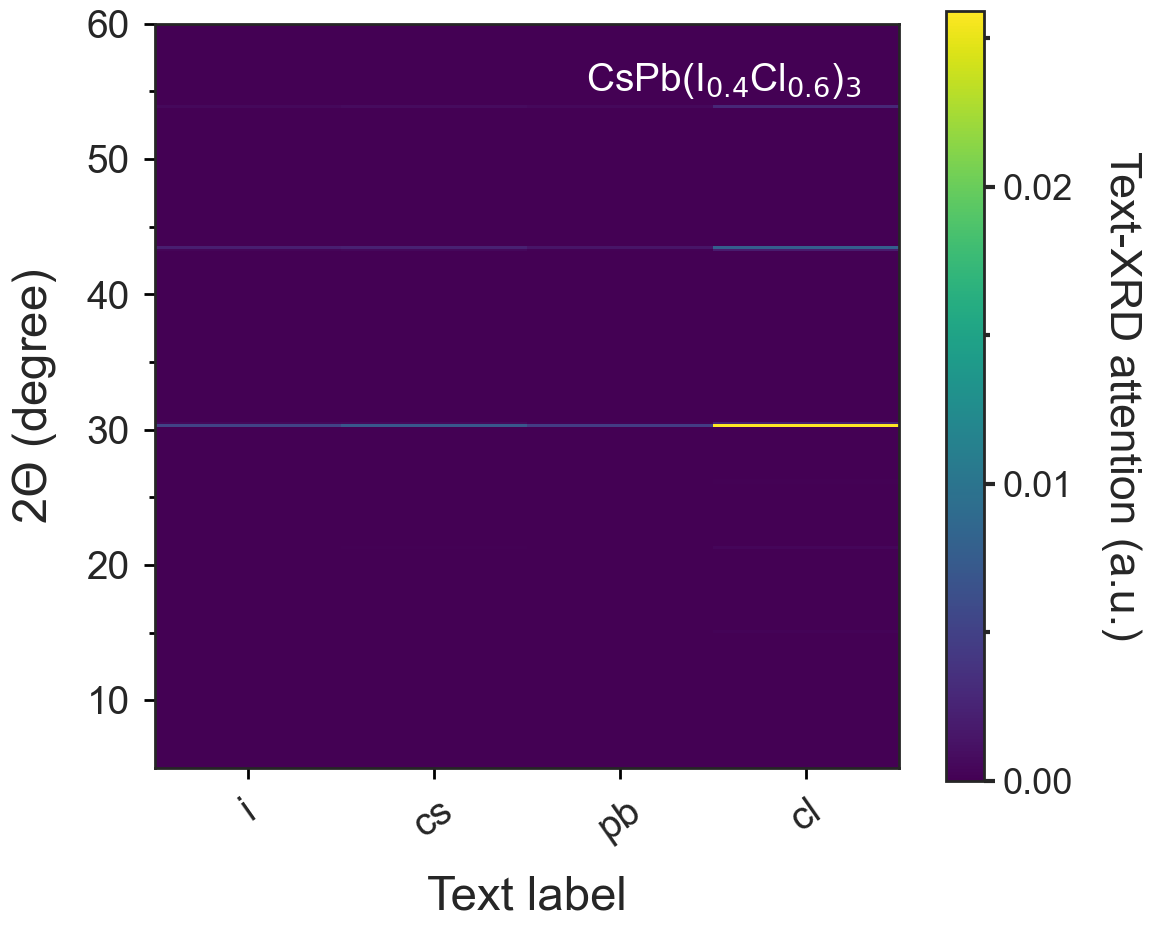

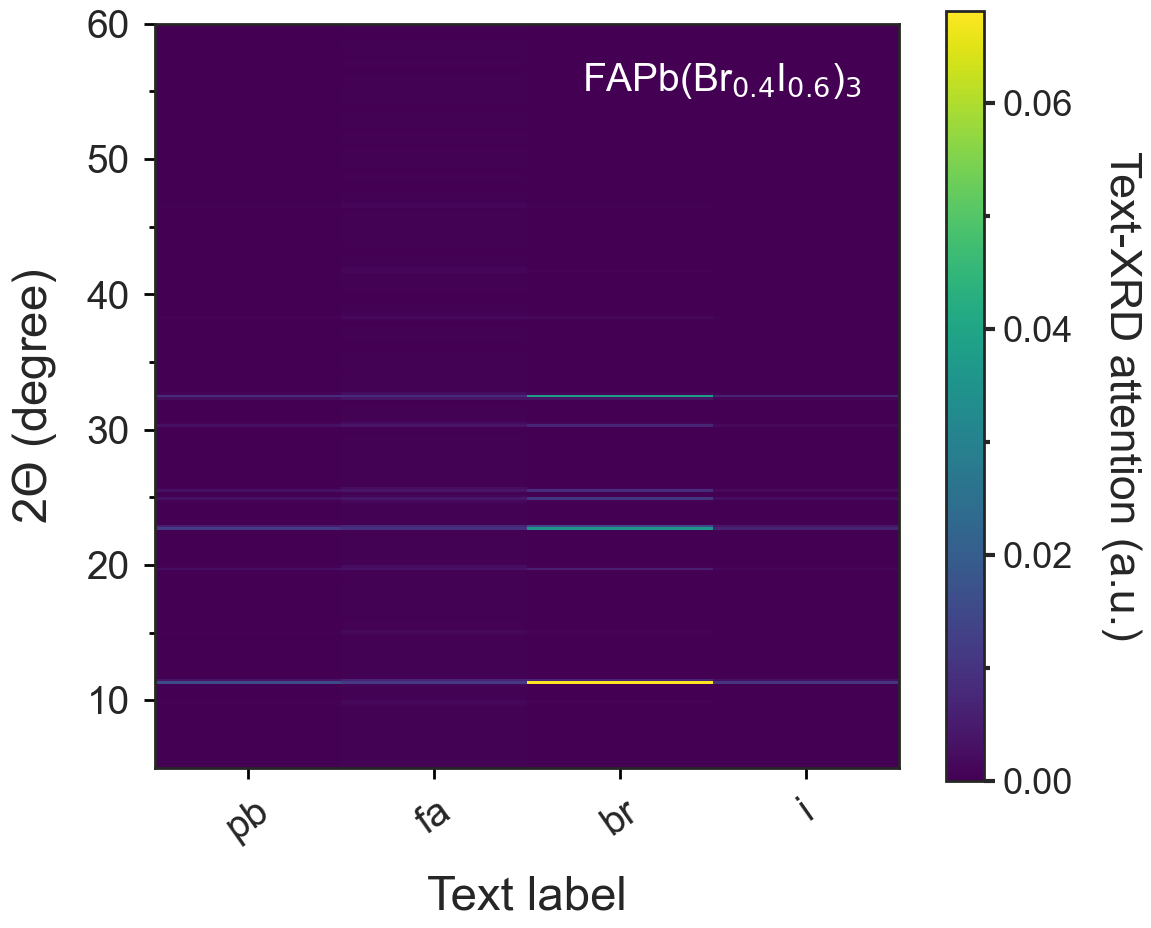

In [336]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(30):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,1:len(inputs['input_ids'][0])-1,len(inputs['input_ids'][0]):]
    extent = [0.5,0.5+len(inputs['input_ids'][0])-2,twotheta[0],twotheta[-1]]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='viridis', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1], rotation=35)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
#     ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
    ax.axes.set_xlim([0.5,0.5+len(inputs['input_ids'][0])-2])
    ax.axes.set_ylim([5,60])

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Text-XRD attention (a.u.)',labelpad=50, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Text label', labelpad=20, fontsize=34)
    ax.set_ylabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    plt.text(0.95, 0.91, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), 
             fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')

    plt.savefig(os.path.join(folder, 'models', model_folder,'{}_attention.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


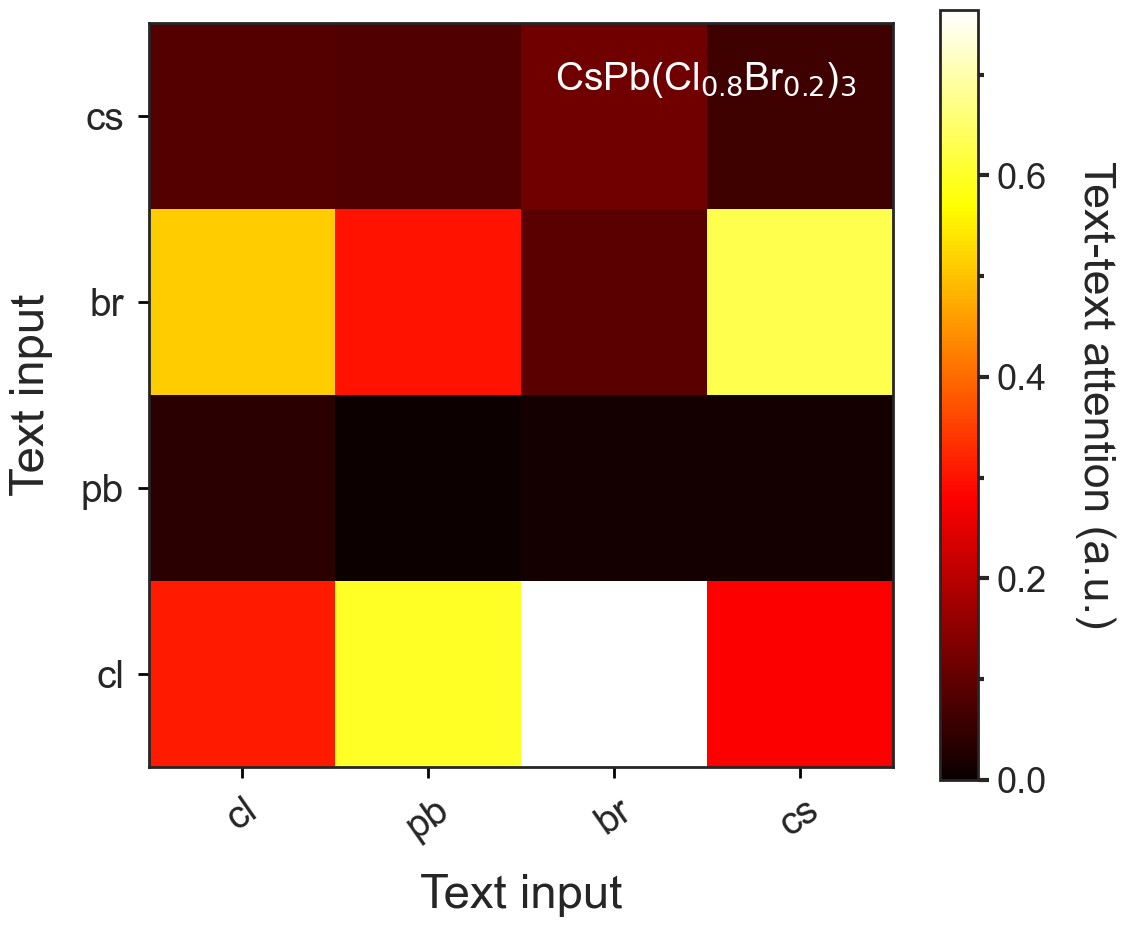

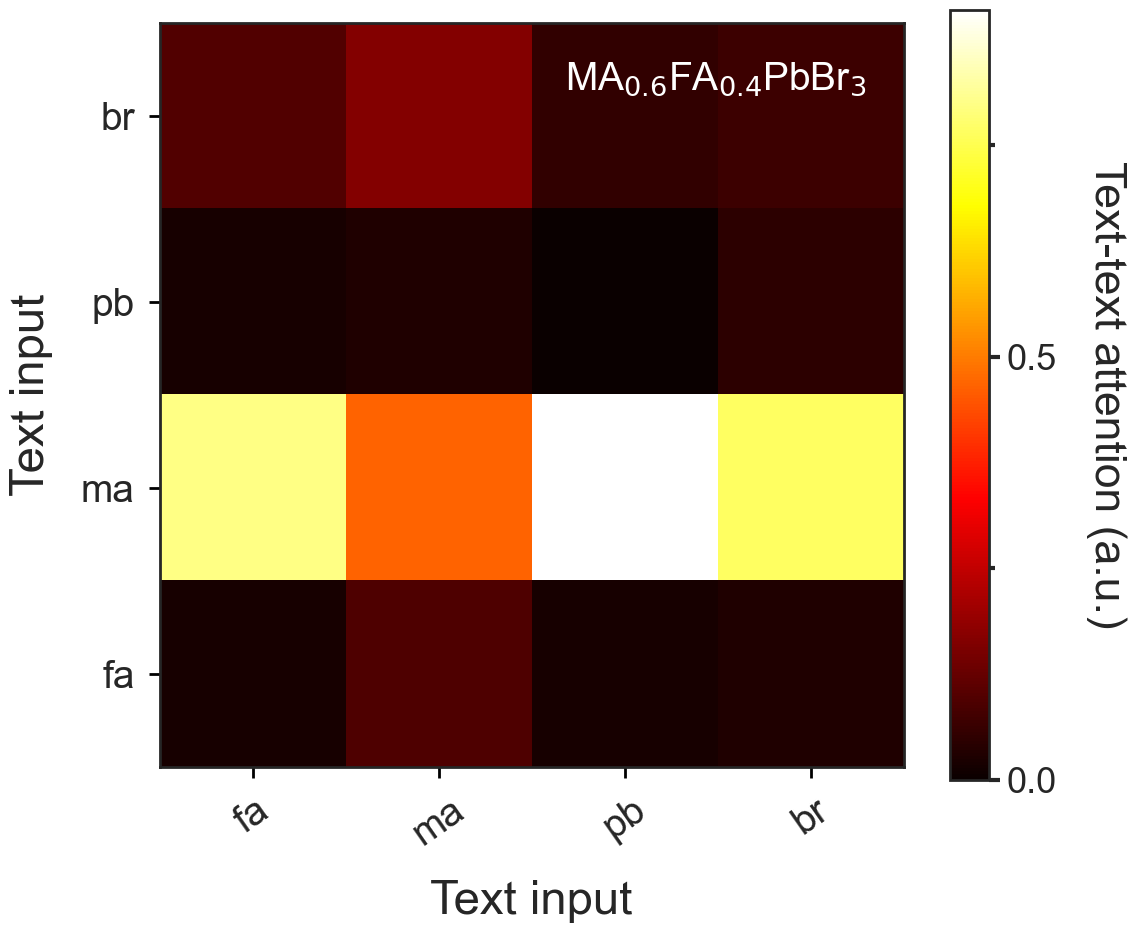

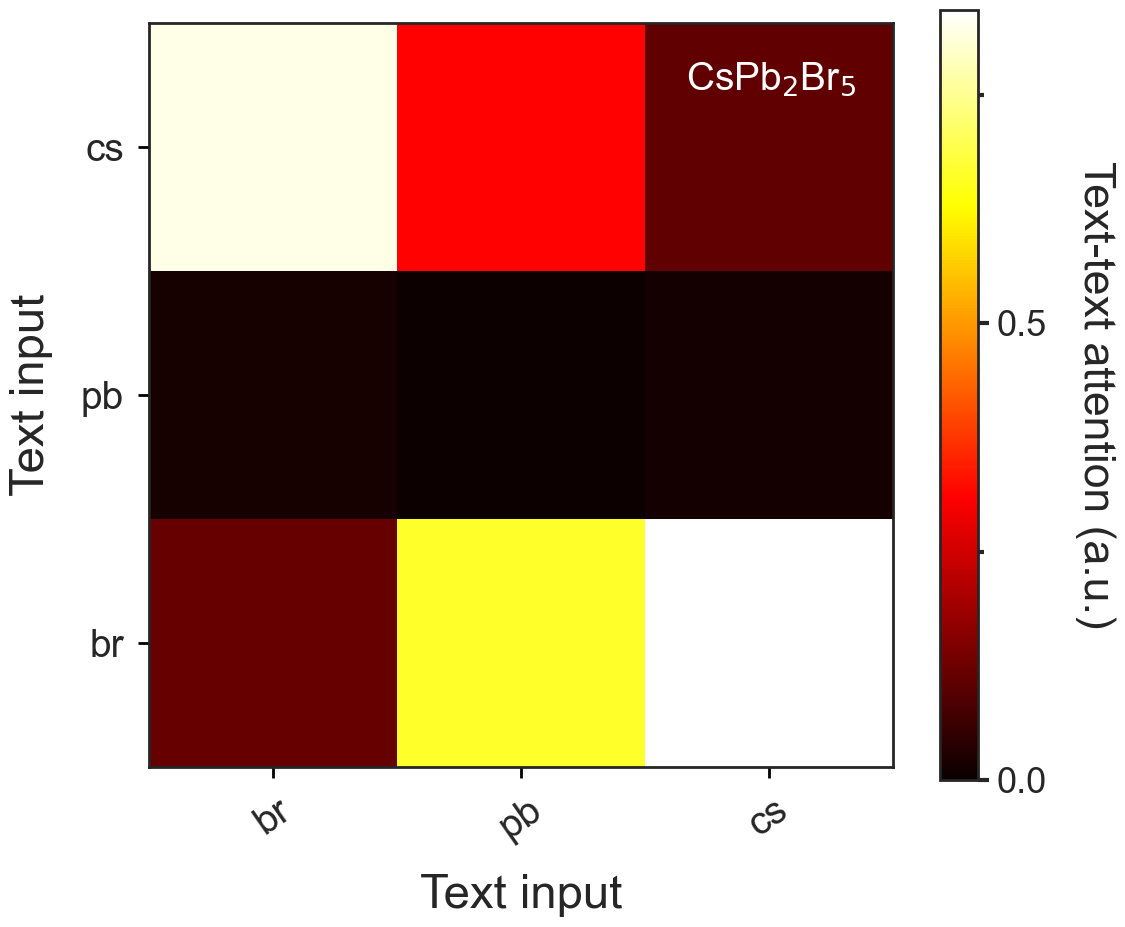

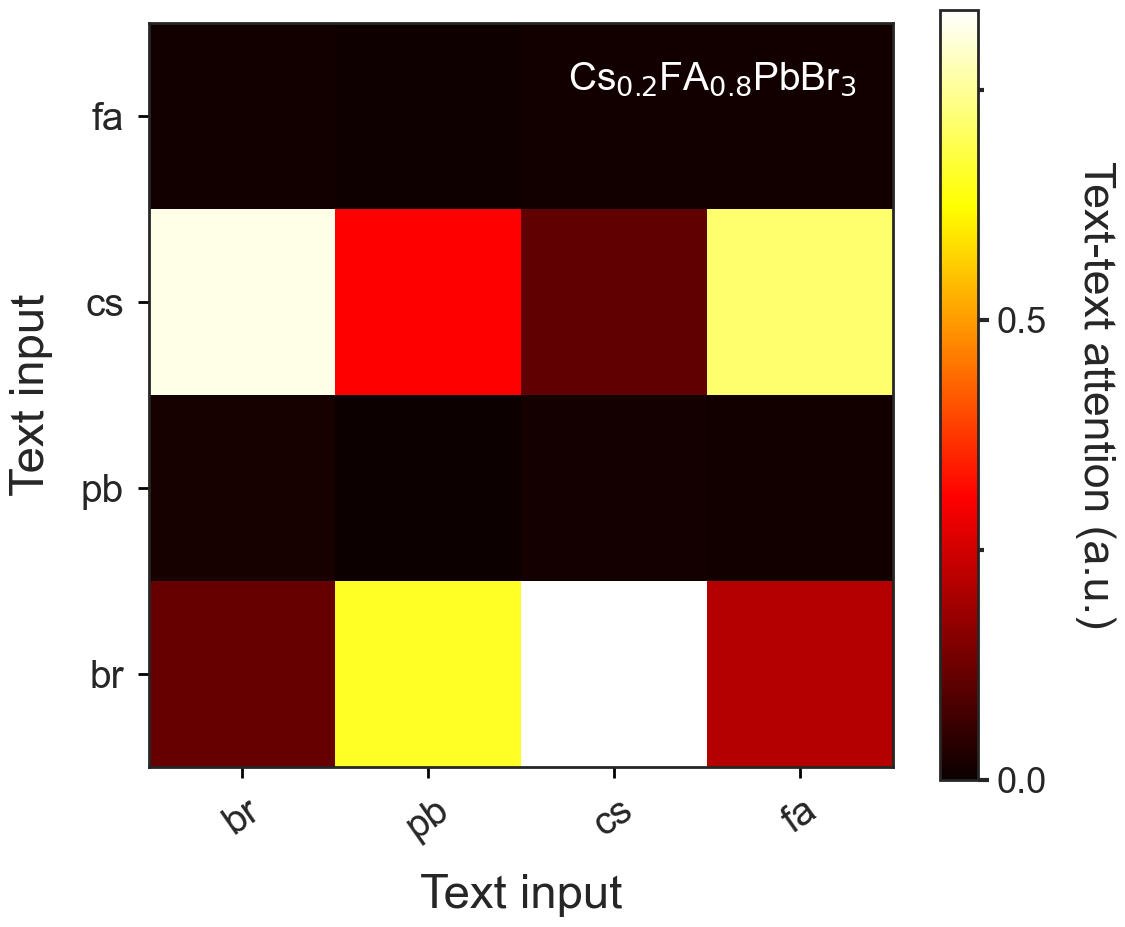

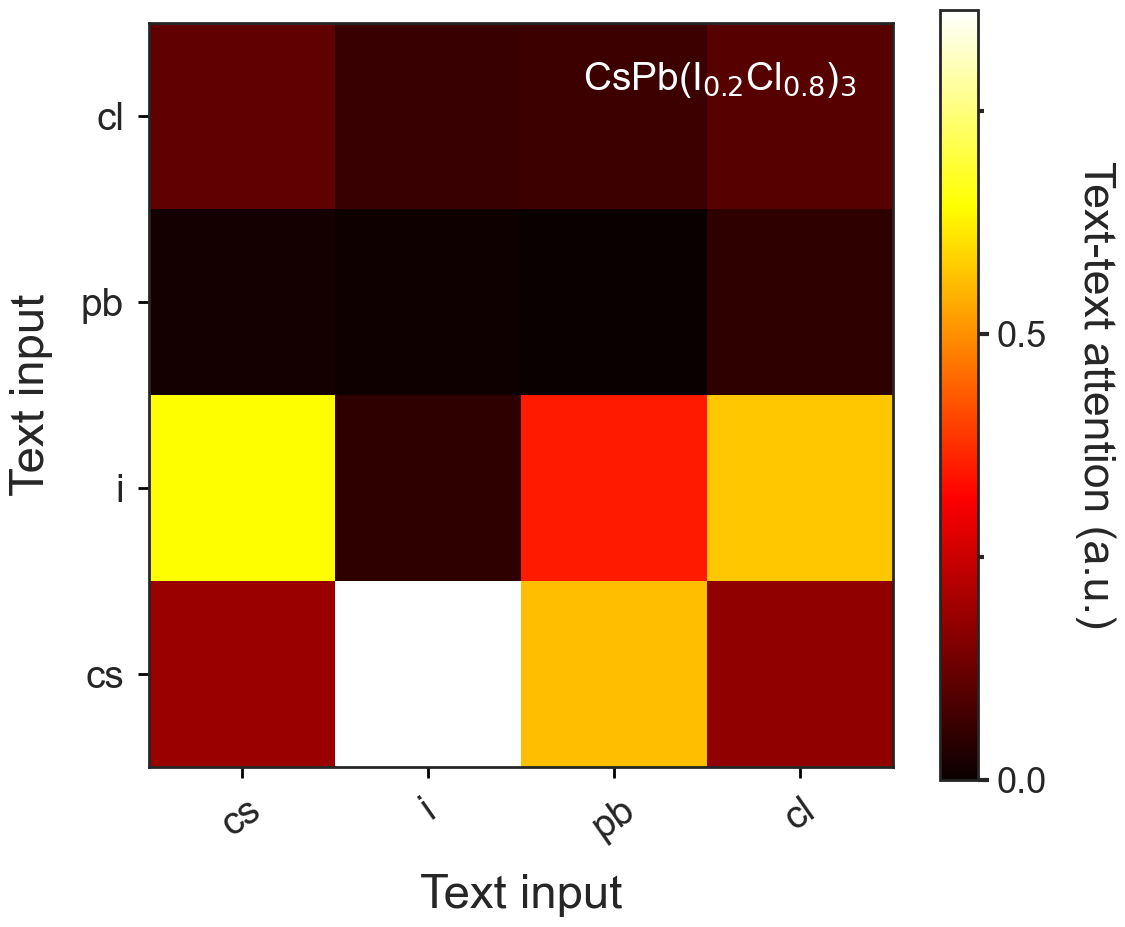

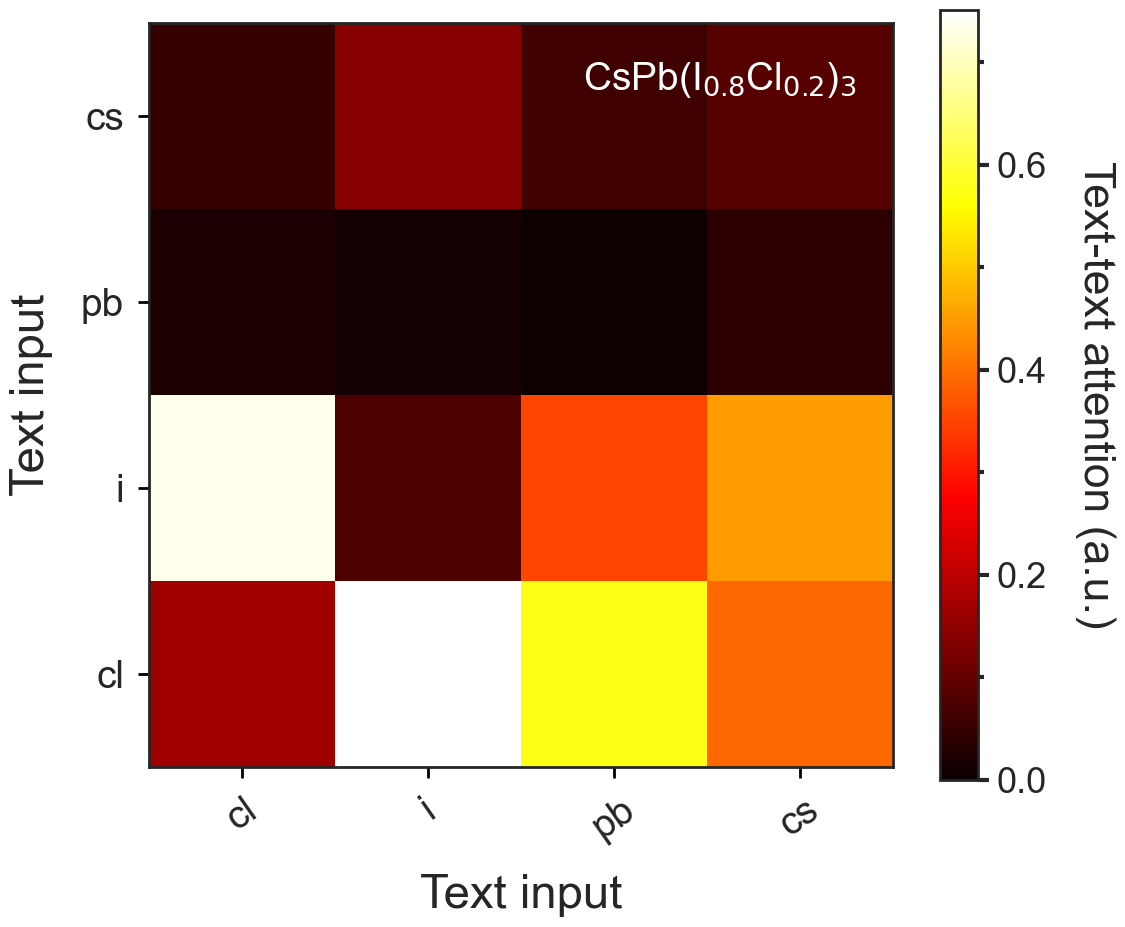

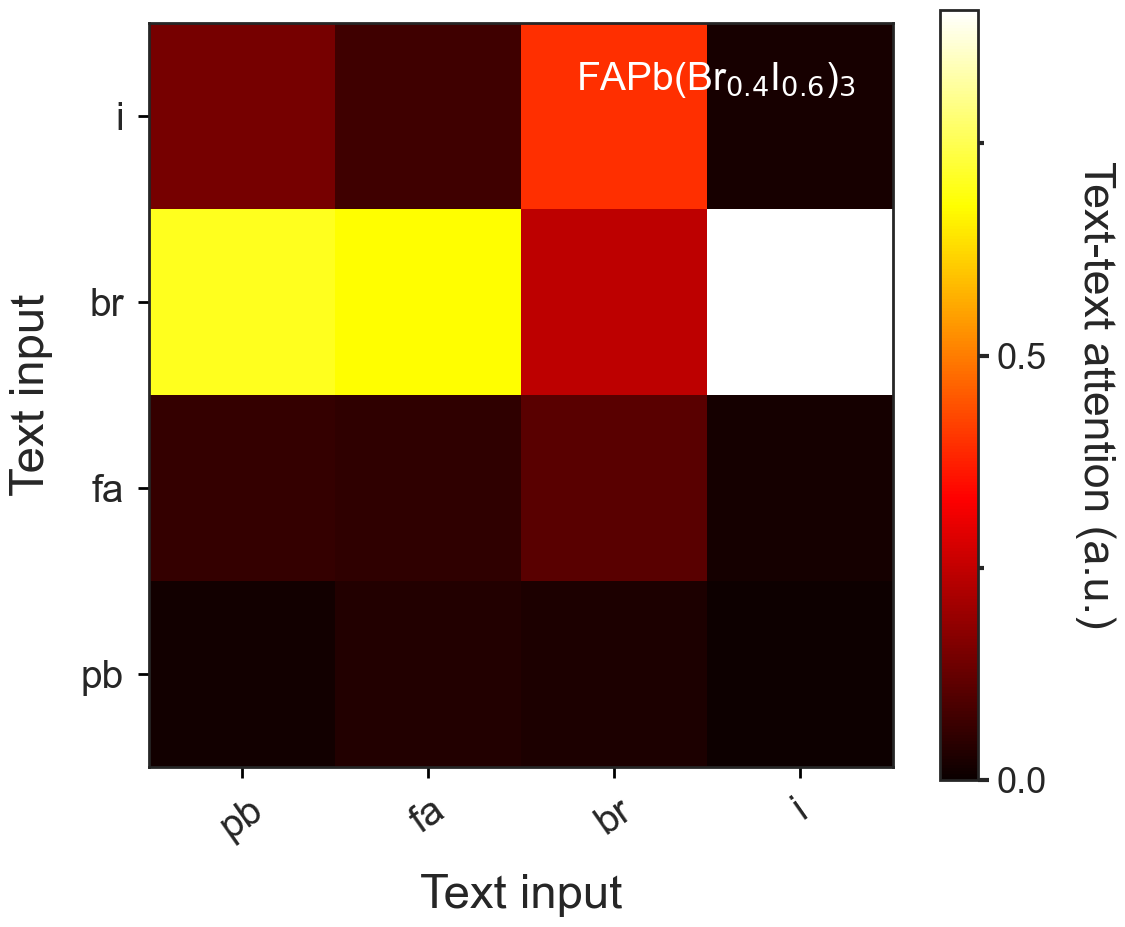

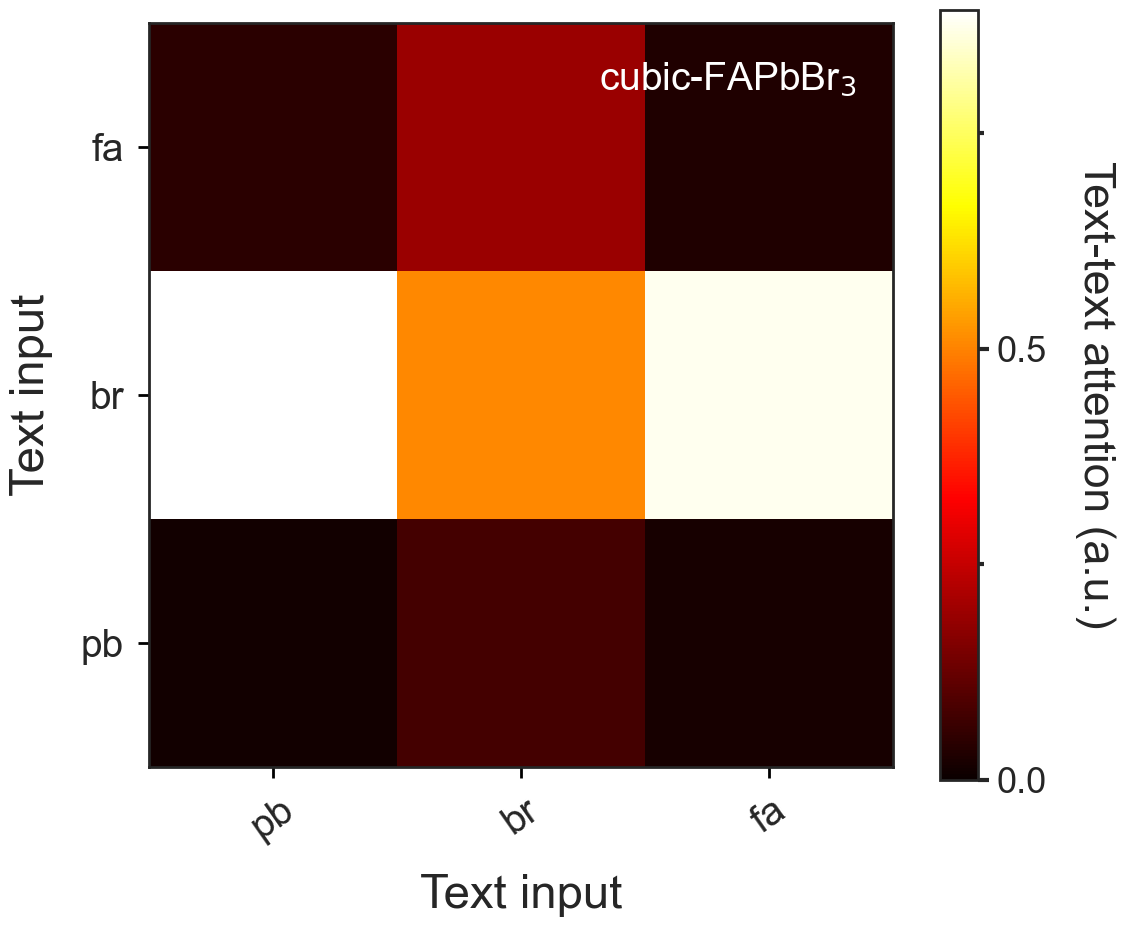

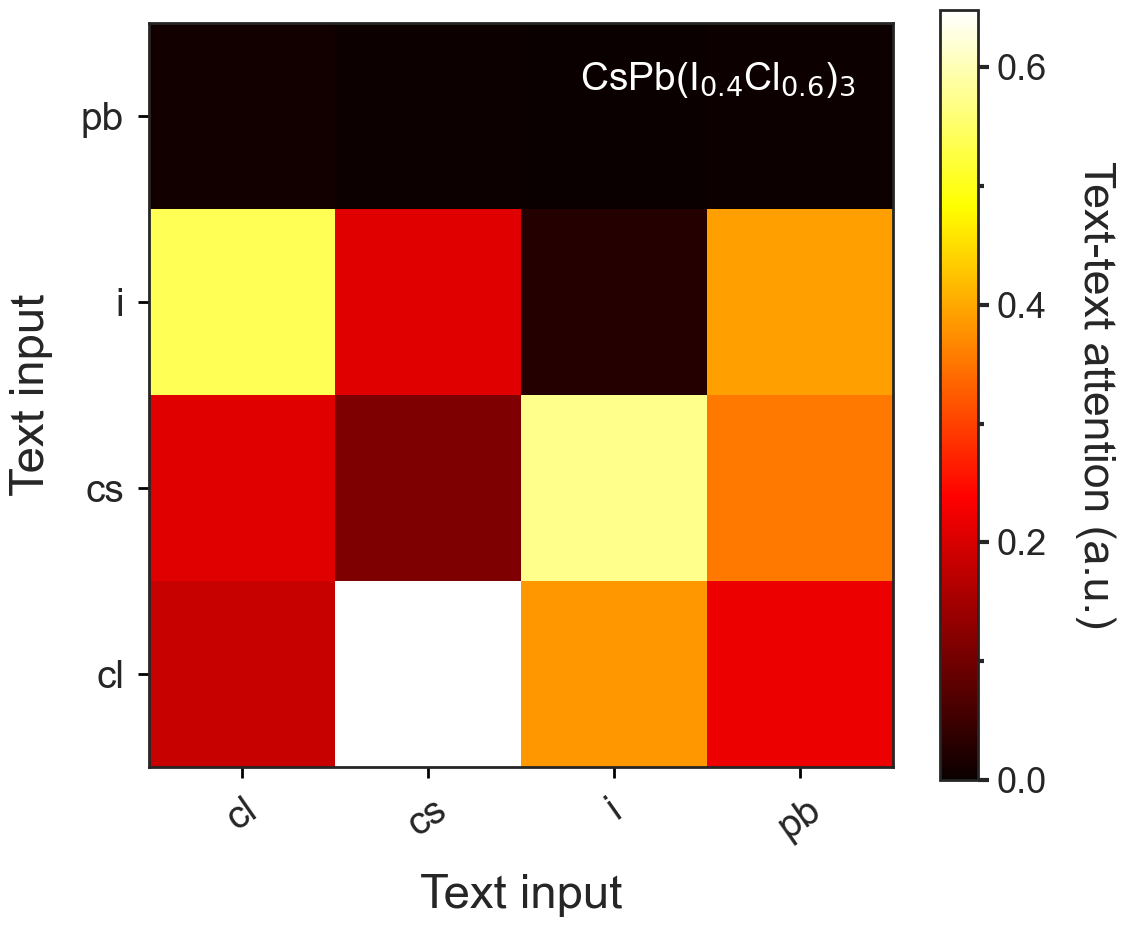

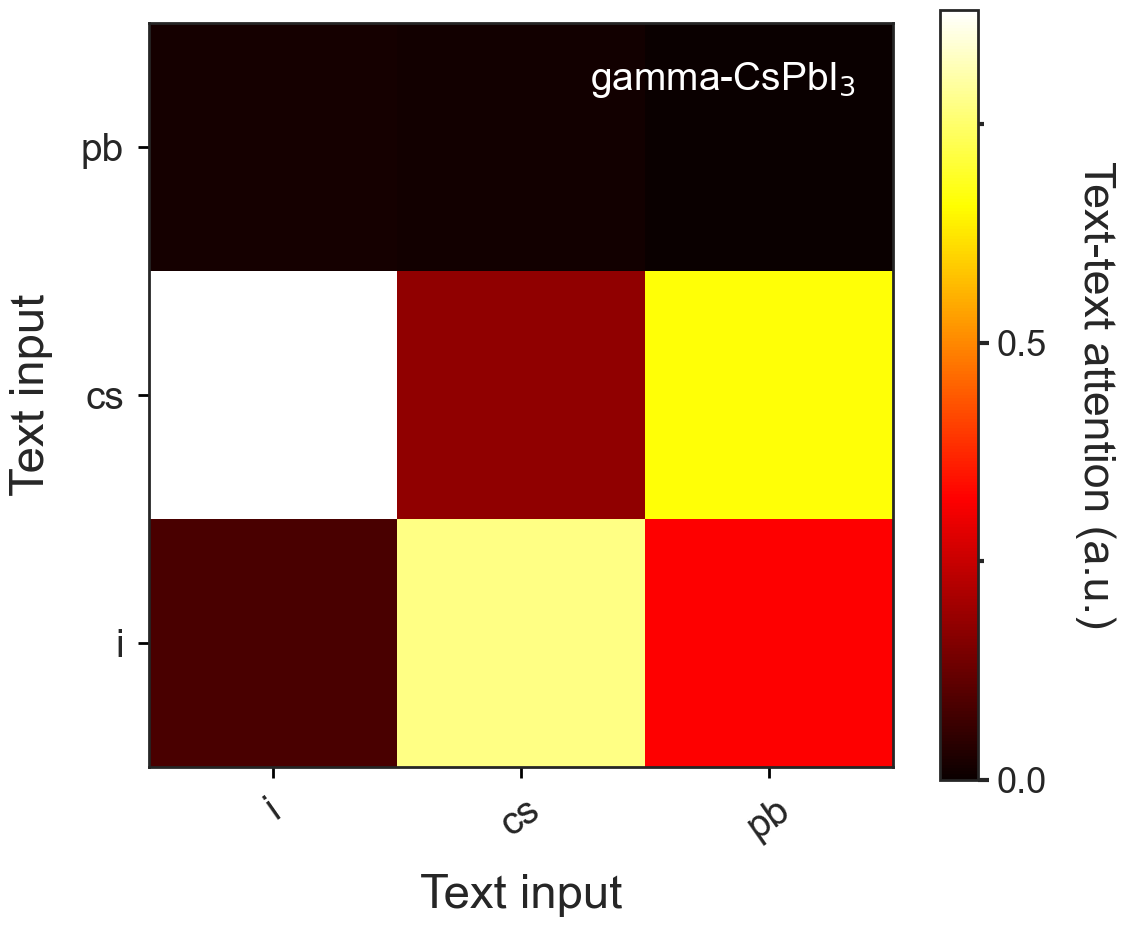

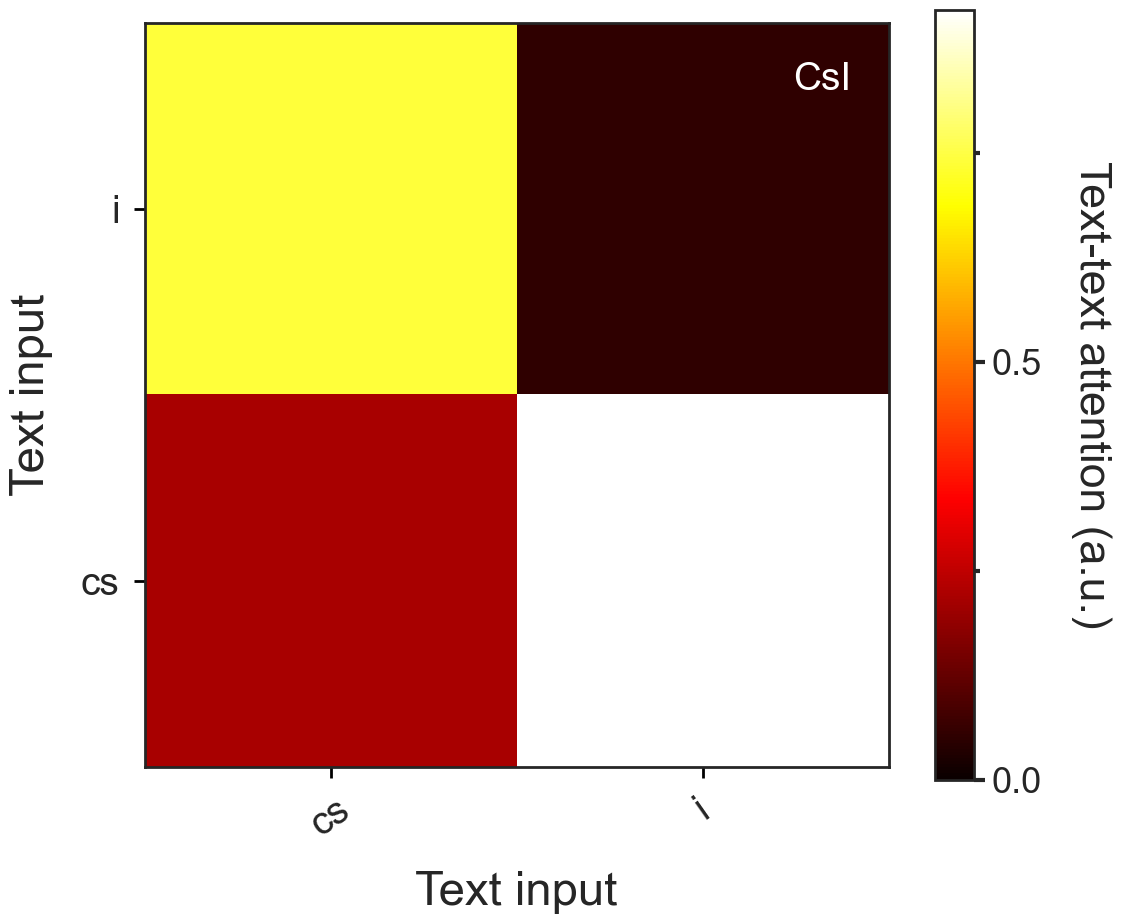

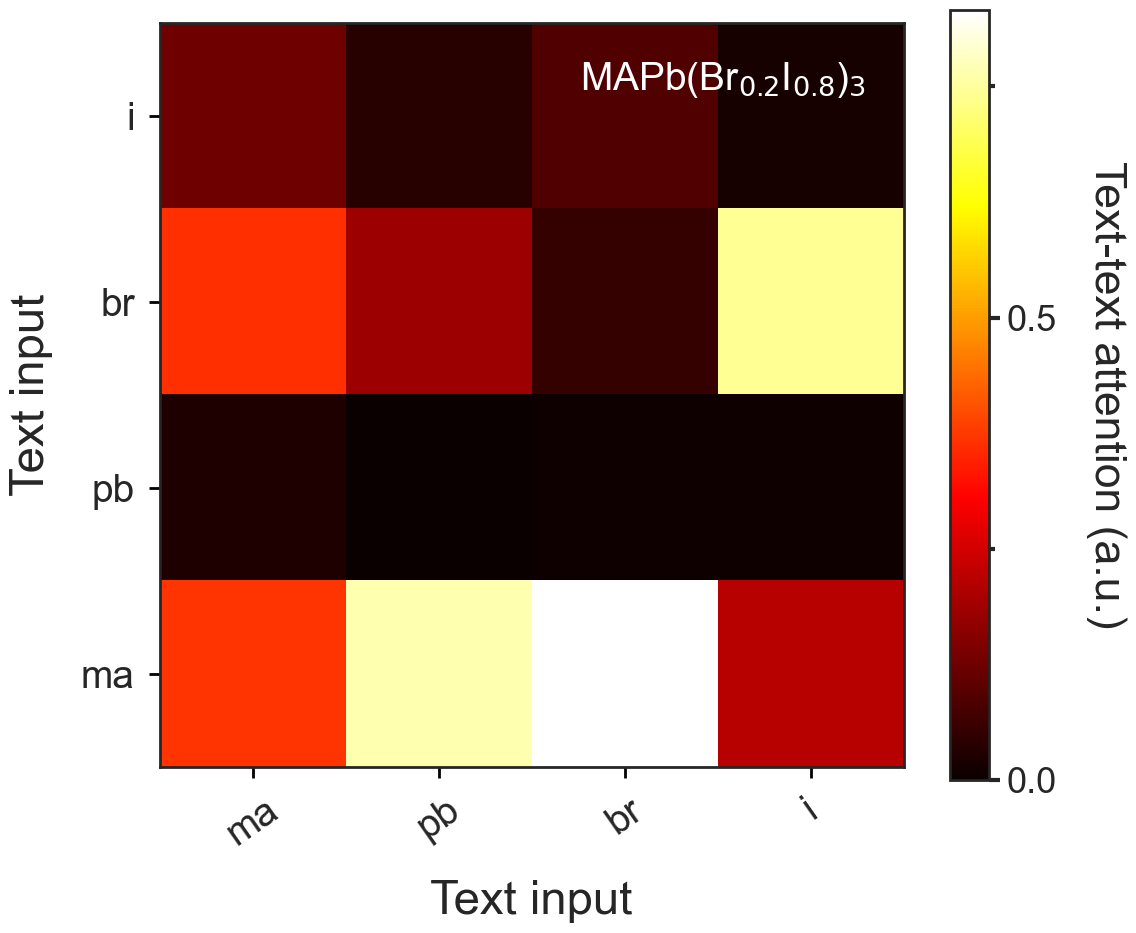

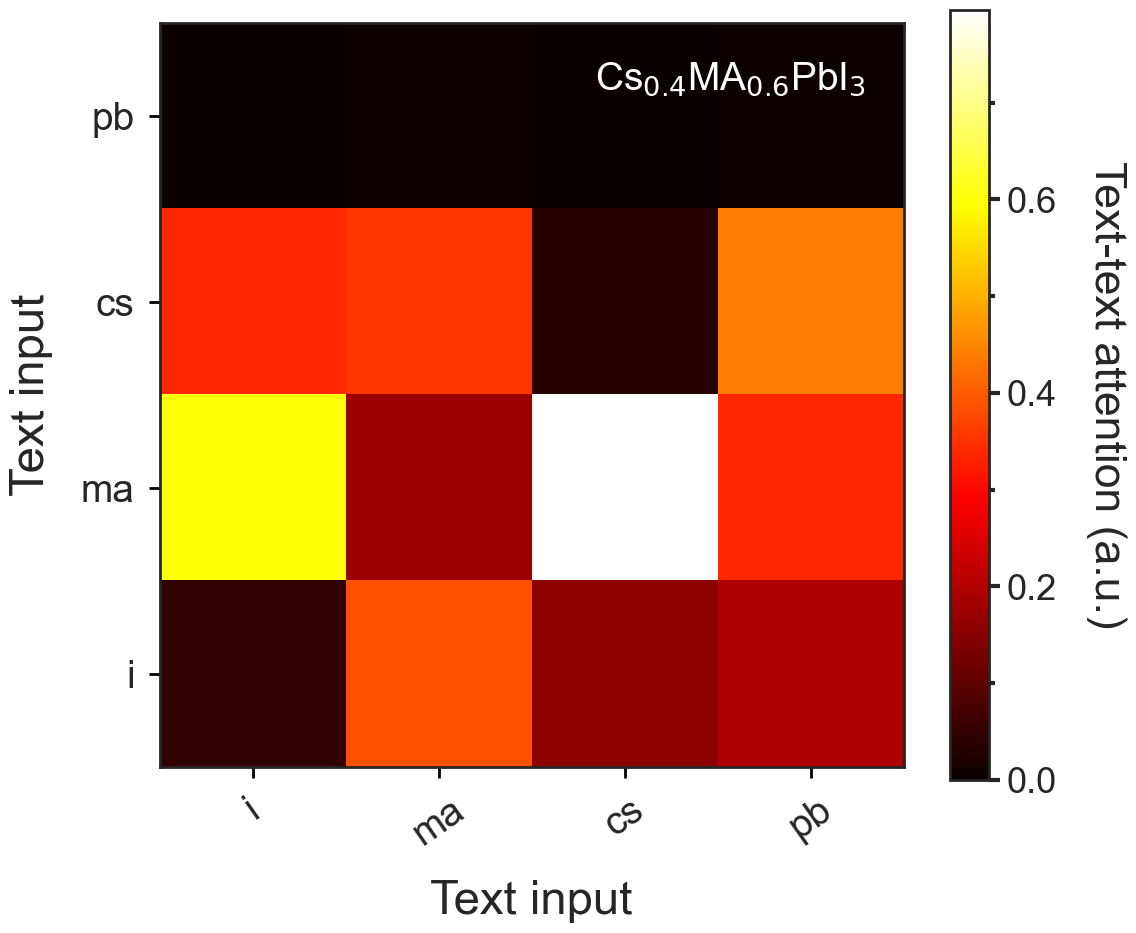

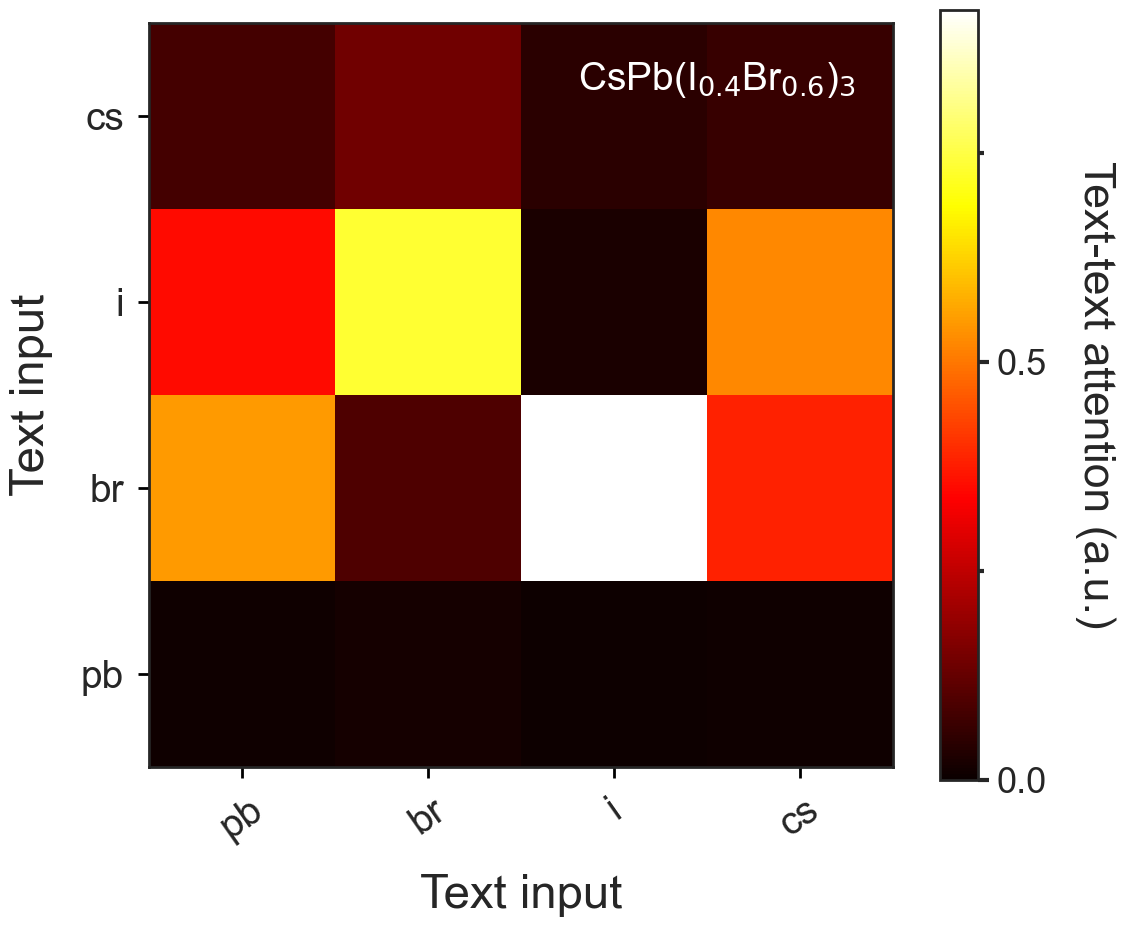

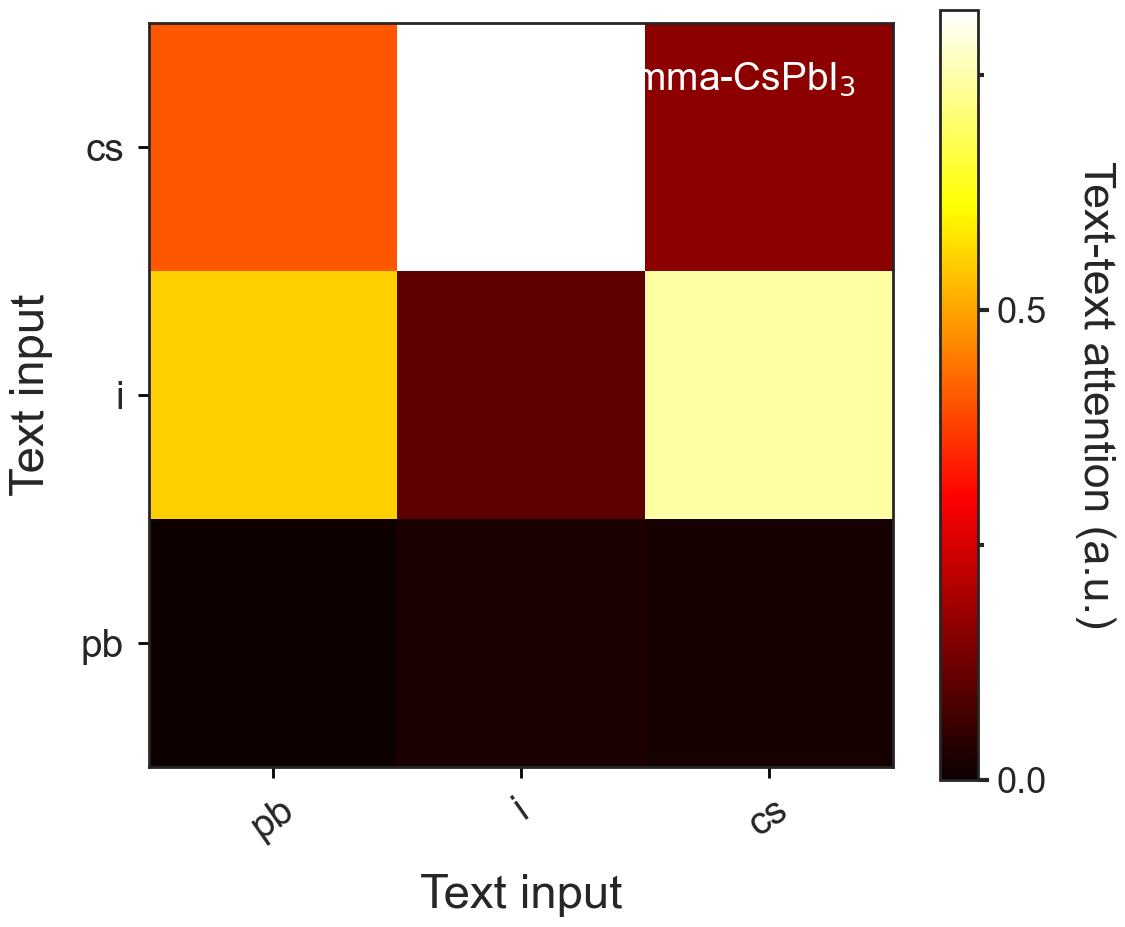

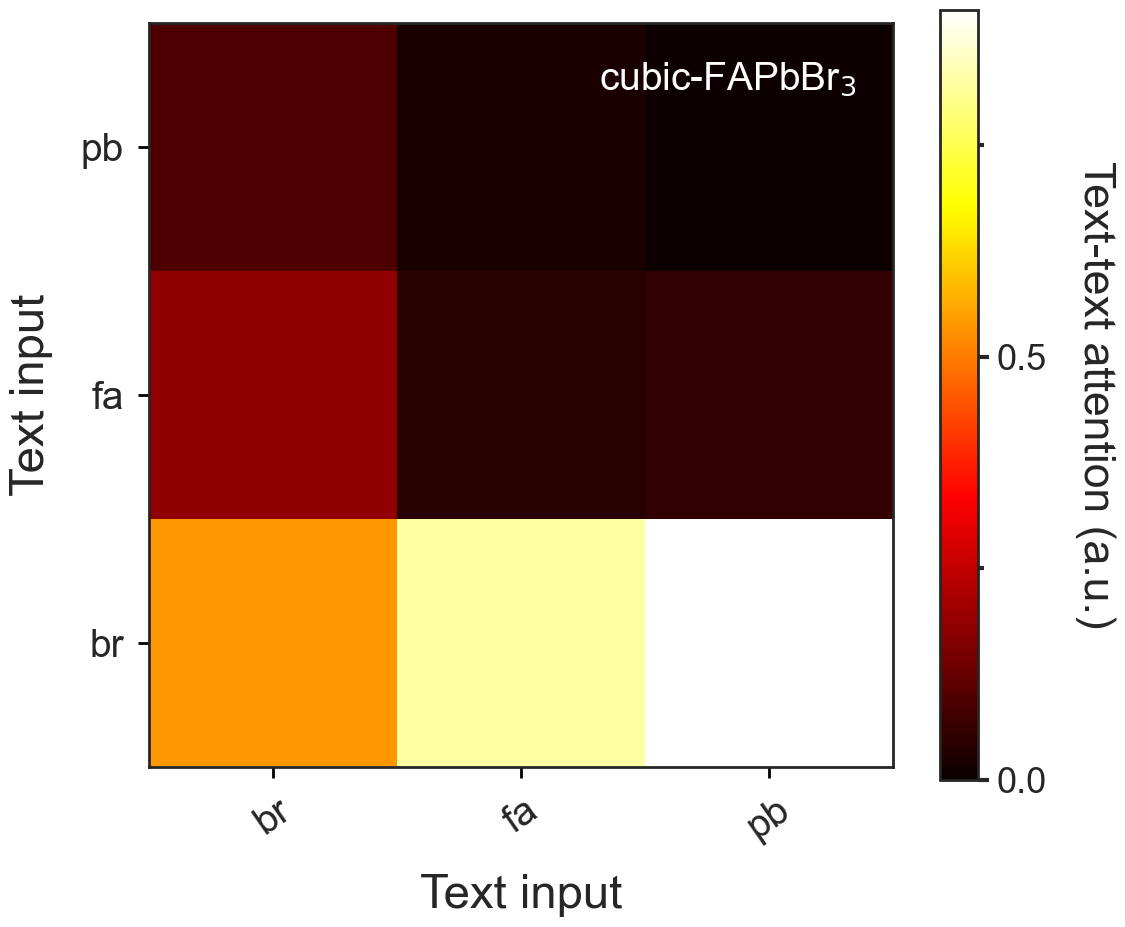

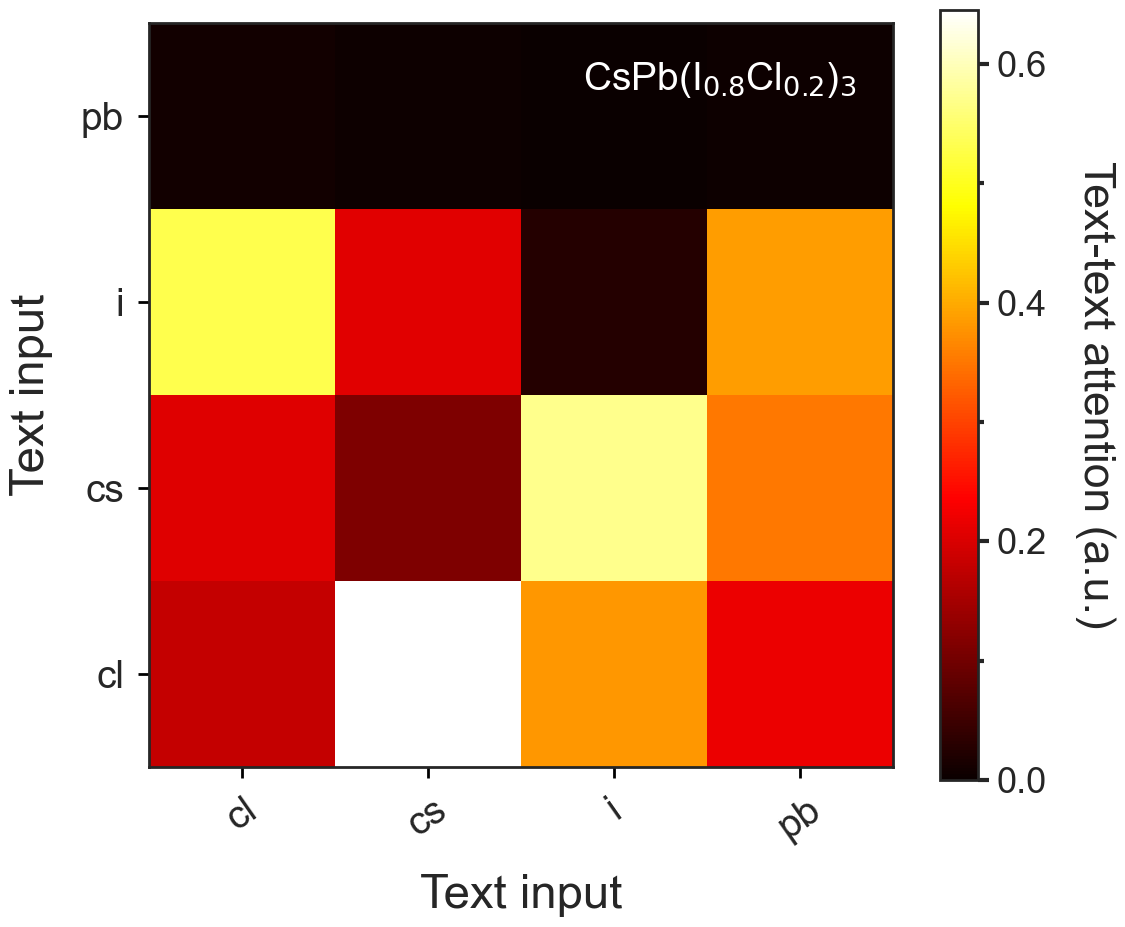

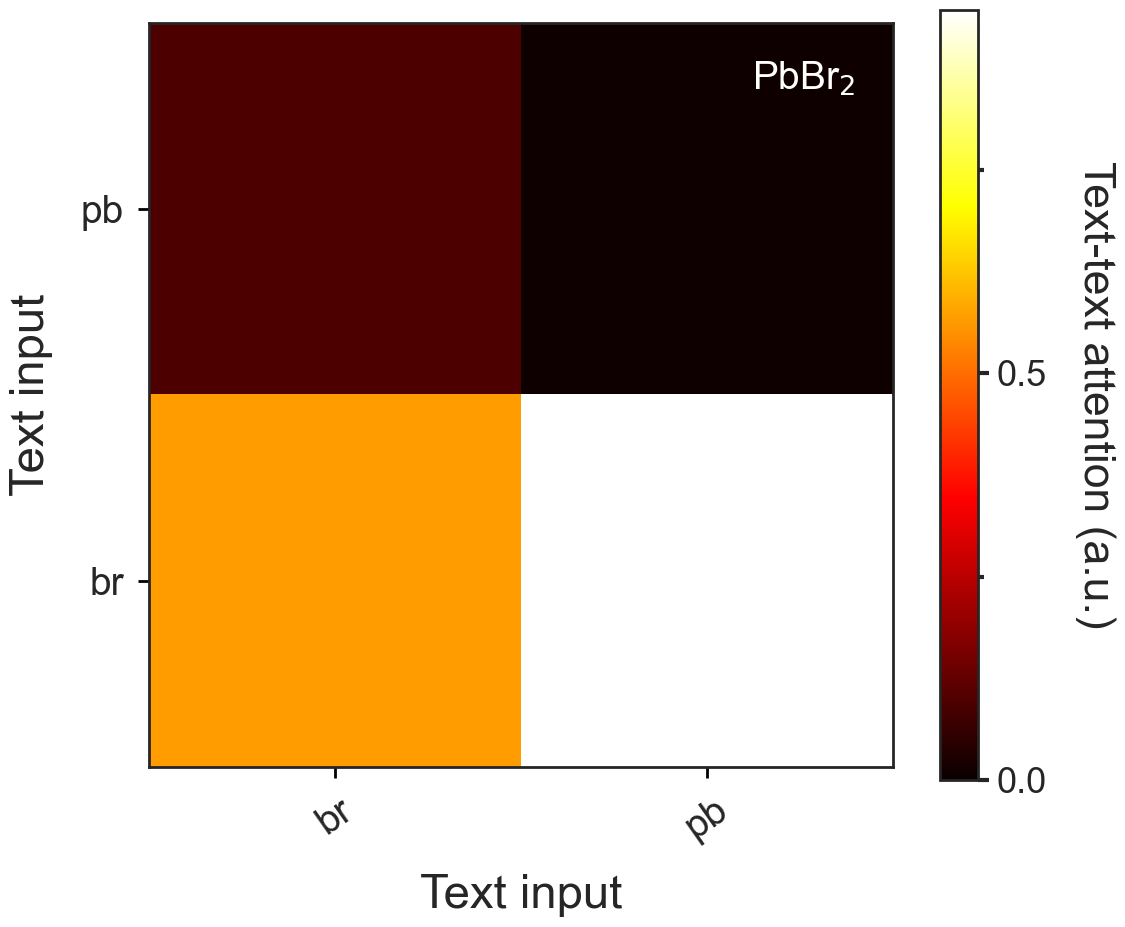

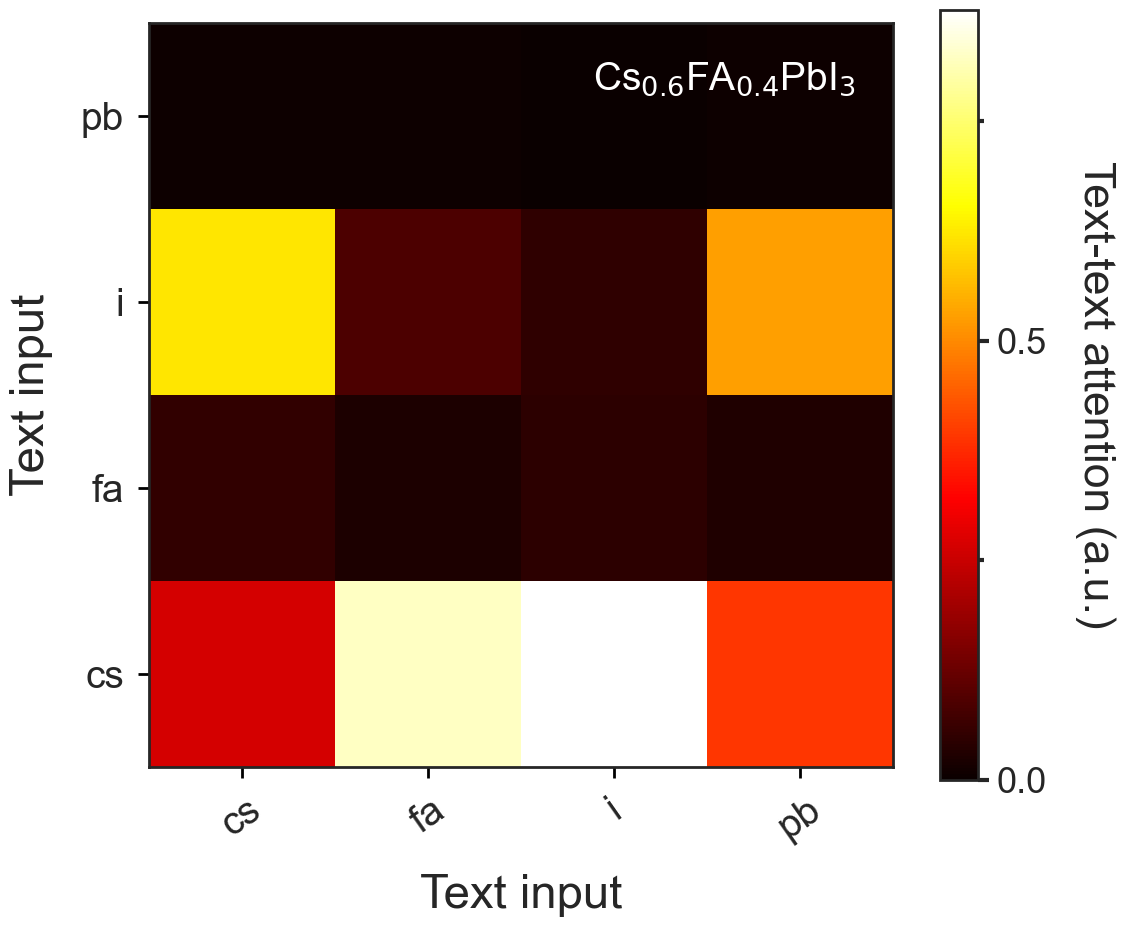

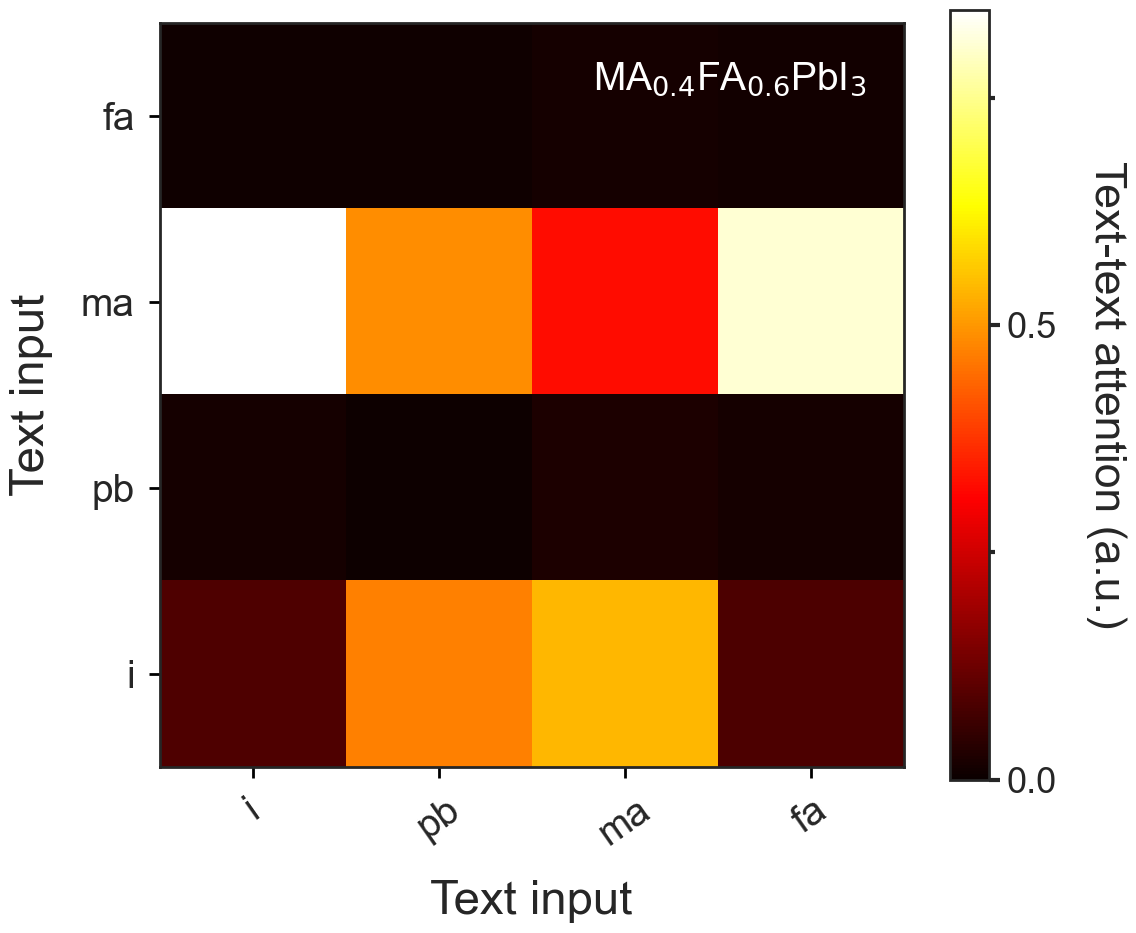

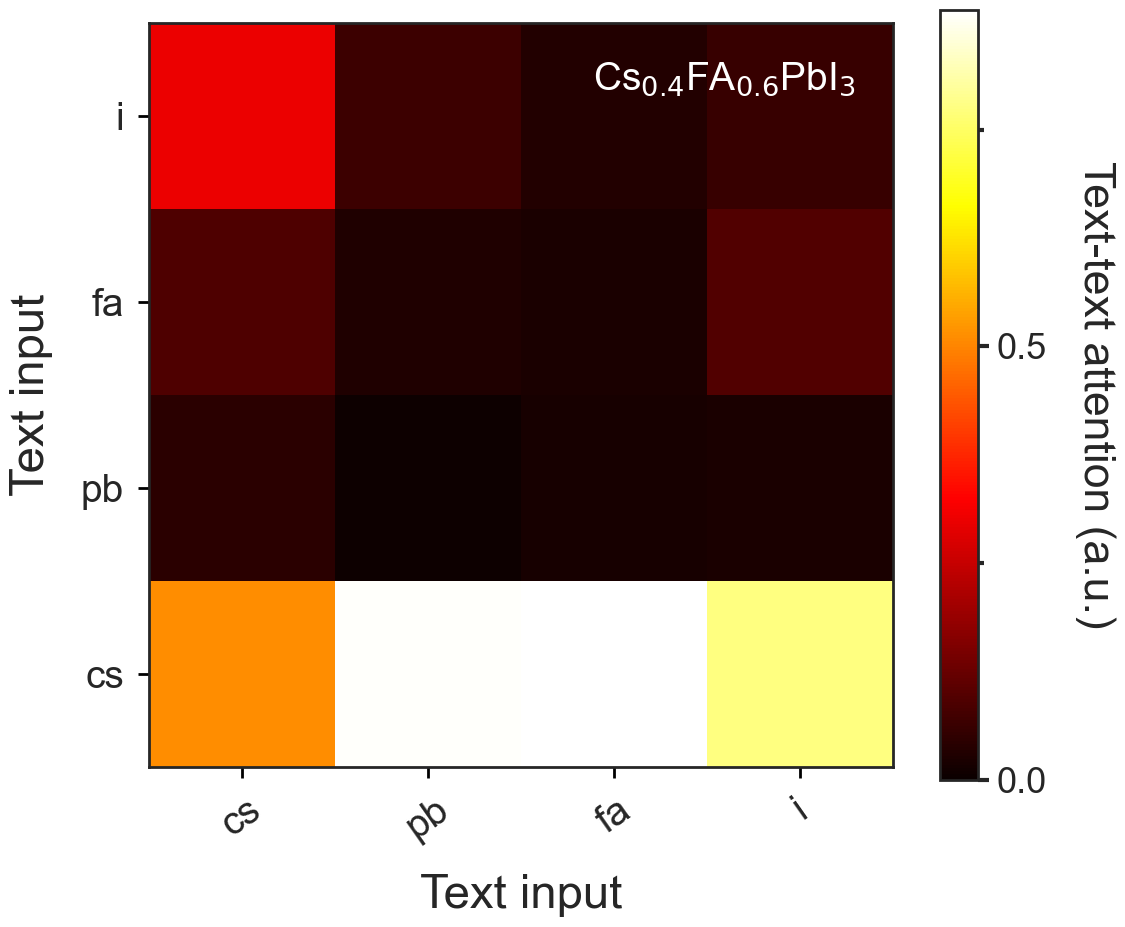

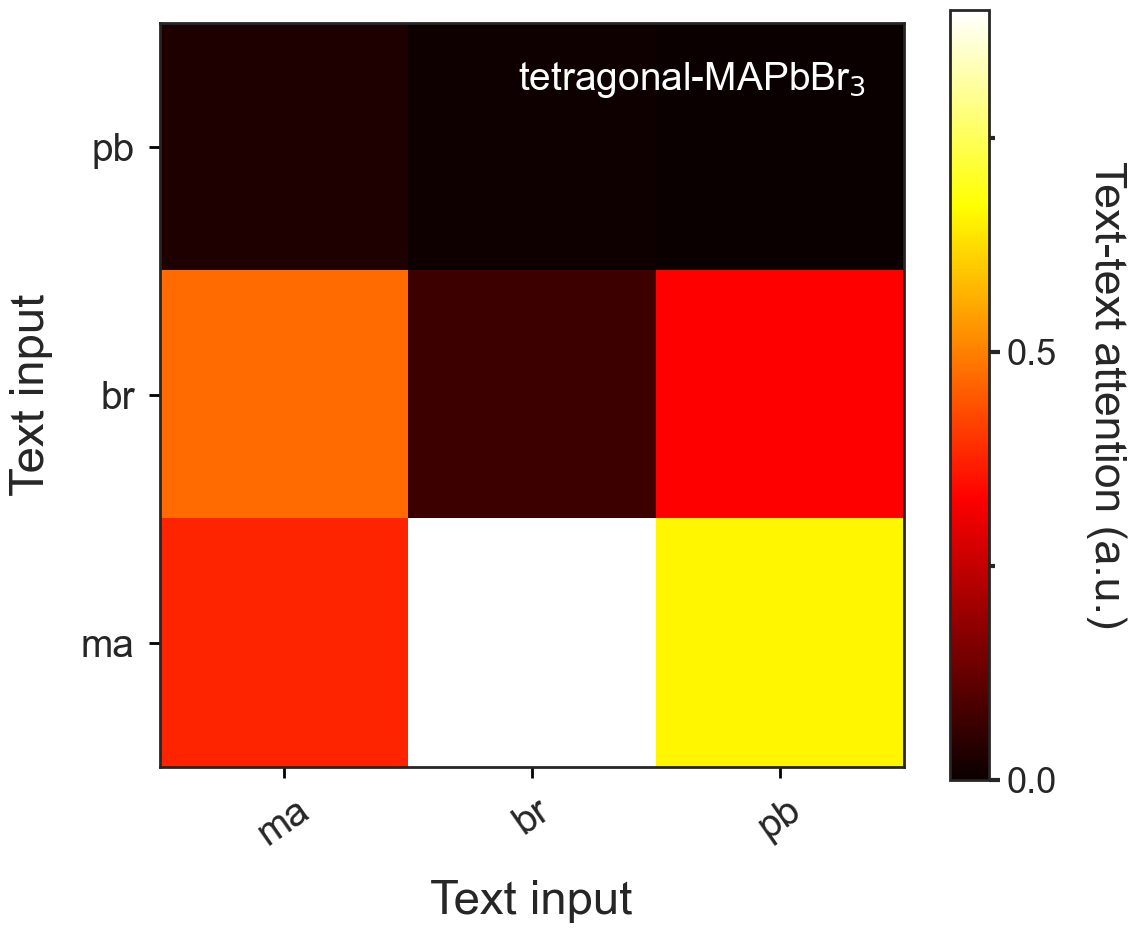

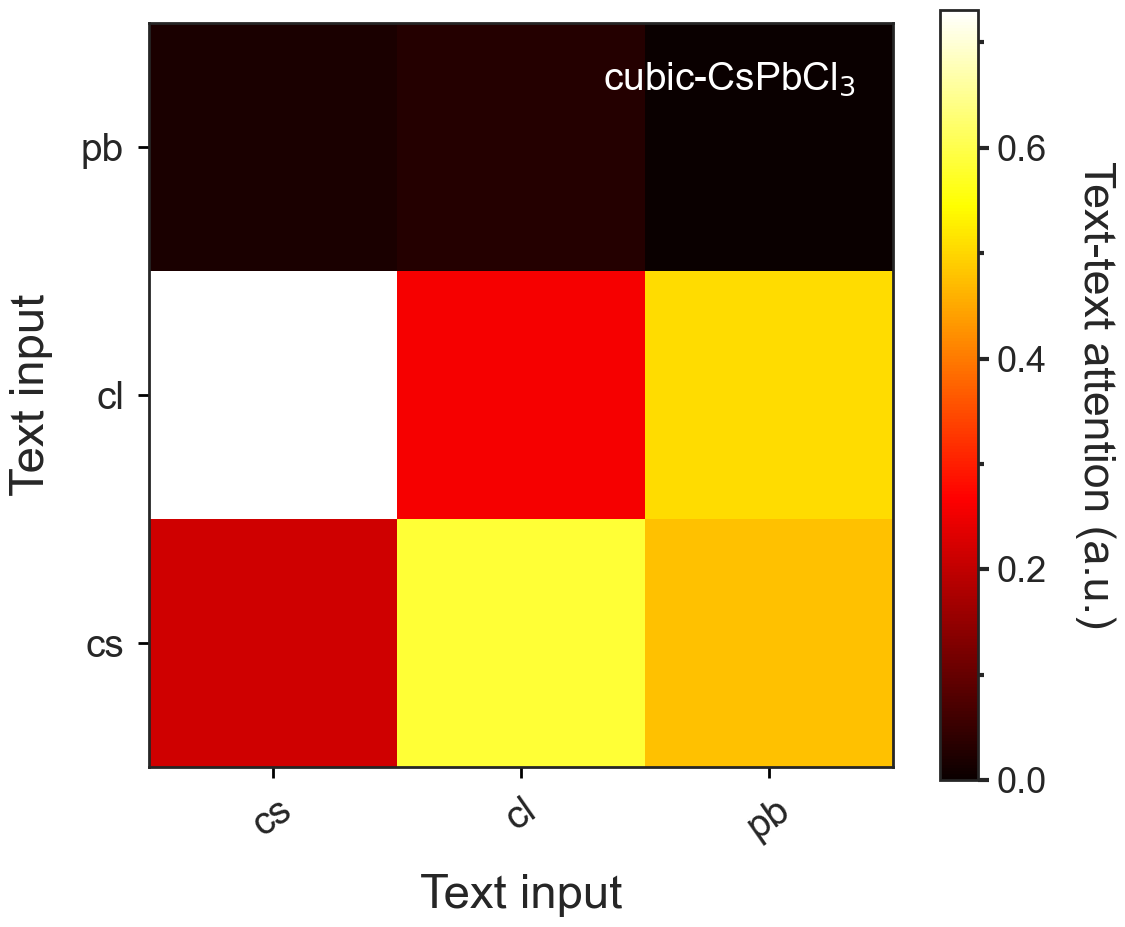

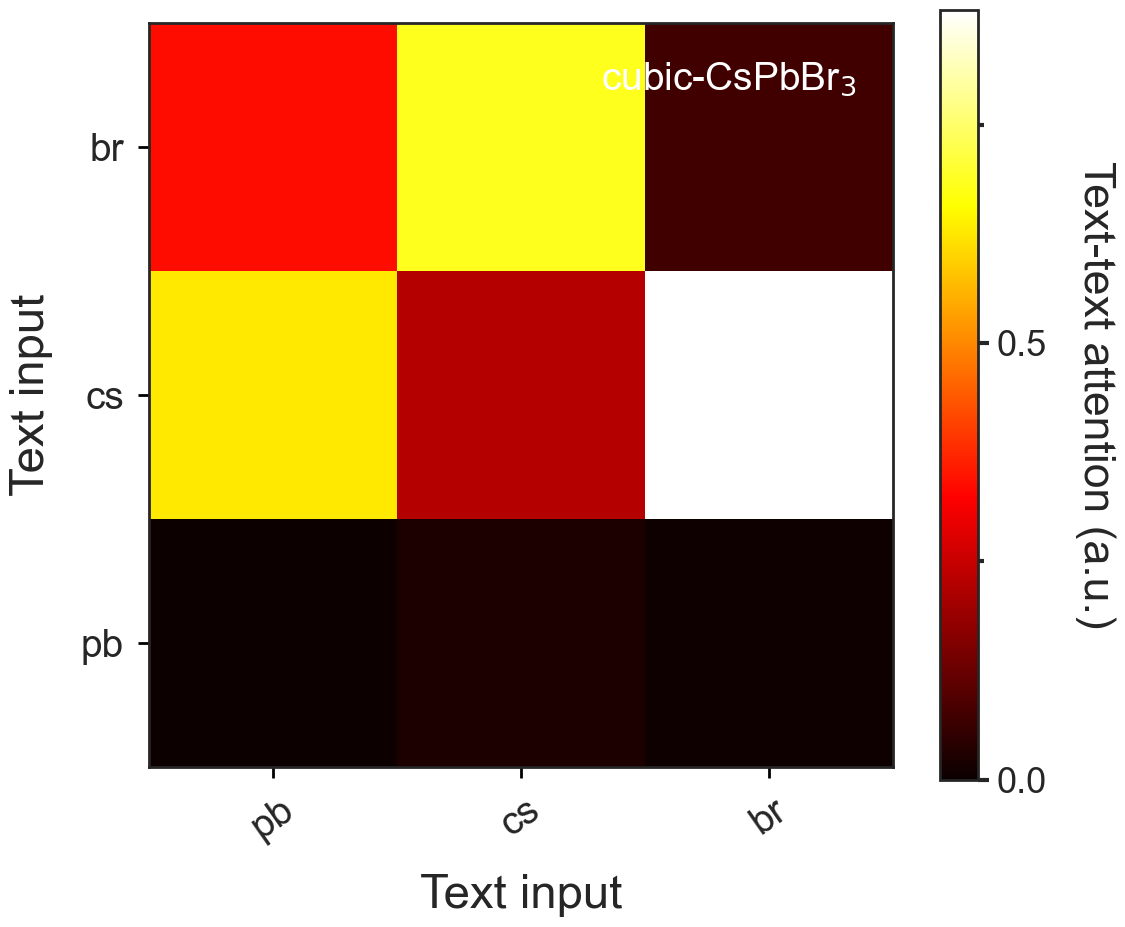

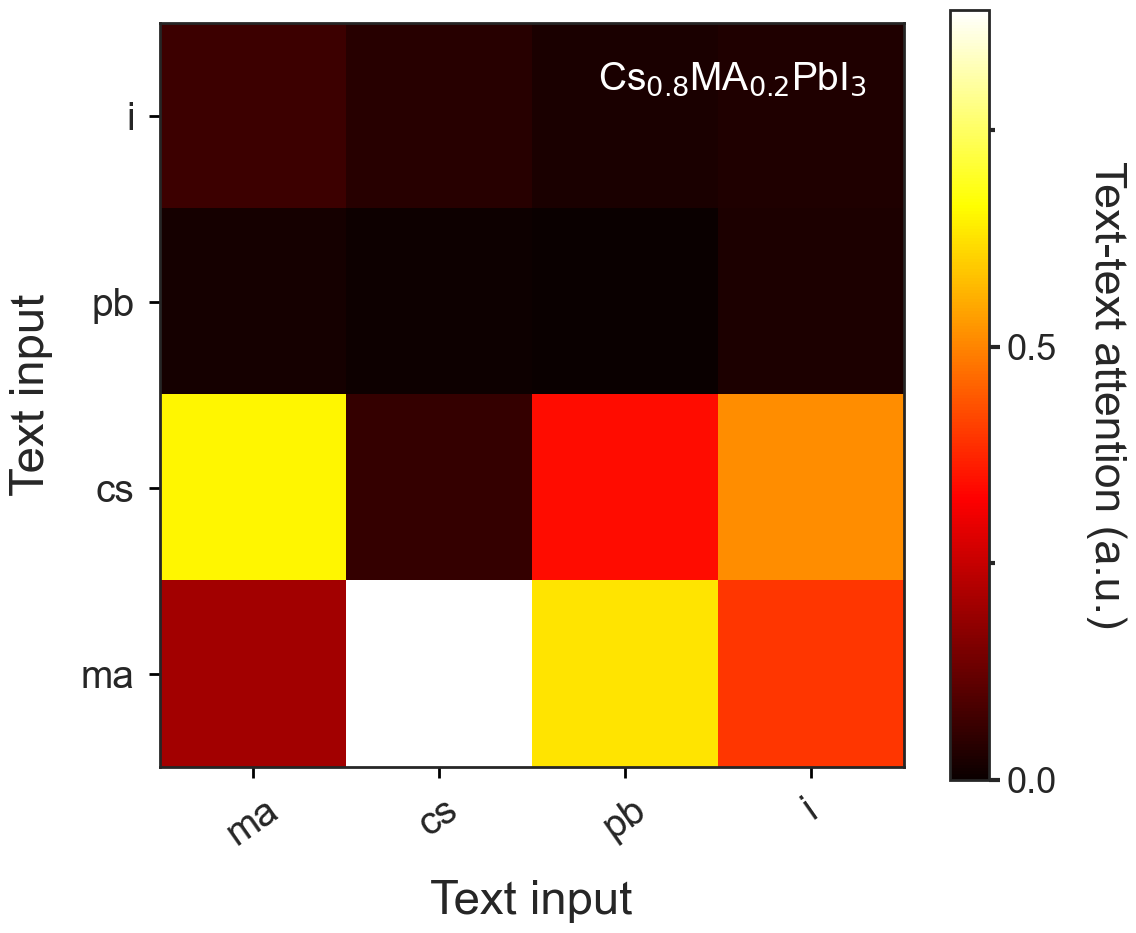

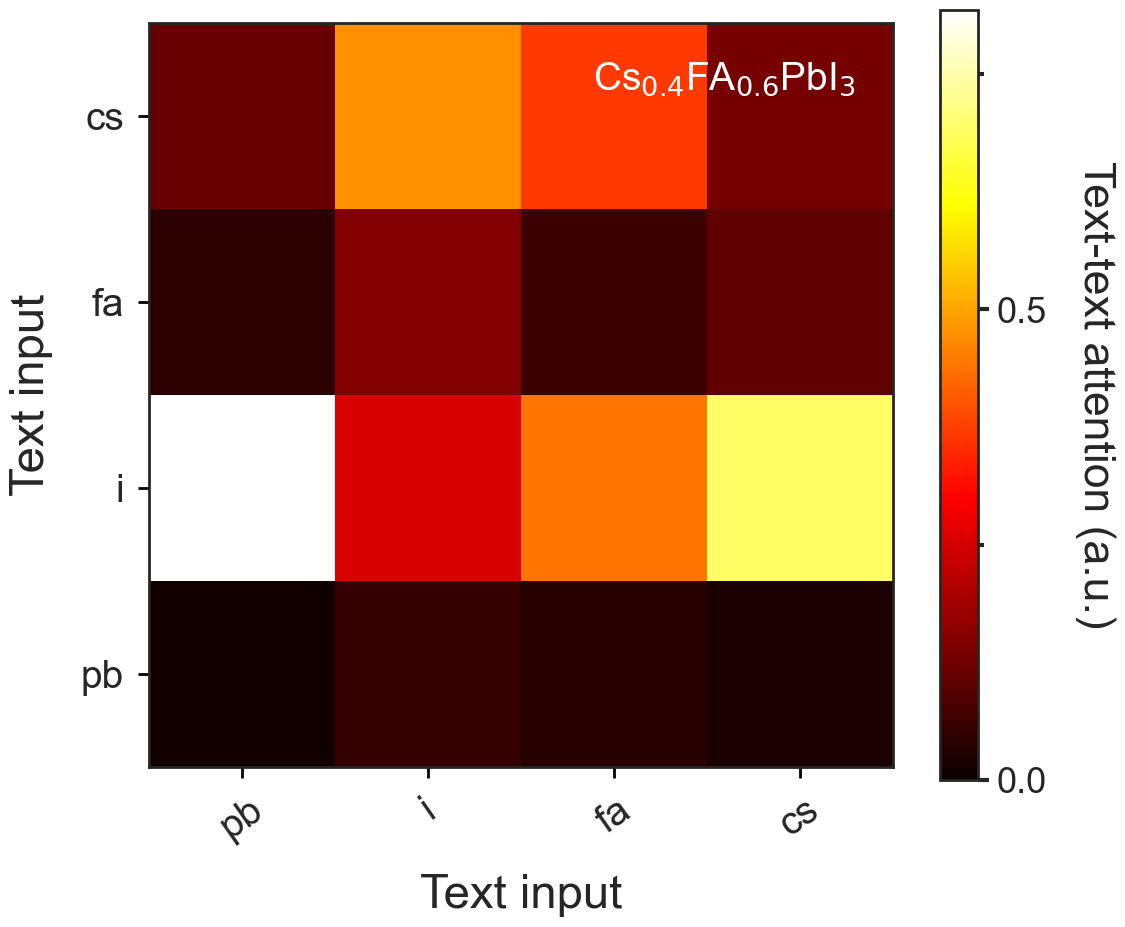

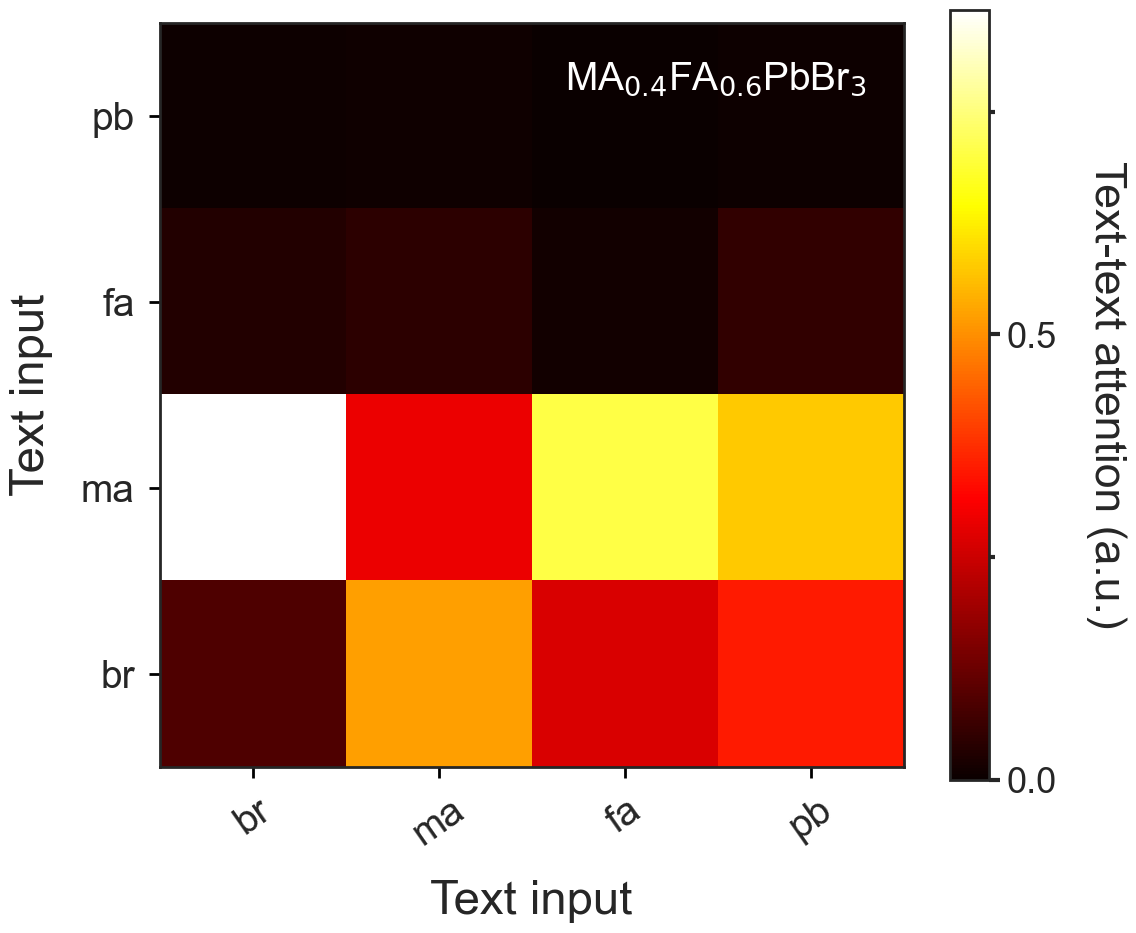

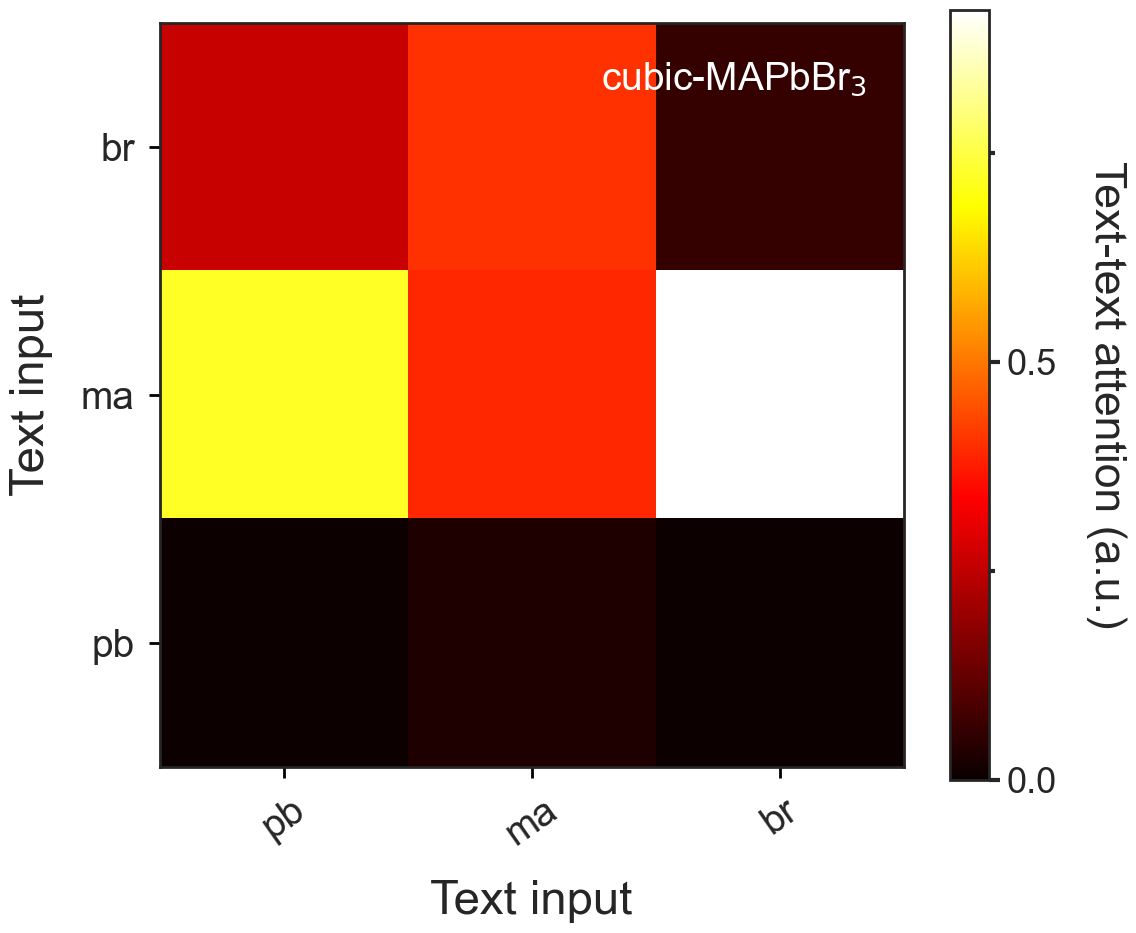

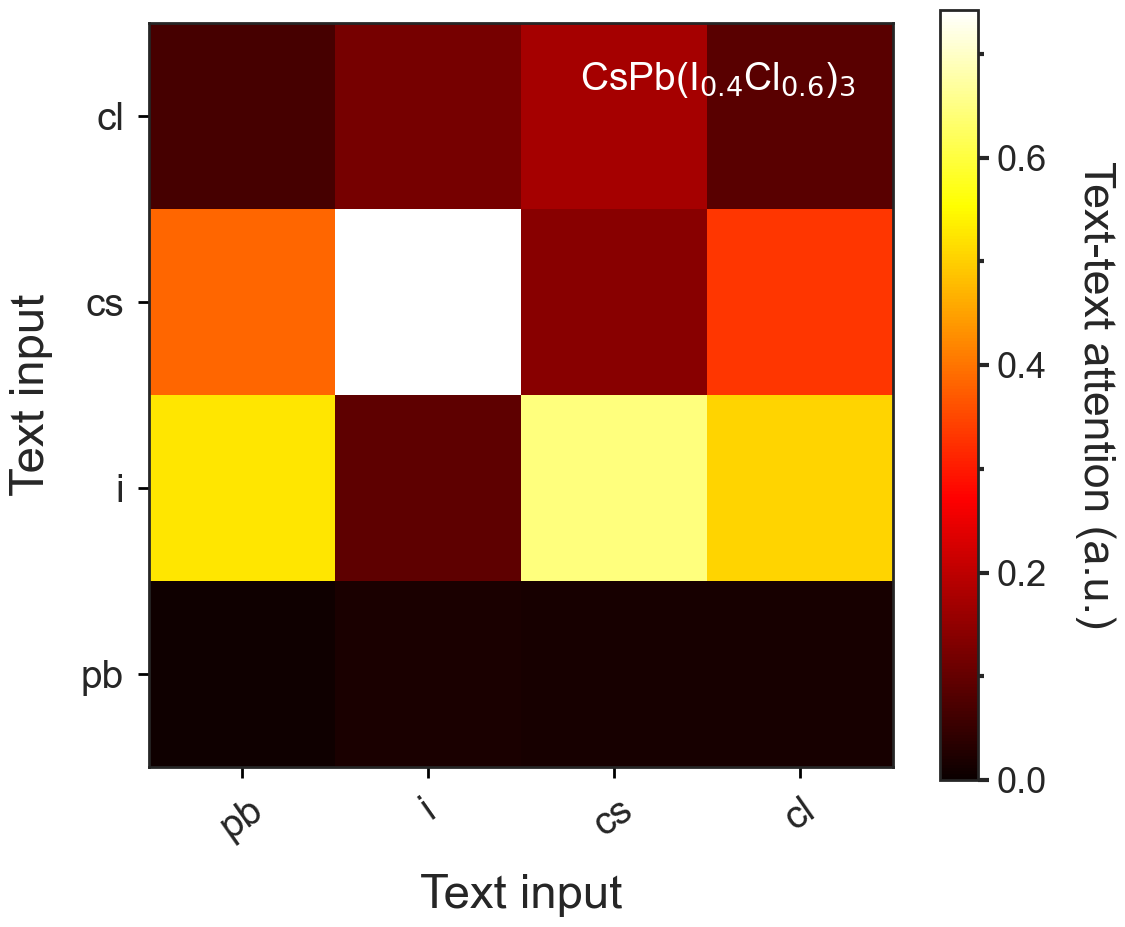

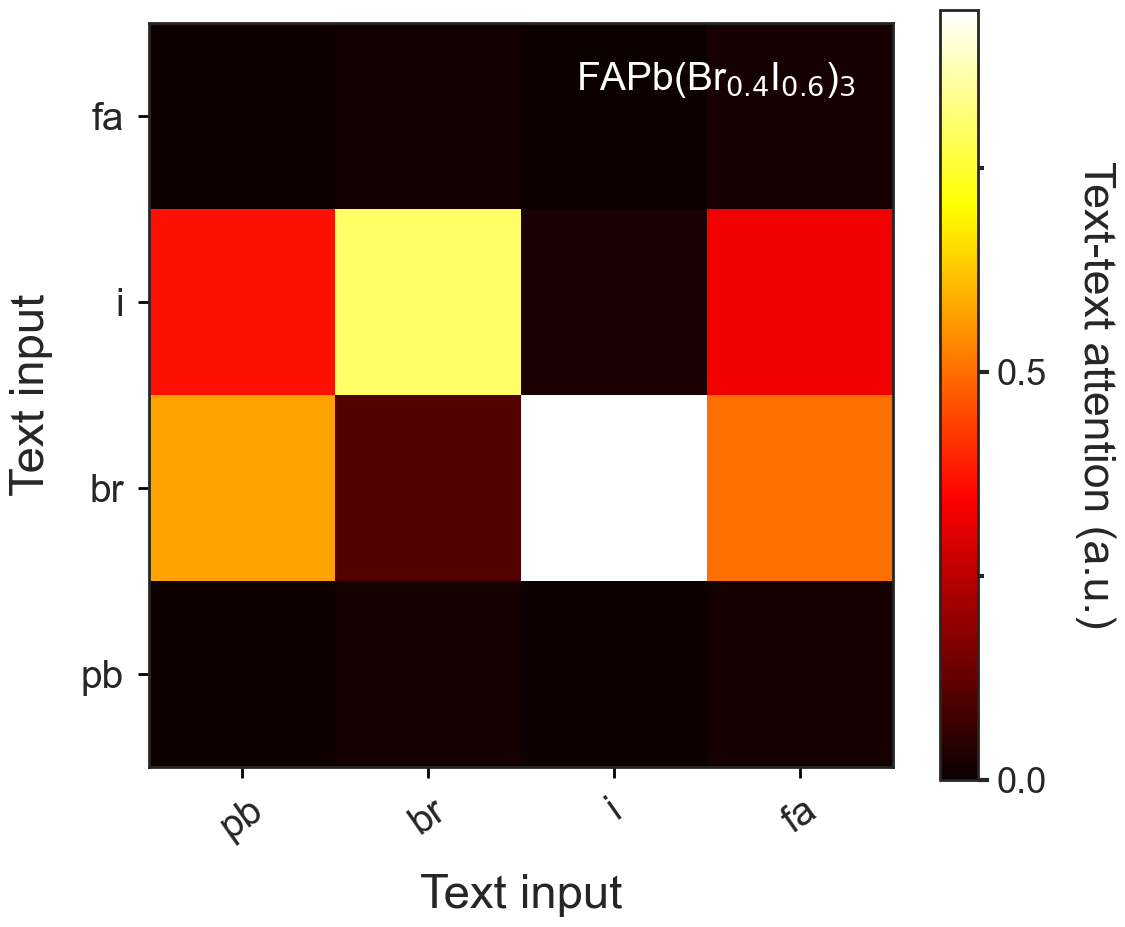

In [335]:
for i in range(30):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    Y = np.sum(np.array(outputs.attentions[0].detach().cpu())[0,:,1:len(inputs['input_ids'][0])-1,1:len(inputs['input_ids'][0])-1],axis=0)
    extent = [0.5,0.5+len(inputs['input_ids'][0])-2,0.5,0.5+len(inputs['input_ids'][0])-2]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1], rotation=35)
    ax.set_yticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1])
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Text-text attention (a.u.)',labelpad=50, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
    ax.set_ylabel(r'Text input', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), 
             fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    
    plt.savefig(os.path.join(folder, 'models', model_folder,'{}_attention_text.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


# 5 Experimental data

In [28]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
model_folder = '20240906 single phase'
# model_folder = '20240907 multi label'
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', model_folder,'100000')).to('cuda')

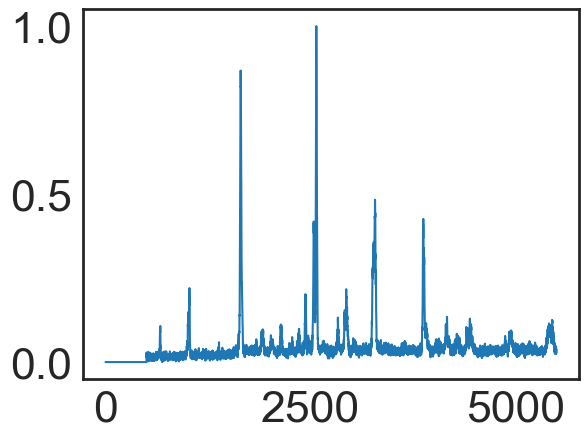

In [279]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240516 OT\CsPbBr\4 CsPb1Br3_Theta_2-Theta_fit.xy', delimiter=" ", unpack=False)
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240516 OT\CsPbBr\1 CsPb2Br5_Theta_2-Theta_fit.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = data[:,1]
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

In [104]:
y_true, y_pred, y_formula = [], [], []

Xs_test = Xs[0,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)
logits = torch.topk(outputs.logits[0], 1).indices
y_pred = list(np.array(logits.detach().cpu()))

In [268]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
for idx in y_pred:
    print(idx, np.array(softmax(outputs.logits)[0,idx].detach().cpu()), dataloader.dataset[dataloader.sample_list[idx]]['formula'])

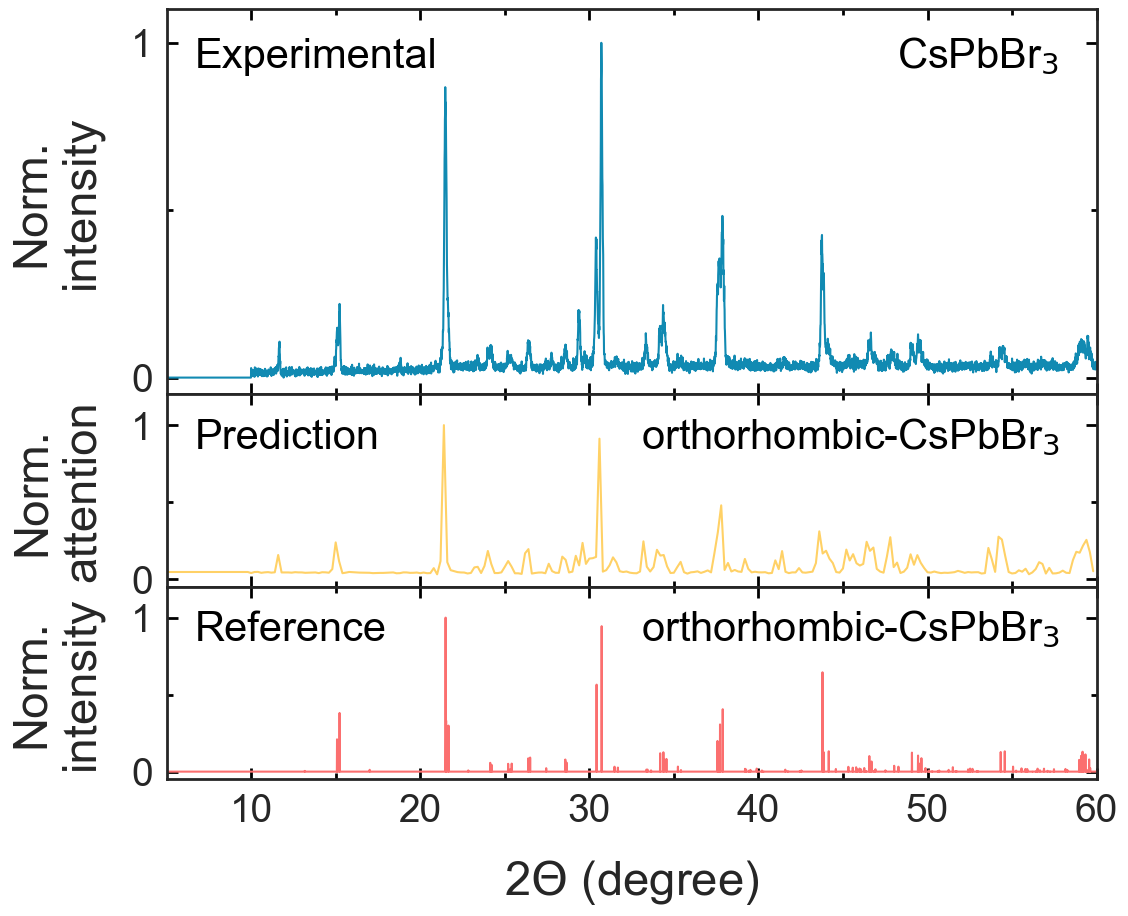

In [308]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['Cs Pb Br',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'CsPbBr3')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula_list[i][0])), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


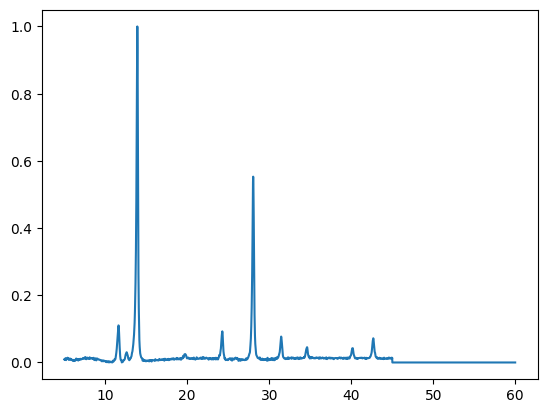

In [41]:
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3.csv', delimiter=",", unpack=False)
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3_fit.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1]-data[:,4])(np.arange(5.00, 45.01, 0.01))
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(twotheta,Xs[0,:,0])

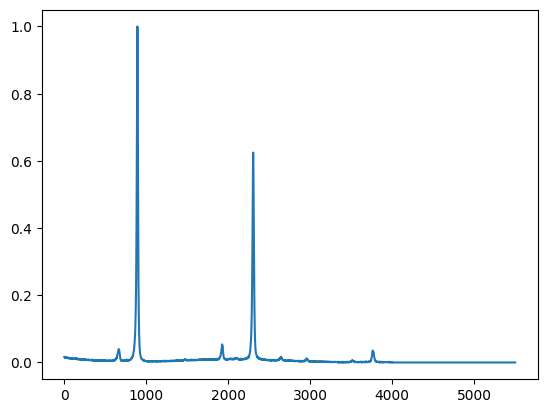

In [32]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\GB_3.csv', delimiter=",", unpack=False)
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3_fit.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1])(np.arange(5.00, 45.01, 0.01))
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

In [42]:
y_true, y_pred, y_formula = [], [], []

Xs_test = Xs[0,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)
logits = torch.topk(outputs.logits[0], 20).indices
y_pred = list(np.array(logits.detach().cpu()))

In [43]:
for idx in y_pred:
    print(idx, dataloader.dataset[dataloader.sample_list[idx]]['formula'],np.array(outputs.logits[0].detach().cpu())[idx])

44 alpha-FAPbI3 9.33871
46 delta-FAPbI3 8.099103
60 tetragonal-MAPbBr3 2.465374
4 Cs0.2FA0.8PbI3 2.0282676
65 PbI2 1.7740173
62 alpha-MAPbI3 1.7330676
7 Cs0.8FA0.2PbI3 1.3109987
32 cubic-CsPbBr3 1.1496482
45 beta-FAPbI3 1.0594403
2 Cs0.6FA0.4PbBr3 0.9458855
54 MA0.8FA0.2PbI3 0.91527843
16 Cs4PbBr6 0.85488844
42 FAPb(Br0.8I0.2)3 0.83029073
29 CsPb(I0.4Cl0.6)3 0.7844297
3 Cs0.8FA0.2PbBr3 0.742192
39 FAPb(Br0.2I0.8)3 0.70042056
34 Pnma-CsPbCl3 0.59099156
20 CsPb(Cl0.2Br0.8)3 0.56310356
50 MA0.8FA0.2PbBr3 0.515597
27 CsPb(I0.8Br0.2)3 0.5009957
